In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.offline as py
from tqdm.notebook import tqdm
from glob import glob
from pathlib import Path
from bayes_opt import BayesianOptimization
from typing import Iterable
from sklearn.metrics import log_loss
import gc
import cv2
import math
from joblib import Parallel, delayed
import random
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score
import logging
from warmup_scheduler import GradualWarmupScheduler
from typing import TYPE_CHECKING, Any, Callable, Optional
from IPython.display import display, Audio
from nnAudio.Spectrogram import CQT1992v2, MFCC, MelSpectrogram

import torch
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
from torch.nn import functional as F
from torch.optim import Adam, AdamW, SGD
from torch.optim.optimizer import Optimizer
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR, _LRScheduler

import albumentations as al
from albumentations.pytorch.transforms import ToTensorV2, ToTensor
from albumentations.core.transforms_interface import BasicTransform, ImageOnlyTransform

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from torchmetrics import Accuracy
from torchmetrics.metric import Metric
from pytorch_lightning.metrics.classification import AUROC
from pytorch_lightning.plugins import DDPPlugin

import librosa
from librosa import power_to_db
from librosa.display import waveplot, specshow
from librosa.feature import melspectrogram, mfcc, spectral, delta
from librosa.util import fix_length, pad_center
from librosa.beat import beat_track

import timm
from timm.optim.adabelief import AdaBelief
from timm.optim.radam import RAdam
from timm.optim.lookahead import Lookahead
from timm.models.layers import SelectAdaptivePool2d

import warnings
warnings.filterwarnings("ignore")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
py.init_notebook_mode(connected=True)

# Config

In [10]:
TRAIN_PATH = Path('./input/aicv115m/aicv115m_final_public_train/aicv115m_final_public_train/')
TEST_PATH = Path('./input/aicv115m/aicv115m_final_private_test/aicv115m_final_private_test/')
TRAIN_WARM = Path('./input/aicv115m/aicv115m_public_train/')

TRAIN_WARM_CSV = TRAIN_WARM / 'metadata_train_challenge.csv'                  
TRAIN_CSV = TRAIN_PATH / 'public_train_metadata.csv'
TRAIN_CONDITION_CSV = TRAIN_PATH / 'public_train_medical_condition.csv'
TEST_CSV = TEST_PATH / 'private_test_sample_submission.csv'
TEST_CONDITION_CSV = TEST_PATH / '.csv'
SUB_PATH = TEST_PATH / 'private_test_sample_submission.csv'

TRAIN_WARM_PATH = TRAIN_WARM / 'train_audio_files_8k' / 'train_audio_files_8k'
TRAIN_FILE_PATH = TRAIN_PATH / 'public_train_audio_files'
TEST_FILE_PATH = TEST_PATH / 'private_test_audio_files'

CSV_PATH = './csv/'

SR = 32000
SEED = 37
KFOLD = 5
COUGH = 0.06
list_age = ['group_0_2', 'group_3_5', 'group_6_13', 'group_14_18', 'group_19_33',
            'group_34_48', 'group_49_64', 'group_65_78', 'group_79_98']

# Function

In [11]:
def removeNoise(y, window=5, threshold=COUGH):
    for i in range(len(y)):
        if y[i:min(i+window, len(y))].sum() >= threshold:
            y = y[i:]
            break
    y = y[::-1]
    for i in range(len(y)):
        if y[i:min(i+window, len(y))].sum() >= threshold:
            return y[i:][::-1]
        
def startClean(path, window=10):
    y = librosa.load(path, sr=SR)[0]
    threshold = 1/2*np.max(y)
    for i in range(len(y)):
        if y[i:min(i+window, len(y))].sum() >= threshold:
            return i
    return 0

def endClean(path, window=10):
    y = librosa.load(path, sr=SR)[0]
    threshold = 1/2*np.max(y)
    for i in range(len(y), 0, -1):
        if y[max(i-window, 0):i].sum() >= threshold:
            return i
    return len(y)

def checkAudio(path, threshold=COUGH):
    y = librosa.load(path, sr=SR)[0]
    if max(y) < threshold:
        return 0
    return 1
        
def calTime(x):
    return len(librosa.load(x, sr=SR, duration=20)[0])/SR
    
    
def mono_to_color(X, eps=1e-6, mean=None, std=None):
    mean = mean or X.mean()
    std = std or X.std()
    X = (X - mean) / (std + eps)

    _min, _max = X.min(), X.max()

    if (_max - _min) > eps:
        V = np.clip(X, _min, _max)
        V = 255 * (V - _min) / (_max - _min)
        V = V.astype(np.uint8)
    else:
        V = np.zeros_like(X, dtype=np.uint8)

    return V

# Read File

In [12]:
# file = ['36b11269-963b-481a-9569-751f8b4c65a5', 'c096b45b-fc28-4ba1-86ce-799cf31e1f48']

# trainex_df = pd.read_csv(TRAIN_EX_PATH)
# trainex_df = trainex_df[trainex_df.assessment_result!='unknown'].reset_index(drop=True)
# trainex_df = trainex_df[~trainex_df.uuid.isin(file)].reset_index(drop=True)
# trainex_df['file_path'] = trainex_df['uuid'].apply(lambda x: str(TRAIN_EX / x) + '.wav')
# trainex_df.rename(columns={'subject_gender_prediction': 'subject_gender'}, inplace=True)

# trainex_df.tail()

In [13]:
%%time
    
gender = {'male': 0, 'female': 1, 'unknown': -1}

kf = KFold(n_splits=KFOLD, random_state=SEED, shuffle=True)

train_df = pd.read_csv(TRAIN_CSV)
train_df['file_path'] = train_df['uuid'].apply(lambda x: str(TRAIN_FILE_PATH / x) + '.wav')
train_df = pd.concat([train_df, trainex_df[[i for i in train_df.columns]]], axis=0).reset_index(drop=True)
train_df['start'] = Parallel(n_jobs=-1, backend='multiprocessing')\
(delayed(startClean)(path) for path in tqdm(train_df.file_path, total=len(train_df)))
train_df['end'] = Parallel(n_jobs=-1, backend='multiprocessing')\
(delayed(endClean)(path) for path in tqdm(train_df.file_path, total=len(train_df)))
train_df['gender'] = train_df['subject_gender'].apply(lambda x: gender[x])
age_df = pd.get_dummies(train_df['subject_age'])
train_df = pd.concat([train_df, age_df], axis=1).reset_index(drop=True)
display(train_df.head(60))
meta_col = ['gender'] + list_age
for fold, (train_idx, valid_idx) in \
enumerate(kf.split(train_df, train_df.assessment_result,
                   train_df[['subject_age', 'subject_gender']])):
    train_df.loc[valid_idx, 'fold'] = fold
train_df['fold'] = train_df['fold'].astype(int)

print(meta_col)
train_df.to_csv('./input/train_clean.csv', index=False)    

train_df.tail()

In [14]:
meta_col = ['gender'] + list_age
print(meta_col)
train_df = pd.read_csv('./input/train_clean.csv')
train_df.tail()

['gender', 'group_0_2', 'group_3_5', 'group_6_13', 'group_14_18', 'group_19_33', 'group_34_48', 'group_49_64', 'group_65_78', 'group_79_98']


uuid subject_age subject_gender  \
4529  ba24cce1-2952-4d30-8047-cfdf9fc55a3e     unknown           male   
4530  a05f748c-e10f-4c0f-be5f-6a78472f39a4     unknown           male   
4531  edba0a07-7f31-4804-8c4b-930fdcc7fd2c     unknown        unknown   
4532  e7176187-6ca9-4439-a4d6-78bdca8f62af     unknown           male   
4533  fa95de53-ebb5-4ae4-966a-29a2ce27e1e1     unknown         female   

     audio_noise_note                                    cough_intervals  \
4529              NaN  [{'start': 0.33890803074476544, 'end': 1.10709...   
4530              NaN  [{'end': 1.936755485893417, 'start': 1.6387931...   
4531              NaN  [{'start': 0.5201460292580983, 'end': 1.136814...   
4532              NaN  [{'start': 0.8772925809822362, 'end': 1.328616...   
4533              NaN  [{'start': 1.8689651832910956, 'end': 2.702980...   

      assessment_result                                          file_path  \
4529                  1  input/aicv115m/aicv115m_extra_public_1235sampl...   
4530                  1  input/aicv115m/aicv115m_extra_public_1235sampl...   
4531                  1  input/aicv115m/aicv115m_extra_public_1235sampl...   
4532                  1  input/aicv115m/aicv115m_extra_public_1235sampl...   
4533                  1  input/aicv115m/aicv115m_extra_public_1235sampl...   

      start     end  gender  ...  group_14_18  group_19_33  group_34_48  \
4529   3315  360986       0  ...            0            0            0   
4530   3082  192188       0  ...            0            0            0   
4531  16829  147951      -1  ...            0            0            0   
4532  28480  141824       0  ...            0            0            0   
4533   1613  154252       1  ...            0            0            0   

      group_3_5  group_49_64  group_65_78  group_6_13  group_79_98  unknown  \
4529          0            0            0           0            0        1   
4530          0            0            0           0            0        1   
4531          0            0            0           0            0        1   
4532          0            0            0           0            0        1   
4533          0            0            0           0            0        1   

      fold  
4529     3  
4530     1  
4531     4  
4532     3  
4533     1  

[5 rows x 21 columns]

In [15]:
# %%time

# test_df = pd.read_csv(TEST_CSV)
# test_df['file_path'] = test_df['uuid'].apply(lambda x: str(TEST_FILE_PATH / x) + '.wav')
# test_df['start'] = Parallel(n_jobs=-1, backend='multiprocessing')\
# (delayed(startClean)(path) for path in tqdm(test_df.file_path, total=len(test_df)))
# test_df['end'] = Parallel(n_jobs=-1, backend='multiprocessing')\
# (delayed(endClean)(path) for path in tqdm(test_df.file_path, total=len(test_df)))
# test_df.to_csv('./input/test_clean.csv', index=False)

# test_df.tail()

In [16]:
test_df = pd.read_csv('./input/test_clean.csv')
test_df.tail()

uuid  assessment_result  \
1622  49073fde-34fb-423a-9789-5fcb3165e779                  0   
1623  3fa4839d-3fbf-4621-81a5-60daaefc69f4                  0   
1624  40b4e983-3f12-4a2e-a562-9b179f21154e                  0   
1625  95318505-7b3d-408d-83c6-f816d338ccb5                  0   
1626  d6364c62-70e7-484e-9fec-7bc986a222dc                  0   

                                              file_path  start     end  
1622  input/aicv115m/aicv115m_final_private_test/aic...  24493  295127  
1623  input/aicv115m/aicv115m_final_private_test/aic...  33151  274997  
1624  input/aicv115m/aicv115m_final_private_test/aic...  65546  459824  
1625  input/aicv115m/aicv115m_final_private_test/aic...   6980   86309  
1626  input/aicv115m/aicv115m_final_private_test/aic...    972  320218

In [17]:
# result = {0: 'negative', 1: 'positive'}

# genderTrain = train_df.groupby(['subject_gender'])['uuid'].count().reset_index(name='numberFiles')
# ageTrain = train_df.groupby(['subject_age'])['uuid'].count().reset_index(name='numberFiles')
# resultTrain = train_df.groupby(['assessment_result'])['uuid'].count().reset_index(name='numberFiles')


# fig = make_subplots(rows = 2, cols = 2, subplot_titles=['gender train', 'age train', 'result train'],
#                     specs=[[{'type': 'pie'}, {'type': 'pie'}], [{'type': 'pie', 'colspan': 2}, None]], 
#                     vertical_spacing = 0.1, horizontal_spacing = 0.1)

# fig.add_trace(go.Pie(values=genderTrain.numberFiles, labels=genderTrain.subject_gender,
#                      hole=0.3, textinfo="label+percent+value"), row=1, col=1)
# fig.add_trace(go.Pie(values=ageTrain.numberFiles, labels=ageTrain.subject_age,
#                      hole=0.3, textinfo="label+percent+value"), row=1, col=2)
# fig.add_trace(go.Pie(values=resultTrain.numberFiles, labels=resultTrain.assessment_result.apply(lambda x: result[x]),
#                      hole=0.3, textinfo="label+percent+value"), row=2, col=1)


# fig.update_layout(
#     title = {
#         'text': f'Statistic of gender and age', 'font': {'color': 'blue', 'size': 16},
#         'y': 0.97, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'
#     },
#     showlegend = False, height = 600, width = 900
# )

# py.iplot(fig, show_link = False)

# del genderTrain, resultTrain
# gc.collect()

In [18]:
# genderAge = train_df.groupby(['subject_gender', 'subject_age'])['uuid']\
# .count().reset_index(name='numberPeople')
# positiveAge = train_df[train_df.assessment_result==1].groupby(['subject_gender',
#                                                                'subject_age'])['uuid']\
# .count().reset_index(name='numberPositive')
# genderAge = genderAge.merge(positiveAge, on=['subject_gender', 'subject_age'], how='left')
# genderAge['numberPositive'].fillna(0, inplace=True)
# genderAge['ratioPositive'] = (100*genderAge['numberPositive']/genderAge['numberPeople']).round(2)
# genderAge['idx'] = genderAge['subject_age'].apply(lambda x: list_age.index(x))
# genderAge.sort_values(['subject_gender', 'idx'], inplace=True)
# del genderAge['idx']
# display(genderAge)

# fig = go.Figure()
# fig.add_trace(go.Bar(y=list_age, x=genderAge[genderAge.subject_gender=='male']['numberPeople'].values,
#                      orientation='h', name='Male', hoverinfo='x', marker=dict(color='powderblue')))
# fig.add_trace(go.Bar(y=list_age, x=genderAge[genderAge.subject_gender=='male']['numberPositive'].values,
#                      opacity=0.5, orientation='h', name='Male_Positive', hoverinfo='x', marker=dict(color='teal')))

# fig.add_trace(go.Bar(y=list_age, x=-1*genderAge[genderAge.subject_gender=='female']['numberPeople'].values,
#                      orientation='h', name='Female', hoverinfo='x', marker=dict(color='seagreen')))
# fig.add_trace(go.Bar(y=list_age, x=-1*genderAge[genderAge.subject_gender=='female']['numberPositive'].values,
#                      opacity=0.5, orientation='h', name='Female_Positive', hoverinfo='x', marker=dict(color='darkgreen')))

# fig.update_layout(
#     title = {
#         'text': f'Statistic of gender and result', 'font': {'color': 'blue', 'size': 16},
#         'y': 0.9, 'x': 0.5, 'xanchor': 'center', 'yanchor': 'top'
#     },
#     height = 500, width = 950,
#     yaxis=go.layout.YAxis(title='Age'),
#     xaxis=go.layout.XAxis(
#        range=[-1000, 2000],
#        tickvals=np.arange(-1000, 2000, 100),
#        ticktext=np.arange(1000, 0, -100).tolist() + np.arange(0, 2000, 100).tolist(),
#        title='Number'),
#    barmode='overlay',
#    bargap=0.1
# )

# py.iplot(fig)

In [19]:
train_folder = glob(f'{TRAIN_FILE_PATH}/*.wav') + glob(f'{TRAIN_WARM_PATH}/*.wav')
test_folder = glob(f'{TEST_FILE_PATH}/*.wav')

print(f'Number train file: {len(train_folder)}, test file: {len(test_folder)}')

Number train file: 5703, test file: 1627


----------------------------------------------------------------------------------------------------


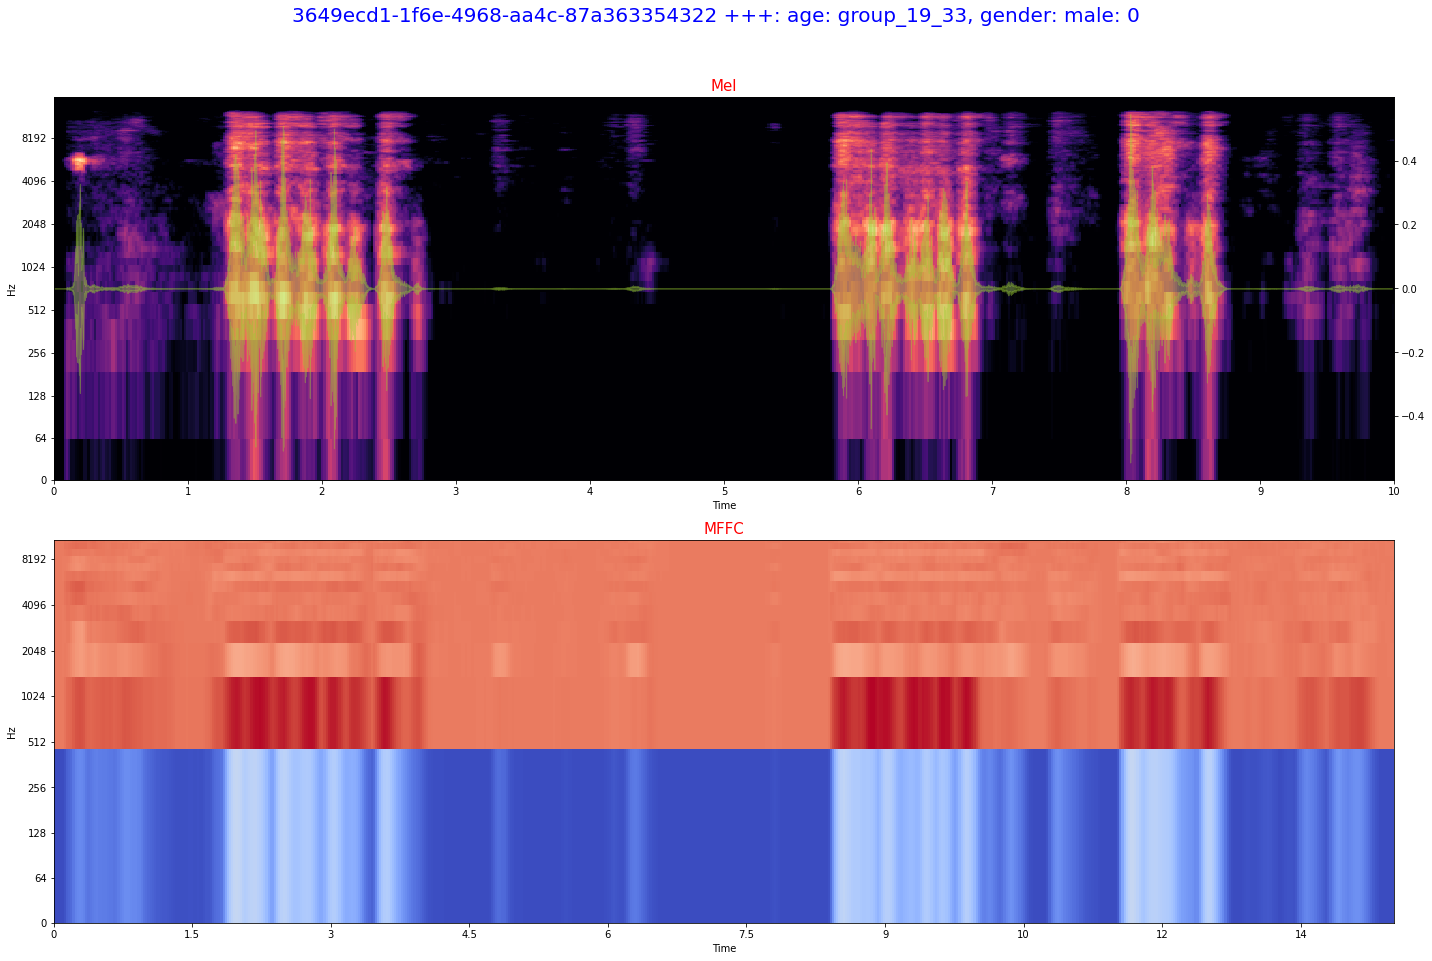

----------------------------------------------------------------------------------------------------


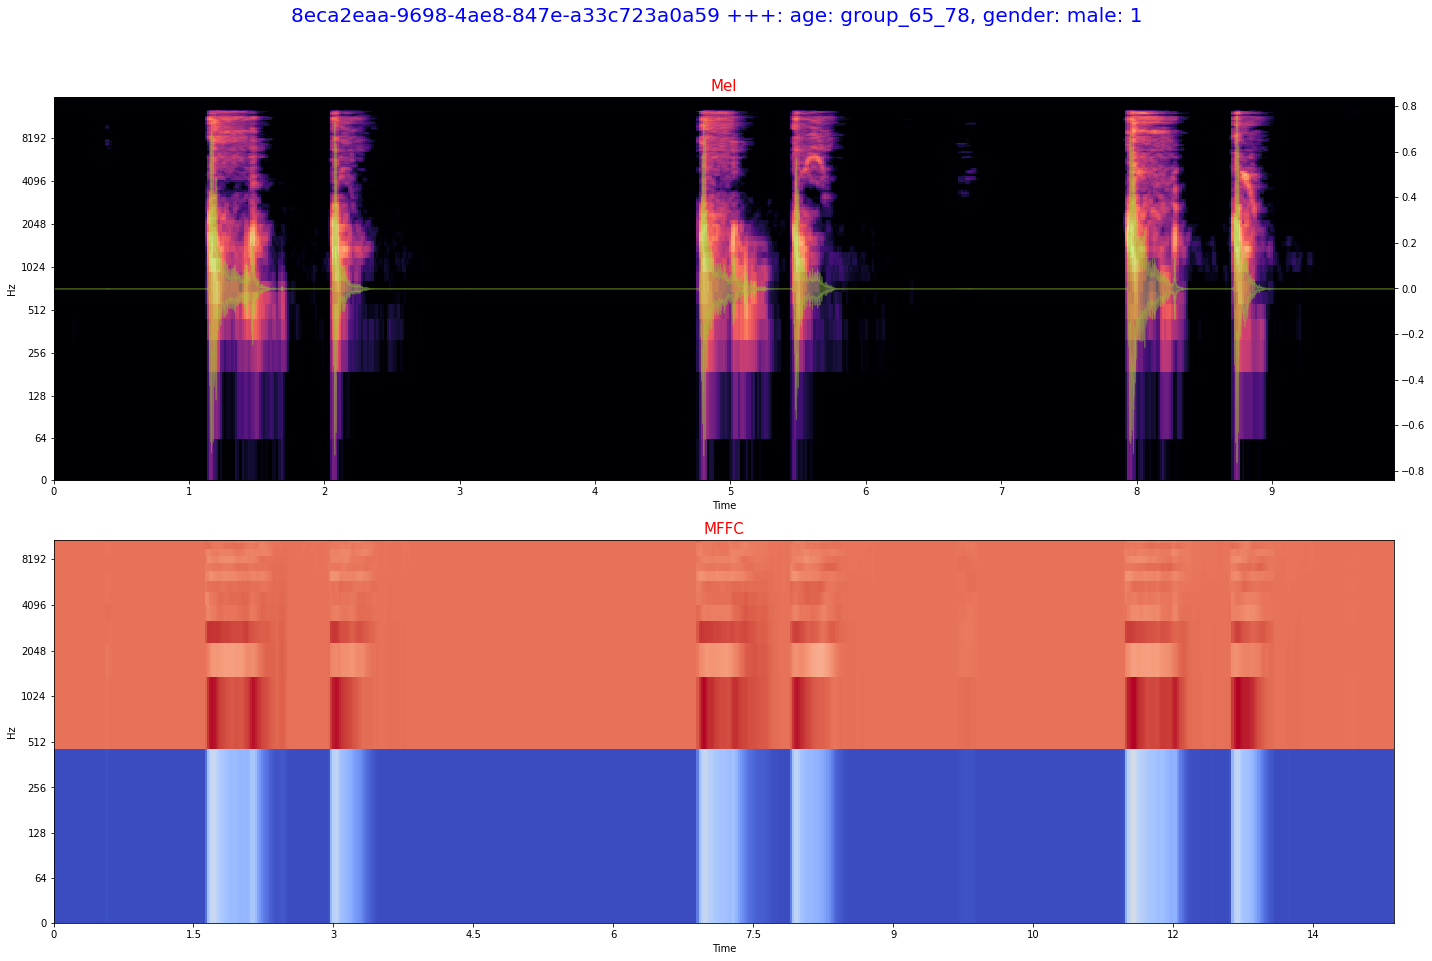

In [20]:
def audio_map(df, num_audio=5):
    for case in [0, 1]:
        for i in range(num_audio):
            print(100*'-')
            rand_audio = random.choice(df[df.assessment_result==case].index)
            rand_df = df.loc[rand_audio, :]
            age, gender, file_path = rand_df.subject_age, rand_df.subject_gender, rand_df.file_path
            uuid = rand_df.uuid
            display(Audio(data=file_path, autoplay=False))
            
            y, sr = librosa.load(file_path, sr=SR, duration=20)
            S = melspectrogram(y, sr=sr, n_mels=128)
            log_s = librosa.power_to_db(S, ref=np.max)
            
            fig, ax = plt.subplots(2, 1, figsize=(20, 14))
        
            ax0 = ax[0].twinx()
            waveplot(y, sr, color='yellowgreen', alpha=0.4, ax=ax0)
            specshow(log_s, sr=sr, x_axis='time', y_axis='log', ax=ax[0])
            ax[0].set_title('Mel', color='r', fontsize=15)
            
            mfcc_ = mfcc(S=log_s, n_mfcc=13)
            delta_mffc = delta(mfcc_)
            delta_mffc2 = delta(mfcc_, order=2)

            specshow(mfcc_, x_axis='time', y_axis='log', ax=ax[1])
            ax[1].set_title('MFFC', color='r', fontsize=15)
            
            plt.suptitle(f'{uuid} +++: age: {age}, gender: {gender}: {case}',
                         fontsize=20, color='b')
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])  
            
            plt.show()
            
audio_map(train_df, 1)

# Clean audio

----------------------------------------------------------------------------------------------------


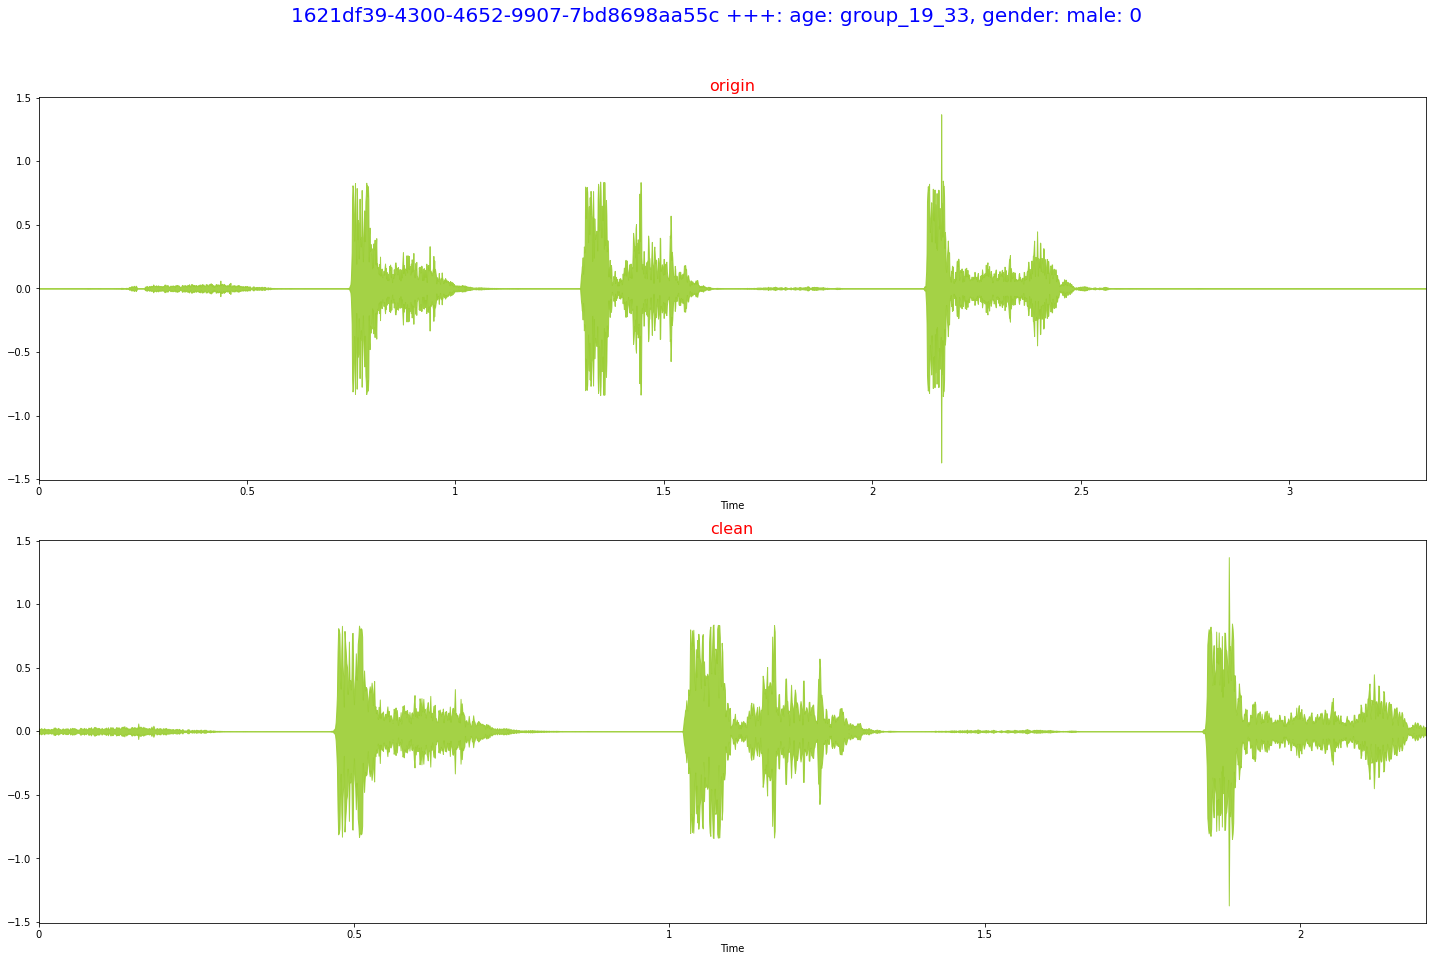

----------------------------------------------------------------------------------------------------


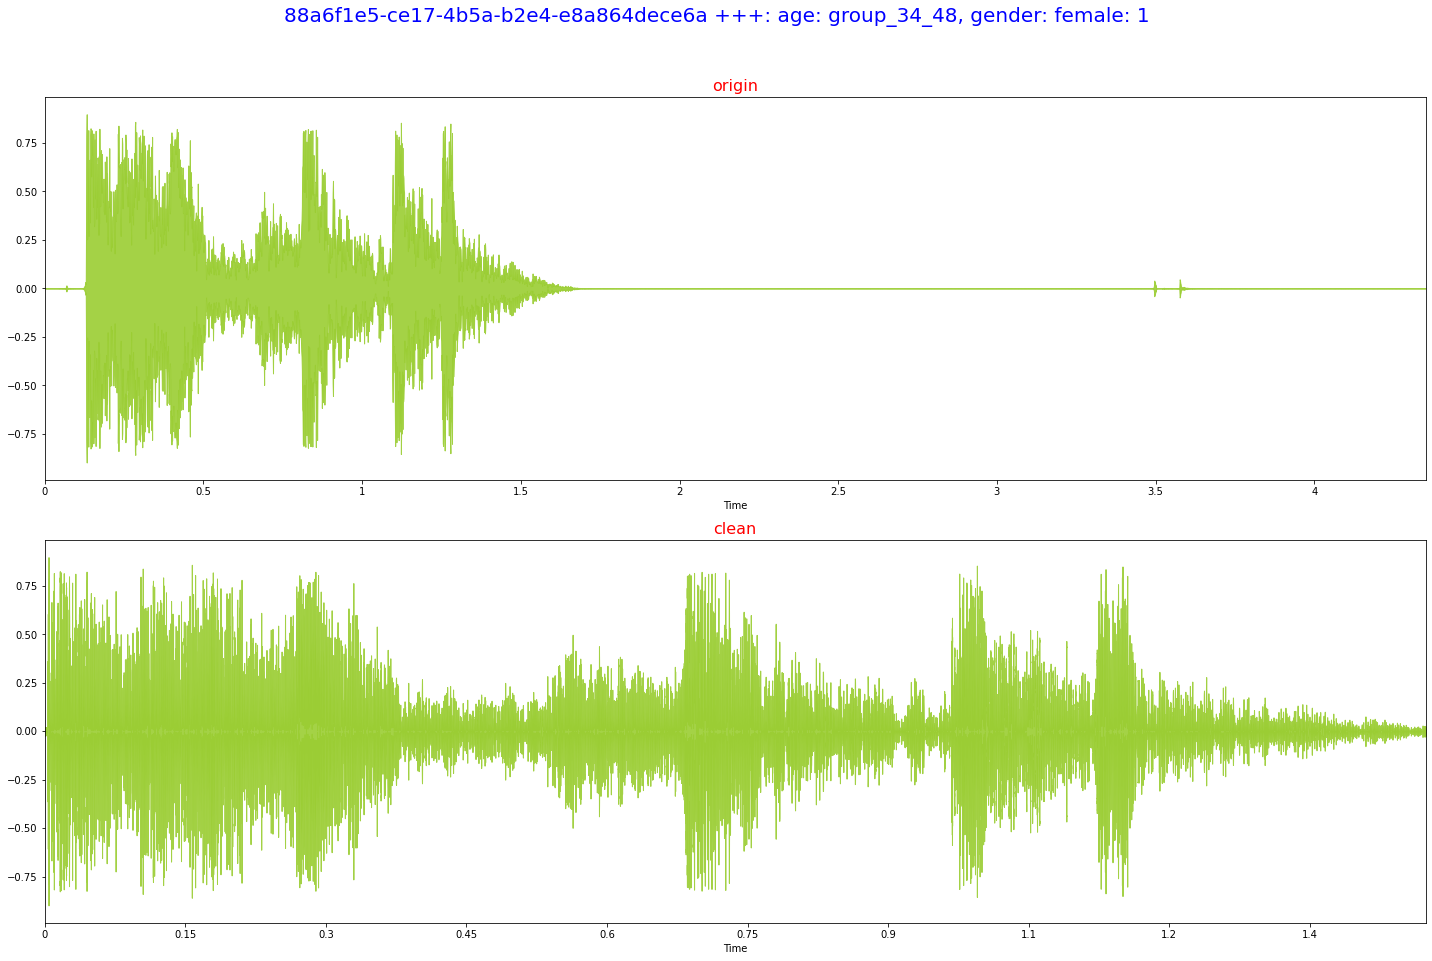

In [21]:
def ExampleClean(df, num_audio=5, threshold=0.1):
    for case in [0, 1]:
        for i in range(num_audio):
            print(100*'-')
            rand_audio = random.choice(df[df.assessment_result==case].index)
            rand_df = df.loc[rand_audio, :]
            age, gender, file_path = rand_df.subject_age, rand_df.subject_gender, rand_df.file_path
            uuid = rand_df.uuid
            file_path = rand_df.file_path
            y, sr = librosa.load(file_path, sr=SR)
            y_clean = removeNoise(y, threshold=threshold)

            fig, ax = plt.subplots(2, 1, figsize=(20, 14))

            waveplot(y, sr, color='yellowgreen', alpha=0.9, ax=ax[0])
            ax[0].set_title('origin', color='r', fontsize=16)
            
            waveplot(y_clean, sr, color='yellowgreen', alpha=0.9, ax=ax[1])
            ax[1].set_title('clean', color='r', fontsize=16)
            
            plt.suptitle(f'{uuid} +++: age: {age}, gender: {gender}: {case}',
                         fontsize=20, color='b')
            fig.tight_layout(rect=[0, 0.03, 1, 0.95])  
            
            plt.show()
            

            
ExampleClean(train_df, num_audio=1, threshold=0.1)

# Dataset

In [22]:
class AudioTransform(BasicTransform):
    """Transform for Audio task"""

    @property
    def targets(self):
        return {"data": self.apply}
    
    def update_params(self, params, **kwargs):
        if hasattr(self, "interpolation"):
            params["interpolation"] = self.interpolation
        if hasattr(self, "fill_value"):
            params["fill_value"] = self.fill_value
        return params

    
    
class AddGaussianNoise(AudioTransform):
    """Shifting time axis"""
    def __init__(self, min_amplitude=0.0001, max_amplitude=0.0015, always_apply=False, p=0.5):
        super(AddGaussianNoise, self).__init__(always_apply, p)
        
        self.min_amplitude = min_amplitude
        self.max_amplitude = max_amplitude
    
    def apply(self, data, **params):
        noise = np.random.randn(len(data))
        data_wn = data + random.uniform(self.min_amplitude, self.max_amplitude)*noise
        
        return data_wn

    
    
class TimeShifting(AudioTransform):
    """ Do time shifting of audio """
    def __init__(self, fraction=0.5, always_apply=False, p=0.5):
        super(TimeShifting, self).__init__(always_apply, p)
        
        self.fraction = fraction
        assert self.fraction > 0
        
    def apply(self,data,**params):
        '''
        data : ndarray of audio timeseries
        '''        
        num_place_to_shift = int(random.uniform(-self.fraction, self.fraction)*len(data))
        data_shift = np.roll(data, num_place_to_shift)
        if num_place_to_shift > 0:
            data_shift[:num_place_to_shift] = 0
        else:
            data_shift[num_place_to_shift:] = 0
        
        return data_shift
    
    

    
class SpeedTuning(AudioTransform):
    """ Do speed Tuning of audio """
    def __init__(self, always_apply=False, p=0.5,speed_rate = None):
        '''
        Give Rate between (0.5,1.5) for best results
        '''
        super(SpeedTuning, self).__init__(always_apply, p)
        
        if speed_rate:
            self.speed_rate = speed_rate
        else:
            self.speed_rate = np.random.uniform(0.6,1.3)
        
    def apply(self,data,**params):
        '''
        data : ndarray of audio timeseries
        '''        
        audio_speed_tune = cv2.resize(data, (1, int(len(data) * self.speed_rate))).squeeze()
        if len(audio_speed_tune) < len(data) :
            pad_len = len(data) - len(audio_speed_tune)
            audio_speed_tune = np.r_[np.random.uniform(-0.001,0.001,int(pad_len/2)),
                                   audio_speed_tune,
                                   np.random.uniform(-0.001,0.001,int(np.ceil(pad_len/2)))]
        else: 
            cut_len = len(audio_speed_tune) - len(data)
            audio_speed_tune = audio_speed_tune[int(cut_len/2):int(cut_len/2)+len(data)]
        
        return audio_speed_tune
    
    
    
class StretchAudio(AudioTransform):
    """ Do stretching of audio file"""
    def __init__(self, always_apply=False, p=0.5 , rate = None):
        super(StretchAudio, self).__init__(always_apply, p)
        
        if rate:
            self.rate = rate
        else:
            self.rate = np.random.uniform(0.5,1.5)
        
    def apply(self,data,**params):
        '''
        data : ndarray of audio timeseries
        '''        
        input_length = len(data)
        
        data = librosa.effects.time_stretch(data, self.rate)
        
        if len(data)>input_length:
            data = data[:input_length]
        else:
            data = np.pad(data, (0, max(0, input_length - len(data))), "constant")

        return data
    
    

class PitchShift(AudioTransform):
    """ Do time shifting of audio """
    def __init__(self, always_apply=False, p=0.5 , n_steps=None):
        super(PitchShift, self).__init__(always_apply, p)
        '''
        nsteps here is equal to number of semitones
        '''
        
        self.n_steps = n_steps
        
    def apply(self,data,**params):
        '''
        data : ndarray of audio timeseries
        '''        
        return librosa.effects.pitch_shift(data,sr=SR,n_steps=self.n_steps)
    
    

class AddCustomNoise(AudioTransform):
    """
    This Function allows you to add noise from any custom file you want just give path to the directory where the files
    are stored and you are good to go.
    """
    def __init__(self,file_dir, always_apply=False, p=0.5):
        super(AddCustomNoise, self).__init__(always_apply, p)
        '''
        file_dir must be of form '.../input/.../something'
        '''
        
        self.noise_files = glob(file_dir+'/*')
        
    def apply(self,data,**params):
        '''
        data : ndarray of audio timeseries
        ''' 
        nf = random.choice(self.noise_files)
        
        noise,_ = librosa.load(nf, sr=SR, duration=PERIOD)
        
        if len(noise)>len(data):
            start_ = np.random.randint(len(noise)-len(data))
            noise = noise[start_ : start_+len(data)] 
        else:
            noise = np.pad(noise, (0, len(data)-len(noise)), "constant")
            
        data_wn = data + noise

        return data_wn
    
    

class PolarityInversion(AudioTransform):
    def __init__(self, always_apply=False, p=0.5 ):
        super(PolarityInversion, self).__init__(always_apply, p)
        
    def apply(self,data,**params):
        '''
        data : ndarray of audio timeseries
        '''
        return -data
    
    

class Gain(AudioTransform):
    """
    Multiply the audio by a random amplitude factor to reduce or increase the volume. This
    technique can help a model become somewhat invariant to the overall gain of the input audio.
    """

    def __init__(self, min_gain_in_db=-12, max_gain_in_db=12, always_apply=False,p=0.5):
        super(Gain,self).__init__(always_apply,p)
        assert min_gain_in_db <= max_gain_in_db
        self.min_gain_in_db = min_gain_in_db
        self.max_gain_in_db = max_gain_in_db


    def apply(self, data, **args):
        amplitude_ratio = 10**(random.uniform(self.min_gain_in_db, self.max_gain_in_db)/20)
        return data * amplitude_ratio
    
    
    
class CutOut(AudioTransform):
    def __init__(self, always_apply=False, p=0.5 ):
        super(CutOut, self).__init__(always_apply, p)
        
    def apply(self,data,**params):
        '''
        data : ndarray of audio timeseries
        '''
        start_ = np.random.randint(0,len(data))
        end_ = np.random.randint(start_,len(data))
        
        data[start_:end_] = 0
        
        return data

In [23]:
def aug(sub='train'):
    if sub=='train':
        return al.Compose([
            SpeedTuning(p=0.5),
            TimeShifting(p=0.5),
            AddGaussianNoise(p=0.5),
            Gain(p=0.5),
            PolarityInversion(p=0.5),
            CutOut(p=0.01),
        ])
    elif sub=='validation':
        return al.Compose([
            AddGaussianNoise(p=0.5),
        ])
    elif sub=='test':
        return al.Compose([
            AddGaussianNoise(p=0.5),
        ])

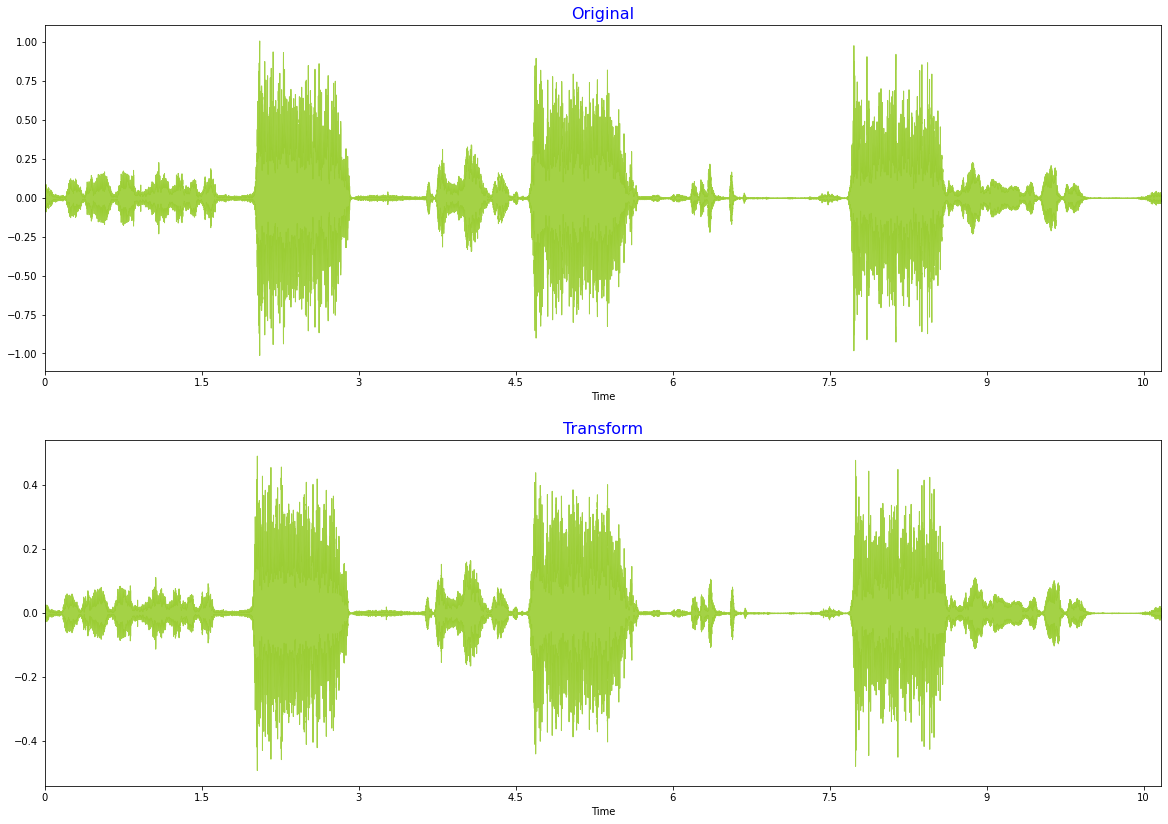

CPU times: user 624 ms, sys: 15.9 ms, total: 640 ms
Wall time: 614 ms


46169

In [24]:
%%time

file = random.choice(train_df.file_path)
y, sr = librosa.load(file, sr=SR)

fig, ax = plt.subplots(2, 1, figsize=(20, 14))

waveplot(y, sr, color='yellowgreen', alpha=0.9, ax=ax[0])
ax[0].set_title('Original', fontsize=16, color='b')
waveplot(aug('train')(data=y)['data'], sr, color='yellowgreen', alpha=0.9, ax=ax[1])
ax[1].set_title('Transform', fontsize=16, color='b')
plt.show()

del file, y
gc.collect()

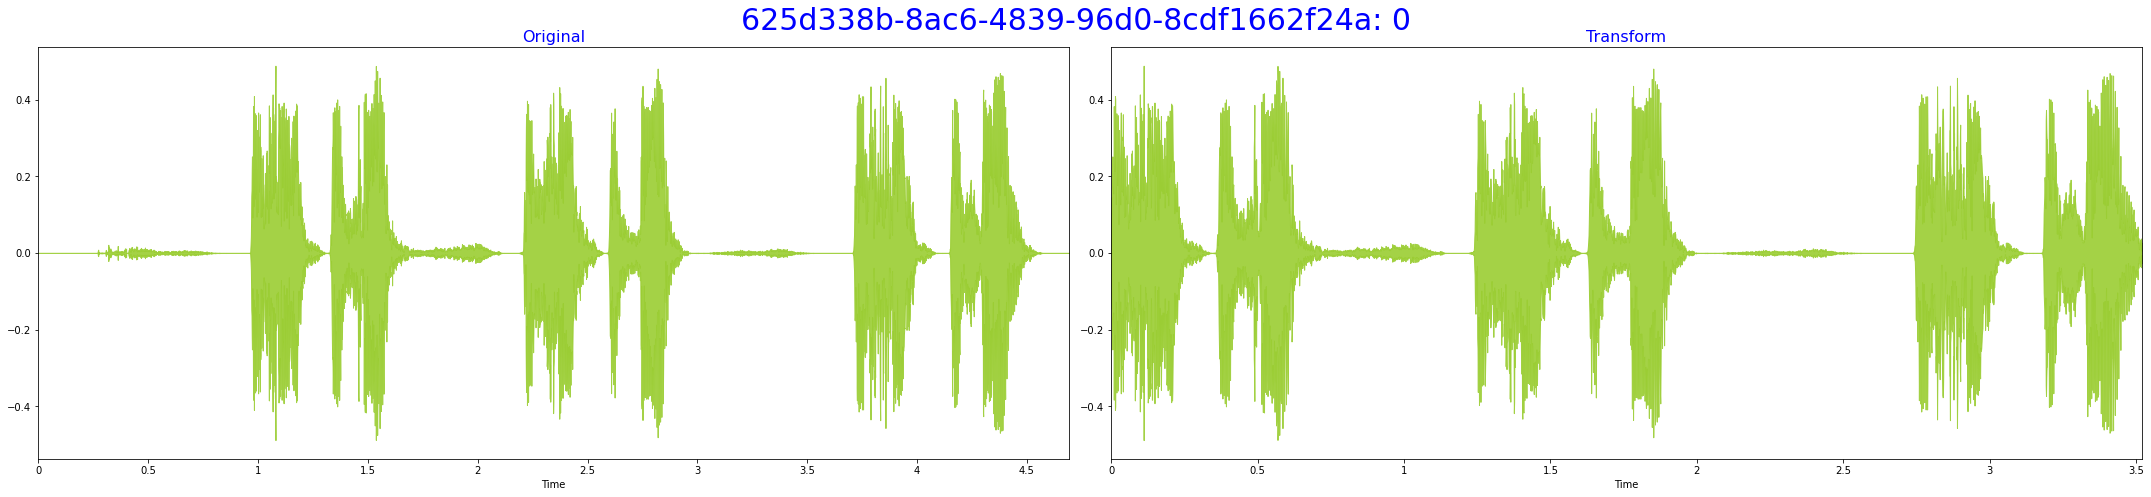

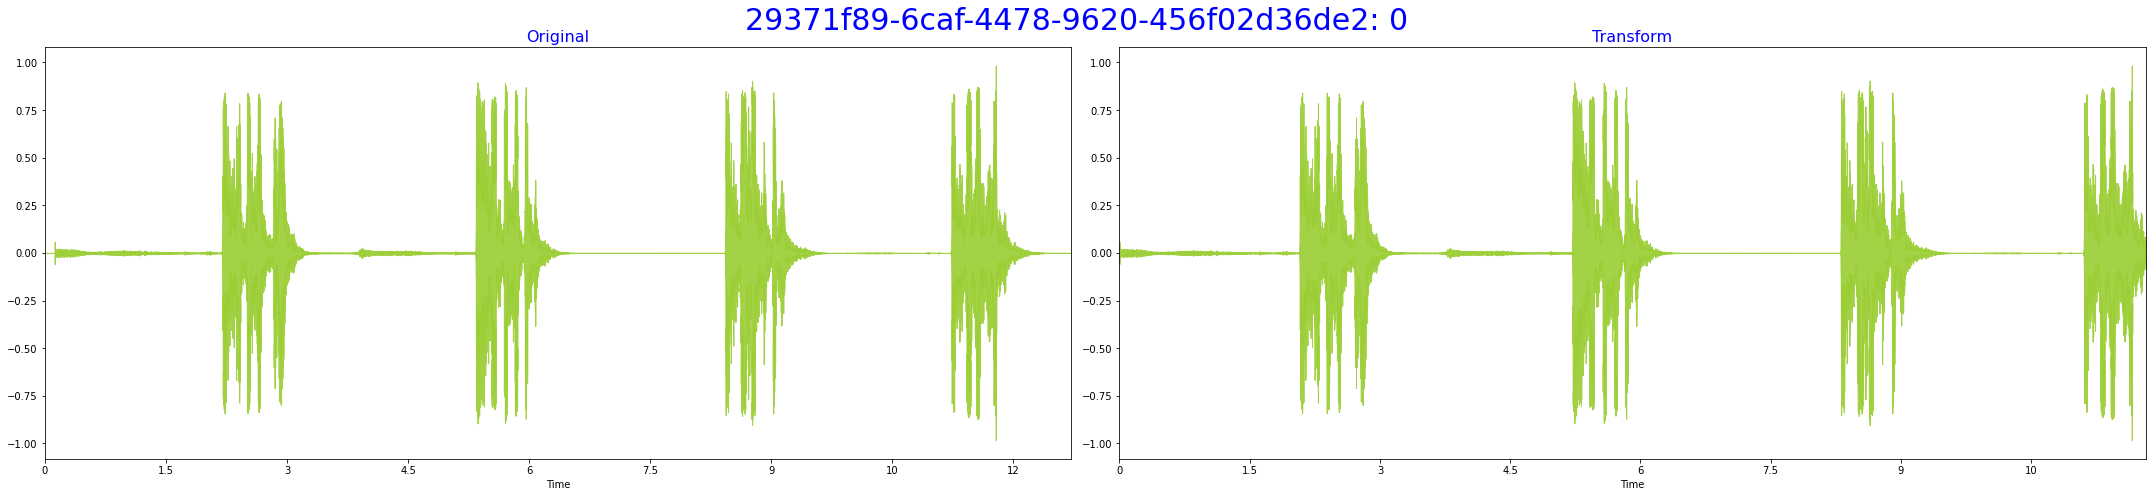

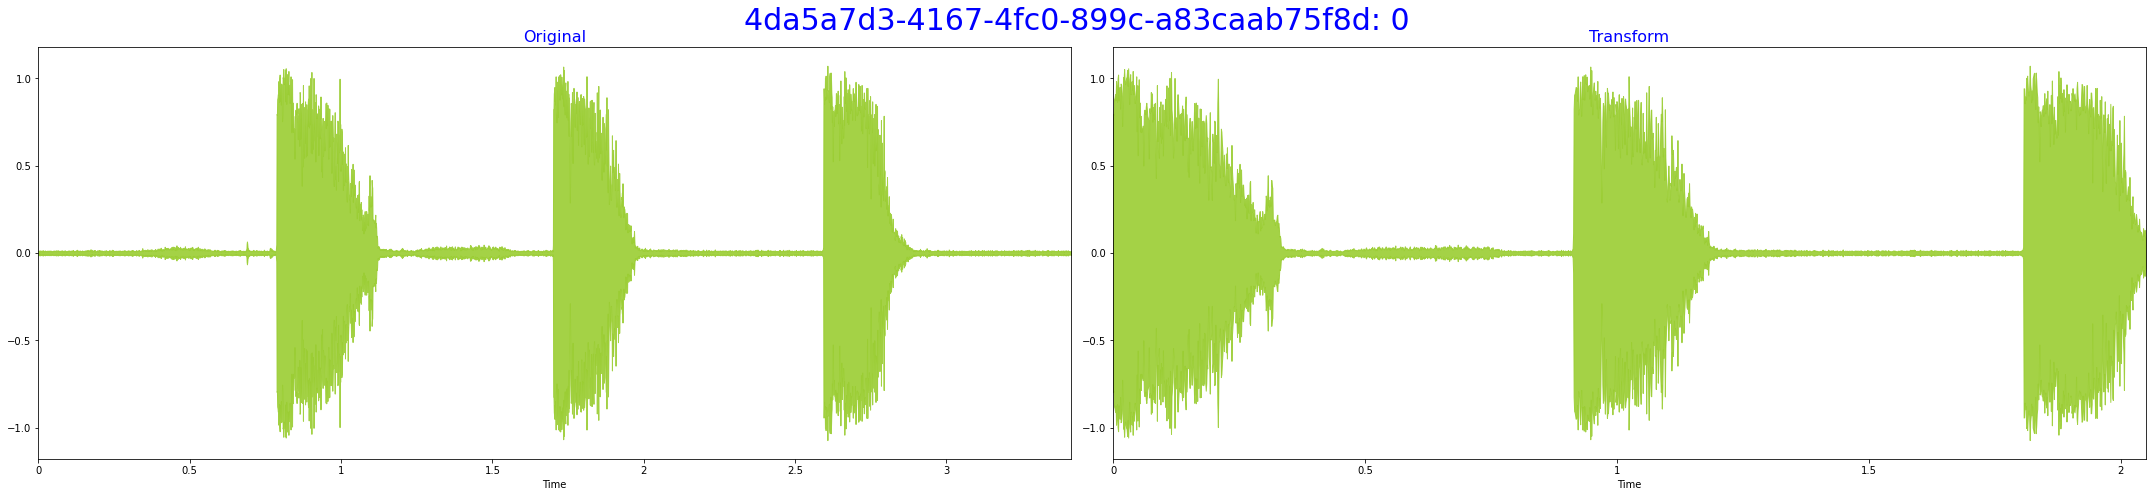

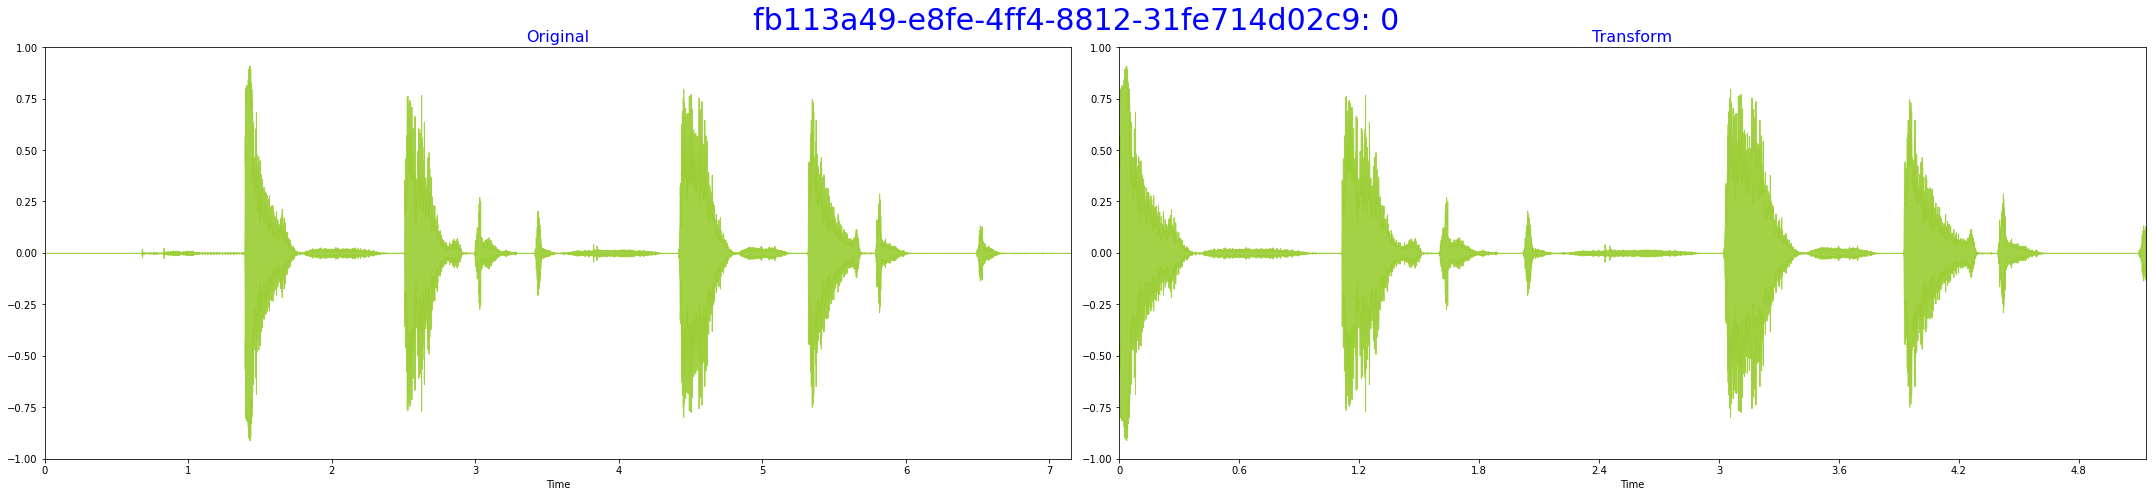

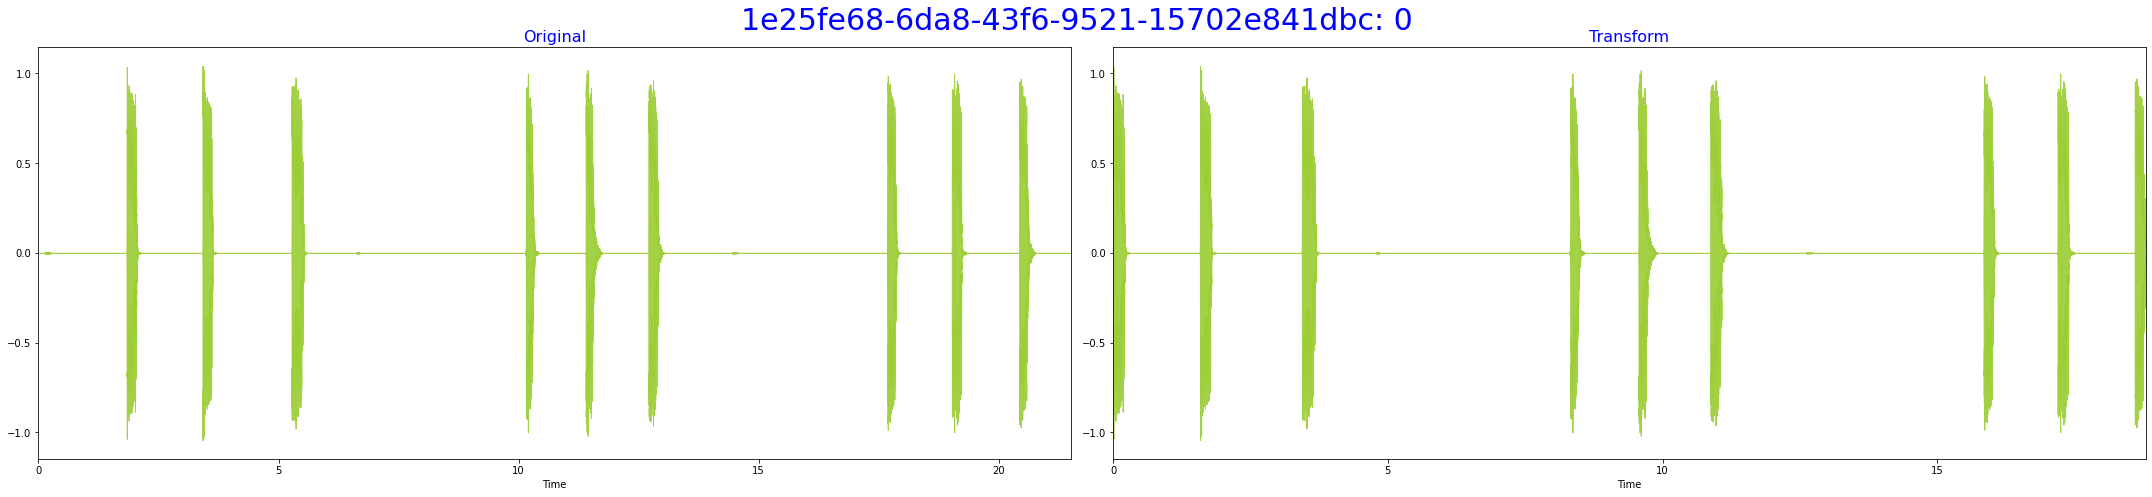

In [25]:
for idx, row in train_df.sample(5).iterrows():
    uuid, start, end, label, file = row[['uuid', 'start', 'end', 'assessment_result', 'file_path']]
    y, sr = librosa.load(file, sr=SR)
    y_clean = removeNoise(y, window=10, threshold=1/2*np.max(y))
    
    fig, ax = plt.subplots(1, 2, figsize=(30, 7))
    waveplot(y, sr, color='yellowgreen', alpha=0.9, ax=ax[0])
    ax[0].set_title('Original', fontsize=16, color='b')
    waveplot(y_clean, sr, color='yellowgreen', alpha=0.9, ax=ax[1])
    ax[1].set_title('Transform', fontsize=16, color='b')
    plt.tight_layout()
    plt.suptitle(f"{uuid}: {label}", fontsize=30, color='b')
    fig.subplots_adjust(top=0.9)
    plt.show()

In [30]:
class DatasetConfig:
    sr = SR
    period = 10
    max_length = 384
    threshold = 0.1
    melspectrogram_config = {'sr': SR,
                             'verbose': False,
                             'hop_length': 256,
                             'n_fft': 1024,
                             'n_mels': 32,
                             'fmin': 20,
                             'fmax': 20000}
    mfcc_config = {'sr': SR,
                   'verbose': False,
                   'n_mfcc': 256}
    cqt_config = {'sr': SR,
                  'verbose': False,
                  'hop_length': 512,
                  'bins_per_octave': 12,
                  'fmin': 20,
                  'fmax': None}
    
    
class CovidDataset(Dataset):
    def __init__(self, df, config, meta_col, sub='train', has_transform=True):
        super(CovidDataset, self).__init__()
        
        assert sub in ['train', 'validation', 'test']
        
        self.df = df
        self.config = config
        self.meta_col = meta_col
        self.sub = sub
        self.has_transform = has_transform
        if self.has_transform:
            self.transform = aug(self.sub)
            
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        path = self.df.loc[idx, 'file_path']
        y, sr = librosa.load(path, sr=self.config.sr)
        start, end = self.df.loc[idx, ['start', 'end']]
        
        if end > start:
            y_clean = y[start:end]
        else:
            y_clean = y
        if np.max(y_clean)>0:
            y_clean /= np.max(y_clean)
        
        if self.has_transform:
            new_y = self.transform(data=y_clean)['data']
        else:
            new_y = y_clean
        new_y = torch.from_numpy(new_y).float()
        
        mf = MFCC(**self.config.mfcc_config)(new_y)  
        mf = fix_length(mf.detach().cpu().numpy(), self.config.max_length)
        mf = torch.tensor(mf).float()
        
        S = MelSpectrogram(**self.config.melspectrogram_config)(new_y)   
        mel = power_to_db(S, ref=np.max)
        mel = mono_to_color(mel)/255
        mel = fix_length(mel, self.config.max_length)
        mel = torch.tensor(mel).float()
        
        if self.sub != 'test':
            label = self.df.loc[idx, 'assessment_result']
            meta_data = torch.tensor(self.df.loc[idx, self.meta_col].astype(np.float32))
            label = torch.tensor([1-label, label]).to(torch.float32)
            return mf, mel, meta_data, label
        return mf, mel, None
    
    def collate_fn(self, batch):
        mf = torch.stack([i[0] for i in batch])
        mel = torch.stack([i[1] for i in batch])
        if self.sub != 'test':
            meta_data = torch.stack([i[2] for i in batch])
            label = torch.stack([i[3] for i in batch])
            return mf, mel, meta_data, label
        return mf, mel, None

torch.Size([4, 1, 128, 384]) torch.Size([4, 1, 32, 384])


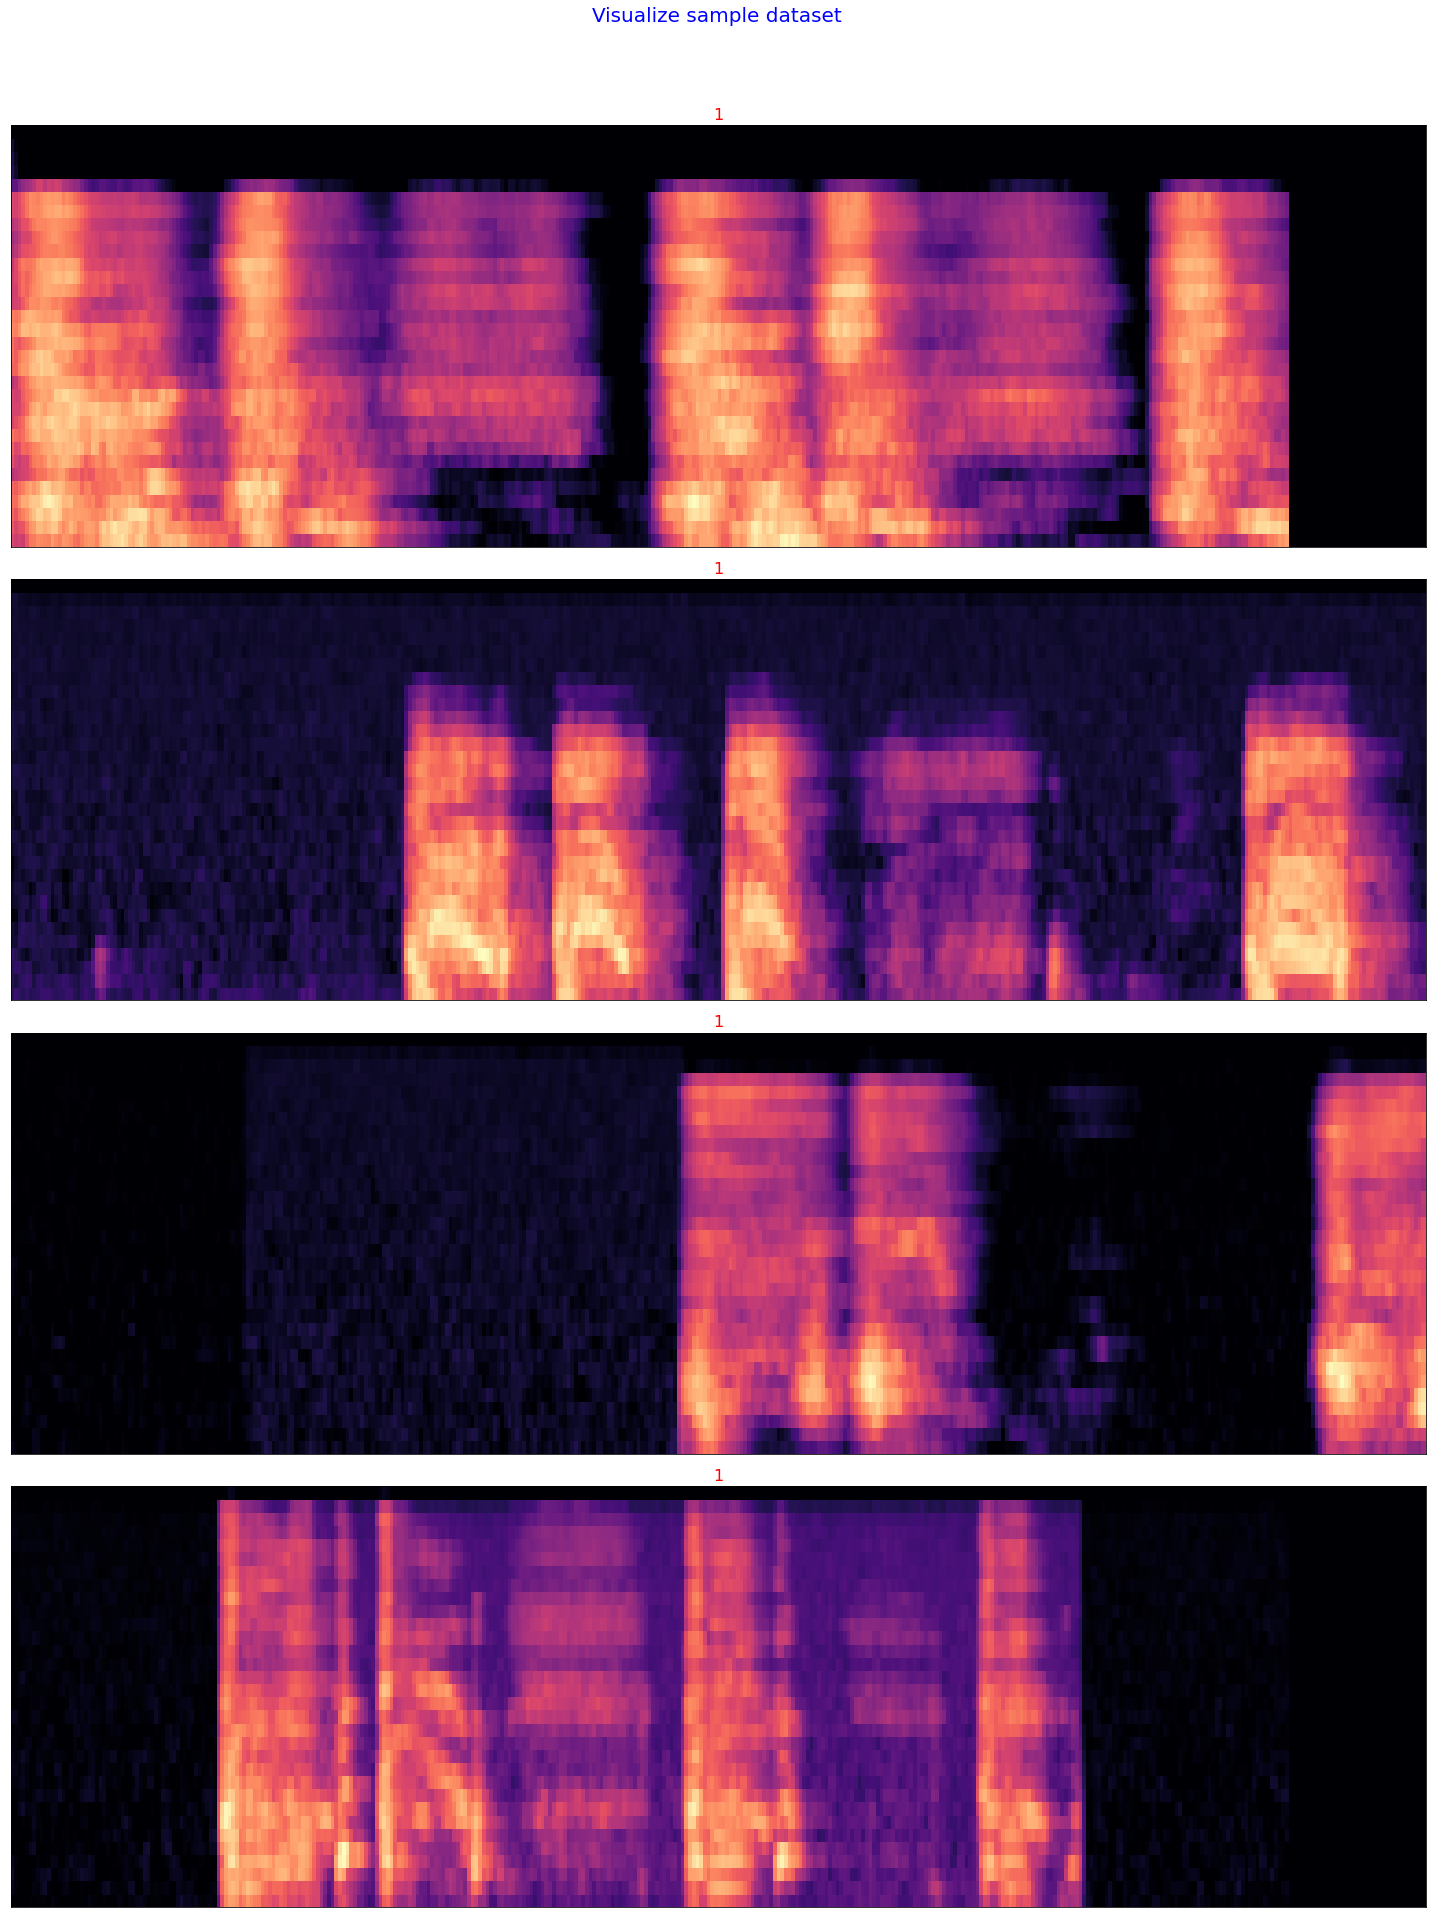

CPU times: user 3.53 s, sys: 148 ms, total: 3.68 s
Wall time: 1.54 s


7020

In [31]:
%%time

batch_size = 4
train_data = train_df[train_df['assessment_result']!=0].reset_index(drop=True)
ds = CovidDataset(train_data, DatasetConfig, meta_col)
dl = DataLoader(ds, shuffle=False, batch_size=batch_size, collate_fn=ds.collate_fn)
mf, mel, meta_data, label = next(iter(dl))
print(mf.shape, mel.shape)
fig, ax = plt.subplots(batch_size, 1, figsize=(20, 7*batch_size))
mel = mel.detach().cpu().numpy()
for i in range(mel.shape[0]):
    specshow(mel[i][0], ax=ax[i])
    ax[i].set_title(int(label[i, 1].item()), color='r', fontsize=16)

plt.suptitle(f'Visualize sample dataset', fontsize=20, color='b')
fig.tight_layout(rect=[0, 0.03, 1, 0.95])  

plt.show()

del ds, dl, mf, mel, label
gc.collect()

# Model

## Loss

In [20]:
class BCEFocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, weight=None):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.weight = weight

    def forward(self, preds, targets):
        bce_loss = nn.BCELoss(weight=self.weight)(preds, targets)
        loss = targets * self.alpha * \
            (1. - preds)**self.gamma * bce_loss + \
            (1. - targets) * preds**self.gamma * bce_loss
        loss = loss.mean()
        return loss
    

class criterionLoss(nn.Module):
    def __init__(self, use_focal=False, weight=None):
        super(criterionLoss, self).__init__()
        self.use_focal = use_focal
        self.weight = weight
    def forward(self, output, label):
        output = output.squeeze()
        if self.use_focal:
            loss_fn = BCEFocalLoss(weight=self.weight)
        else:
            loss_fn = nn.BCELoss(weight=self.weight)
        return loss_fn(output, label.float())
    

def mixup_data(x, y, alpha=1.0):
    '''Returns mixed inputs, pairs of targets, and lambda'''
    if alpha > 0:
        lam = np.random.beta(alpha, alpha)
    else:
        lam = 1

    batch_size = y.size()[0]
    index = torch.randperm(batch_size).to(device)

    mixed_x = lam * x + (1 - lam) * x[index, :]
    y_a, y_b = y, y[index]
    return mixed_x, y_a, y_b, lam


def mixup_criterion(criterion, pred, y_a, y_b, lam):
    return lam * criterion(pred, y_a) + (1 - lam) * criterion(pred, y_b)

## Scheduler

In [21]:
if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any


class MADGRAD(torch.optim.Optimizer):
    """
    MADGRAD_: A Momentumized, Adaptive, Dual Averaged Gradient Method for Stochastic 
    Optimization.
    .. _MADGRAD: https://arxiv.org/abs/2101.11075
    MADGRAD is a general purpose optimizer that can be used in place of SGD or
    Adam may converge faster and generalize better. Currently GPU-only.
    Typically, the same learning rate schedule that is used for SGD or Adam may
    be used. The overall learning rate is not comparable to either method and
    should be determined by a hyper-parameter sweep.
    MADGRAD requires less weight decay than other methods, often as little as
    zero. Momentum values used for SGD or Adam's beta1 should work here also.
    On sparse problems both weight_decay and momentum should be set to 0.
    Arguments:
        params (iterable): 
            Iterable of parameters to optimize or dicts defining parameter groups.
        lr (float): 
            Learning rate (default: 1e-2).
        momentum (float): 
            Momentum value in  the range [0,1) (default: 0.9).
        weight_decay (float): 
            Weight decay, i.e. a L2 penalty (default: 0).
        eps (float): 
            Term added to the denominator outside of the root operation to improve numerical stability. (default: 1e-6).
    """

    def __init__(
        self, params: _params_t, lr: float = 1e-2,
        momentum: float = 0.9, weight_decay: float = 0,
        eps: float = 1e-6,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1]")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:
        """Performs a single optimization step.
        Arguments:
            closure (callable, optional): A closure that reevaluates the model
                and returns the loss.
        """
        loss = None
        if closure is not None:
            loss = closure()

        # step counter must be stored in state to ensure correct behavior under
        # optimizer sharding
        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)


        self.state['k'] += 1
        return loss
    

    
    
class GradualWarmupSchedulerV2(GradualWarmupScheduler):
    def __init__(self, optimizer, multiplier, total_epoch, after_scheduler=None):
        super(GradualWarmupSchedulerV2, self).__init__(optimizer, multiplier, total_epoch, after_scheduler)

    def get_lr(self):
        if self.last_epoch > self.total_epoch:
            if self.after_scheduler:
                if not self.finished:
                    self.after_scheduler.base_lrs = [base_lr * self.multiplier for base_lr in self.base_lrs]
                    self.finished = True
                return self.after_scheduler.get_lr()
            return [base_lr * self.multiplier for base_lr in self.base_lrs]
        if self.multiplier == 1.0:
            return [base_lr * (float(self.last_epoch) / self.total_epoch) for base_lr in self.base_lrs]
        else:
            return [base_lr * ((self.multiplier - 1.) * self.last_epoch / self.total_epoch + 1.) for base_lr in
                    self.base_lrs]

In [22]:
def init_layer(layer):
    nn.init.xavier_uniform_(layer.weight)

    if hasattr(layer, "bias"):
        if layer.bias is not None:
            layer.bias.data.fill_(0.)


def init_bn(bn):
    bn.bias.data.fill_(0.)
    bn.weight.data.fill_(1.0)


def init_weights(model):
    classname = model.__class__.__name__
    if classname.find("Conv2d") != -1:
        nn.init.xavier_uniform_(model.weight, gain=np.sqrt(2))
        model.bias.data.fill_(0)
    elif classname.find("BatchNorm") != -1:
        model.weight.data.normal_(1.0, 0.02)
        model.bias.data.fill_(0)
    elif classname.find("GRU") != -1:
        for weight in model.parameters():
            if len(weight.size()) > 1:
                nn.init.orghogonal_(weight.data)
    elif classname.find("Linear") != -1:
        model.weight.data.normal_(0, 0.01)
        model.bias.data.zero_()


class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels):
        
        super(ConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(in_channels=in_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.conv2 = nn.Conv2d(in_channels=out_channels, 
                              out_channels=out_channels,
                              kernel_size=(3, 3), stride=(1, 1),
                              padding=(1, 1), bias=False)
                              
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.init_weight()
        
    def init_weight(self):
        init_layer(self.conv1)
        init_layer(self.conv2)
        init_bn(self.bn1)
        init_bn(self.bn2)

        
    def forward(self, input, pool_size=(2, 2), pool_type='avg'):
        
        x = input
        x = F.relu_(self.bn1(self.conv1(x)))
        x = F.relu_(self.bn2(self.conv2(x)))
        if pool_type == 'max':
            x = F.max_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg':
            x = F.avg_pool2d(x, kernel_size=pool_size)
        elif pool_type == 'avg+max':
            x1 = F.avg_pool2d(x, kernel_size=pool_size)
            x2 = F.max_pool2d(x, kernel_size=pool_size)
            x = x1 + x2
        else:
            raise Exception('Incorrect argument!')
        
        return x
    
    
def do_mixup(x: torch.Tensor, mixup_lambda: torch.Tensor):
    """Mixup x of even indexes (0, 2, 4, ...) with x of odd indexes
    (1, 3, 5, ...).
    Args:
      x: (batch_size * 2, ...)
      mixup_lambda: (batch_size * 2,)
    Returns:
      out: (batch_size, ...)
    """
    out = (x[0::2].transpose(0, -1) * mixup_lambda[0::2] +
           x[1::2].transpose(0, -1) * mixup_lambda[1::2]).transpose(0, -1)
    return out


class Mixup(object):
    def __init__(self, mixup_alpha, random_seed=1234):
        """Mixup coefficient generator.
        """
        self.mixup_alpha = mixup_alpha
        self.random_state = np.random.RandomState(random_seed)

    def get_lambda(self, batch_size):
        """Get mixup random coefficients.
        Args:
          batch_size: int
        Returns:
          mixup_lambdas: (batch_size,)
        """
        mixup_lambdas = []
        for n in range(0, batch_size, 2):
            lam = self.random_state.beta(
                self.mixup_alpha, self.mixup_alpha, 1)[0]
            mixup_lambdas.append(lam)
            mixup_lambdas.append(1. - lam)

        return torch.from_numpy(np.array(mixup_lambdas, dtype=np.float32))


def interpolate(x: torch.Tensor, ratio: int):
    """Interpolate data in time domain. This is used to compensate the
    resolution reduction in downsampling of a CNN.
    Args:
      x: (batch_size, time_steps, classes_num)
      ratio: int, ratio to interpolate
    Returns:
      upsampled: (batch_size, time_steps * ratio, classes_num)
    """
    (batch_size, time_steps, classes_num) = x.shape
    upsampled = x[:, :, None, :].repeat(1, 1, ratio, 1)
    upsampled = upsampled.reshape(batch_size, time_steps * ratio, classes_num)
    return upsampled


def pad_framewise_output(framewise_output: torch.Tensor, frames_num: int):
    """Pad framewise_output to the same length as input frames. The pad value
    is the same as the value of the last frame.
    Args:
      framewise_output: (batch_size, frames_num, classes_num)
      frames_num: int, number of frames to pad
    Outputs:
      output: (batch_size, frames_num, classes_num)
    """
    output = F.interpolate(
        framewise_output.unsqueeze(1),
        size=(frames_num, framewise_output.size(2)),
        align_corners=True,
        mode="bilinear").squeeze(1)

    return output


def gem(x: torch.Tensor, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1. / p)


class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)

    def __repr__(self):
        return self.__class__.__name__ + f"(p={self.p.data.tolist()[0]:.4f}, eps={self.eps})"

In [23]:
class MfccNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=2):
        super(MfccNet, self).__init__()
        self.conv = nn.Sequential(nn.Conv2d(in_channels, 64, kernel_size=3,
                                             padding=1, stride=1),
                                  nn.BatchNorm2d(64),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(0.2),
                                  nn.Conv2d(64, 128, kernel_size=3,
                                            padding=1, stride=1),
                                  nn.BatchNorm2d(128),
                                  nn.ReLU(inplace=True),
                                  nn.Dropout(0.2),
                                  nn.Conv2d(128, 128, kernel_size=3,
                                             padding=1, stride=1),
                                   nn.BatchNorm2d(128))
        self.fc = nn.Sequential(nn.Flatten(),
                                nn.Linear(128, 64),
                                nn.BatchNorm1d(64),
                                nn.ReLU(inplace=True),
                                nn.Dropout(0.5),
                                nn.Linear(64, out_channels))
        
    def forward(self, x):
        out = self.conv(x)
        out1 = F.adaptive_avg_pool2d(out, 1)
        out2 = F.adaptive_max_pool2d(out, 1)
        out = out1 + out2
        out = self.fc(out)
        
        return out
    
def gem(x: torch.Tensor, p=3, eps=1e-6):
    return F.avg_pool2d(x.clamp(min=eps).pow(p), (x.size(-2), x.size(-1))).pow(1. / p)


class GeM(nn.Module):
    def __init__(self, p=3, eps=1e-6):
        super().__init__()
        self.p = nn.Parameter(torch.ones(1) * p)
        self.eps = eps

    def forward(self, x):
        return gem(x, p=self.p, eps=self.eps)

    def __repr__(self):
        return self.__class__.__name__ + f"(p={self.p.data.tolist()[0]:.4f}, eps={self.eps})"

In [24]:
# timm.list_models()

In [25]:
class TrainConfig:
    n_epochs = 50
    model_name = 'tf_efficientnet_b0_ns'
    lr = 3e-5
    optimizer = 'madgrad'
    useMeta = False
    momentum = 0.9
    SchedulerCosine = CosineAnnealingLR
    cosine_params = dict(
        T_max=n_epochs,
        eta_min=1e-7, 
        verbose=True
    )
    has_warmup = True
    warmup_params = {
        'multiplier': 5,
        'total_epoch': 1,
    }
    alpha = None
    use_focal = False
    use_gem = False
    use_weight = False
    batch_size = 8
    num_workers = 12
    num_tta = 1
    
    
    
class covidNet(pl.LightningModule):
    def __init__(self, config, meta_col, df, test_df, fold=0, is_train=True, oof=False):
        super(covidNet, self).__init__()
        
        self.config = config
        self.fold = fold
        self.df = df
        self.test_df = test_df
        self.is_train = is_train
        self.meta_col = meta_col
        self.oof = oof

        self.backbond = timm.create_model(config.model_name,
                                          pretrained=is_train,
                                          in_chans=1)
        if hasattr(self.backbond, 'fc'):
            in_features = self.backbond.fc.in_features
            if self.config.use_gem:
                self.backbond.global_pool = GeM()
            self.backbond.fc = nn.Identity()
        elif hasattr(self.backbond, 'head'):
            if hasattr(self.backbond.head, 'fc'):
                in_features = self.backbond.head.fc.in_features
                if self.config.use_gem:
                    self.backbond.head.fc.global_pool = GeM()
                self.backbond.head.fc = nn.Identity()
            else:
                in_features = self.backbond.head.in_features
                if self.config.use_gem:
                    self.backbond.head.global_pool = GeM()
                self.backbond.head = nn.Identity()
        else:
            in_features = self.backbond.classifier.in_features
            if self.config.use_gem:
                self.backbond.global_pool = GeM()
            self.backbond.classifier = nn.Identity()
        
        self.mfcc_conv = MfccNet(in_channels=1, out_channels=64)
        if self.config.useMeta:
            self.meta_linear = nn.Linear(nn.Linear(len(meta_col), 8),
                                         nn.BatchNorm1d(8),
                                         nn.ReLU(inplace=True),
                                         nn.Dropout(0.5),
                                         nn.Linear(8, 64),
                                         nn.BatchNorm1d(64))
                                         
            self.fc = nn.Sequential(nn.Linear(in_features+64*2, 64),
                                    nn.BatchNorm1d(64),
                                    nn.Dropout(0.5),
                                    nn.Linear(64, 2))
        else:
            self.fc = nn.Sequential(nn.Linear(in_features+64, 64),
                                    nn.BatchNorm1d(64),
                                    nn.Dropout(0.5),
                                    nn.Linear(64, 2))
        
        if self.config.use_weight:
            label_inv = (1/self.df["assessment_result"].value_counts().sort_index()).values
            label_inv_mean = label_inv.mean()
            weight = label_inv*(1/label_inv_mean)
            weight = torch.tensor(weight).to('cuda')
        else:
            weight = None
        self.loss_fn = criterionLoss(use_focal=self.config.use_focal, weight=weight)
        
    def forward(self, mf, mel, meta):  
        mel = self.backbond(mel).squeeze(-1).squeeze(-1)     
        mf = self.mfcc_conv(mf)
            
        if self.config.useMeta:
            meta = self.meta_linear(meta)
            x = torch.cat([mf, mel, meta], axis=-1)
        else:
            x = torch.cat([mf, mel], axis=-1)
        x = self.fc(x)
        return torch.sigmoid(x)
    
    def configure_optimizers(self):
        if self.config.optimizer=='sam':
            optimizer = SAMSGD(self.parameters(), lr=self.config.lr,
                               momentum=self.config.momentum)
        elif self.config.optimizer=='madgrad':
            optimizer = MADGRAD(self.parameters(), lr=self.config.lr)
        elif self.config.optimizer=='adam':
            optimizer = AdaBelief(self.parameters(), lr=self.config.lr)
        elif self.config.optimizer=='ranger':
            base_optimizer = RAdam(self.parameters(), lr=self.config.lr)
            optimizer = Lookahead(base_optimizer, k=6, alpha=0.5)
        scheduler = self.config.SchedulerCosine(optimizer, **self.config.cosine_params)
        if self.config.has_warmup:
            scheduler = GradualWarmupSchedulerV2(optimizer, after_scheduler=scheduler,
                                                 **self.config.warmup_params)
            
        return [optimizer], [scheduler]
    
    def prepare_data(self):
        train_data = self.df[self.df['fold']!=self.fold].reset_index(drop=True)
        val_data = self.df[self.df['fold']==self.fold].reset_index(drop=True)
        # Create dataset
        self.train_ds = CovidDataset(train_data, DatasetConfig, meta_col=self.meta_col,
                                     sub='train', has_transform=True)
        self.valid_ds = CovidDataset(val_data, DatasetConfig, meta_col=self.meta_col,
                                     sub='validation', has_transform=False)
        self.test_ds = CovidDataset(self.test_df, DatasetConfig, meta_col=self.meta_col,
                                    sub='test', has_transform=True)
        
    def train_dataloader(self):
        loader = DataLoader(self.train_ds, batch_size=self.config.batch_size, shuffle=True, 
                            pin_memory=True, num_workers=self.config.num_workers,
                            collate_fn=self.train_ds.collate_fn, drop_last=True)

        return loader
    
    def val_dataloader(self):
        loader = DataLoader(self.valid_ds, batch_size=self.config.batch_size, shuffle=False, 
                            pin_memory=True, num_workers=self.config.num_workers,
                            collate_fn=self.valid_ds.collate_fn, drop_last=True)
        
        return loader
    
    def test_dataloader(self):
        loader = DataLoader(self.test_ds, batch_size=self.config.batch_size, shuffle=False, 
                            pin_memory=True, num_workers=self.config.num_workers,
                            collate_fn=self.test_ds.collate_fn)
        
        return loader
    
    def training_step(self, batch, batch_idx):
        optimizer = self.optimizers()
        mf, mel, meta, label = batch
        if self.config.alpha is not None:
            mel, label0, label1, lam = mixup_data(mel, label, alpha=self.config.alpha)
            output = self(mf, mel, meta)
            loss = mixup_criterion(self.loss_fn, output, label0, label1, lam)
        else:
            output = self(mf, mel, meta)
            loss = self.loss_fn(output, label)
            
        self.log('loss', loss, prog_bar=True, on_epoch=True)
        return {'loss': loss}
    
    def validation_step(self, batch, batch_idx):
        mf, mel, meta, label = batch
        output = self(mf, mel, meta)
        loss = self.loss_fn(output, label)
        self.log("val_loss", loss, prog_bar=False)
        return {'val_loss': loss, 'label': label[:, 1].detach().cpu().numpy(),
                'out': output[:, 1].squeeze().detach().cpu().numpy()}
    
    def test_step(self, batch, batch_idx):
        mf, mel, meta = batch
        pred = self(mf, mel, meta)
        return {'pred': pred[:, 1].squeeze().detach().cpu().numpy()}
        
    def validation_epoch_end(self, output):
        label = np.concatenate([x['label'] for x in output])
        out = np.concatenate([x['out'] for x in output])
        accuracy = accuracy_score(label, np.where(out>=0.5, 1, 0))
        auc = roc_auc_score(label, out)
        avg_loss = torch.stack([x['val_loss'] for x in output]).mean()
        score = 0.5*(auc + accuracy)
        self.log('accuracy', accuracy, prog_bar=False)
        self.log('auc', auc, prog_bar=False)
        self.log('score', score, prog_bar=False)
        print(f'Validation: loss {avg_loss:.5f} | accuracy: {accuracy:.5f} | auc: {auc:.5f} | score: {score:.5f}')
        
    def test_epoch_end(self, output):
        pred = np.concatenate([np.atleast_1d(x['pred']) for x in output])
        if self.oof:
            self.test_df.loc[:, f'target_fold{self.fold}'] = pred
            self.test_df[['uuid', f'target_fold{self.fold}']]\
            .to_csv(f'oof_fold{self.fold}.csv', index=False)
            return {'oof_fold': self.fold}
        else:
            N = len(glob(f'submission_fold{self.fold}_*.csv'))
            self.test_df.loc[:, f'target_fold{self.fold}_{N}'] = pred
            self.test_df[['uuid', f'target_fold{self.fold}_{N}']]\
            .to_csv(f'submission_fold{self.fold}_{N}.csv', index=False)
            return {'tta': N}
            
for fold_idx in range(5):
    print(100*'-')
    print(f'Fold{fold_idx}: ')
    if fold_idx==0:
        model_path = glob(f'./kaggle/working/fold{fold_idx}/*.ckpt')[0]
        model0 = covidNet.load_from_checkpoint(checkpoint_path=model_path, config=TrainConfig,
                                               meta_col=meta_col, df=train_df, test_df=train_df,
                                               fold=fold_idx, is_train=True, oof=True)
    else:
        model0 = covidNet(config=TrainConfig, meta_col=meta_col, df=train_df,
                          test_df=train_df, fold=fold_idx, is_train=True, oof=True)
    checkpoint_callback = ModelCheckpoint(dirpath=f'./kaggle/working/fold{fold_idx}',
                                          save_top_k=1, verbose=True,
                                          monitor='score', mode='max')
    Path(f'./kaggle/working/fold{fold_idx}').mkdir(parents = True, exist_ok = True)
    trainer = pl.Trainer(gpus=[0], max_epochs=TrainConfig.n_epochs,
                         auto_scale_batch_size='binsearch', num_sanity_val_steps=0, 
                         callbacks=checkpoint_callback, logger=False,
                         default_root_dir=f'./kaggle/working/fold{fold_idx}', 
                         auto_lr_find=True, distributed_backend='dp', amp_backend='apex')
    trainer.fit(model0)
    trainer.test(model0)
    model_path = glob(f'./kaggle/working/fold{fold_idx}/epoch*.ckpt')[0]
    model1 = covidNet.load_from_checkpoint(checkpoint_path=model_path, config=TrainConfig,
                                           meta_col=meta_col, df=train_df, test_df=test_df,
                                           fold=fold_idx, is_train=False, oof=False)
    for _ in range(TrainConfig.num_tta):
        trainer.test(model1)  

In [26]:
# ceil = 1
# floor = 0.01

# oof_df = train_df[['uuid', 'assessment_result']]
# for file in os.listdir():
#     if 'oof' in file:
#         file_df = pd.read_csv(file)
#         oof_df = oof_df.merge(file_df, on='uuid')
        
# params = {f'model{i}': (0.00, ceil) for i in range(5)}
# oof_cols = [i for i in oof_df.columns if 'fold' in i]
# def calAuc(**list_model):
#     sum_weight = np.sum(list(list_model.values()))
#     dict_model = {k: v if v>=floor else 0 for k, v in list_model.items()}
#     oof_df['target_merge'] = 0
#     for idx, oof_col in enumerate(oof_cols[:-1]):
#         oof_df['target_merge'] += dict_model[f'model{idx}']*oof_df[oof_col]/sum_weight
#     auc = roc_auc_score(oof_df['assessment_result'], oof_df['target_merge'])
#     f1 = f1_score(oof_df['assessment_result'], np.where(oof_df['target_merge']>=0.5, 1, 0))
#     loss = log_loss(oof_df['assessment_result'].values, oof_df['target_merge'].values)
#     score = (auc+f1)/2-loss
#     return score

# best = BayesianOptimization(calAuc, params)
# best.maximize(init_points=15000, n_iter=0)
# print(f"Max auc: {best.max['target']}")
# best.max['params']

- 0.9908207637445993
- 0.9914276438379841
- 0.9917387955213078
- 0.9916704499486455
- 0.9917352784589469
- 0.9918592136664317
- 0.9917248483503611
- 0.9918139945018434
- 0.991686292460653
- 0.9917260672386062
- 0.991696195605984

In [27]:
# def findTarget(x, alpha=25):
#     q1 = np.percentile(x, alpha)
#     q2 = np.percentile(x, 100-alpha)
#     x = [i for i in x if i>=round(q1, 2)-0.01 and i<=round(q2, 2)+0.01]
#     return np.mean(x)

# test_df = pd.read_csv('./input/test_clean.csv')

# submission_df = test_df
# for fold_idx in range(5):
#     submission_fold = test_df
#     for file in os.listdir('.'):
#         if f'submission_fold{fold_idx}_' in file:
#             submission_tta = pd.read_csv(f'{file}')
#             submission_fold = submission_fold.merge(submission_tta,
#                                                     on=['uuid'],
#                                                     how='left')

#     col = [i for i in submission_fold.columns if 'target_fold' in i]
#     submission_fold[f'targetFold{fold_idx}'] = submission_fold.apply(lambda x: findTarget(x[col].values), axis=1)
#     print(50*'-')
#     submission_df = submission_df.merge(submission_fold, on=['uuid', 'file_path'], how='left')

# model0 = best.max['params']['model0']
# model1 = best.max['params']['model1']
# model2 = best.max['params']['model2']
# model3 = best.max['params']['model3']
# model4 = best.max['params']['model4']

# submission_df['assessment_result'] = model0*submission_df.targetFold0 + model1*submission_df.targetFold1 +\
# model2*submission_df.targetFold2 + model3*submission_df.targetFold3 + model4*submission_df.targetFold4
# submission_df[['uuid', 'assessment_result']].to_csv('results.csv', index=False)
# !zip -r results.zip results.csv
# submission_df.head()

In [ ]:
def findTarget(x, alpha=25):
    q1 = np.percentile(x, alpha)
    q2 = np.percentile(x, 100-alpha)
    x = [i for i in x if i>=round(q1, 2)-0.01 and i<=round(q2, 2)+0.01]
    return np.mean(x)


ceil = 1
floor = 0.05
list_model = sorted([os.path.join(CSV_PATH, i) for i in os.listdir(CSV_PATH) if
                     i not in ['spec_eff0_target_fold1', 'spec_mfcc_target_fold1']])
print(list_model)
oof_df = pd.read_csv(TRAIN_CSV, usecols=['uuid', 'assessment_result'])
submission_df = pd.read_csv(TEST_CSV)

for idx, model in enumerate(list_model):
    oof_paths = sorted([os.path.join(model, i) for i in os.listdir(model) if 'oof' in i]) 
    for oof_path in oof_paths:
        oof_fold = pd.read_csv(oof_path)
        target_col = model.split('/')[-1].replace('-', '_') + '_' \
        + oof_fold.columns[-1]
        oof_fold.columns = ['uuid', target_col]
        oof_df = oof_df.merge(oof_fold, on='uuid')
        
    test_paths = sorted([os.path.join(model, i) for i in os.listdir(model) if 'sub' in i])
    for fold_idx in range(5):
        list_file = [i for i in test_paths if f'fold{fold_idx}_' in i]
        sub_fold = pd.read_csv(TEST_CSV)
        for file in list_file:
            test_fold = pd.read_csv(file)
            sub_fold = sub_fold.merge(test_fold, on='uuid')

        col = [i for i in sub_fold.columns if 'fold' in i]
        sub_fold[f'{model.split("/")[-1]}_target_fold{fold_idx}'] = sub_fold\
        .apply(lambda x: findTarget(x[col].values), axis=1)
        sub_fold = sub_fold[['uuid', f'{model.split("/")[-1]}_target_fold{fold_idx}']]    
        submission_df = submission_df.merge(sub_fold, on='uuid')

oof_cols = [i for i in oof_df.columns if 'fold' in i]
params = {f'model{i}': (0.0, ceil) for i in range(len(oof_cols))}
def calAuc(**list_model):
    sum_weight = np.sum(list(list_model.values()))
    dict_model = {k: v if v>=floor else 0 for k, v in list_model.items()}
    oof_df['target_merge'] = 0
    for idx, oof_col in enumerate(oof_cols):
        oof_df['target_merge'] += dict_model[f'model{idx}']*oof_df[oof_col]/sum_weight
    auc = roc_auc_score(oof_df['assessment_result'], oof_df['target_merge'])
    f1 = f1_score(oof_df['assessment_result'], np.where(oof_df['target_merge']>=0.5, 1, 0))
    loss = log_loss(oof_df['assessment_result'].values, oof_df['target_merge'].values)
    score = (auc+f1)/2-loss
    return score

best = BayesianOptimization(calAuc, params)
best.maximize(init_points=5000, n_iter=0)

best_dict = best.max['params']
best_dict = {k: v if v>=floor else 0 for k, v in best_dict.items()}
print(f"Max auc: {best.max['target']}")
print(best_dict)

submission_df['assessment_result'] = 0
for idx, (key, values) in enumerate(best_dict.items()):
    submission_df['assessment_result'] += values*submission_df[oof_cols[idx]]
    
submission_df[['uuid', 'assessment_result']].to_csv('results.csv', index=False)
!zip -r results.zip results.csv
submission_df.tail()

['./csv/spec_eff0', './csv/spec_mfcc']
|   iter    |  target   |  model0   |  model1   |  model2   |  model3   |  model4   |  model5   |  model6   |  model7   |  model8   |  model9   |
-------------------------------------------------------------------------------------------------------------------------------------------------
|  1        |  0.9891   |  0.01265  |  0.8273   |  0.6775   |  0.6601   |  0.3705   |  0.5888   |  0.5704   |  0.49     |  0.1555   |  0.2499   |
|  2        |  0.99     |  0.4317   |  0.4156   |  0.9367   |  0.06213  |  0.5752   |  0.2895   |  0.3546   |  0.3671   |  0.9012   |  0.4579   |
|  3        |  0.9899   |  0.2179   |  0.4225   |  0.3796   |  0.652    |  0.6878   |  0.3878   |  0.2591   |  0.3876   |  0.613    |  0.3716   |
|  4        |  0.9884   |  0.8428   |  0.6213   |  0.9779   |  0.5699   |  0.5164   |  0.695    |  0.0659   |  0.7185   |  0.5299   |  0.6776   |
|  5        |  0.9892   |  0.04135  |  0.9966   |  0.5997   |  0.728    |  0.9129   |

|  45       |  0.9902   |  0.09737  |  0.9822   |  0.1921   |  0.4789   |  0.2896   |  0.4317   |  0.4022   |  0.1463   |  0.5968   |  0.5138   |
|  46       |  0.9887   |  0.1567   |  0.2446   |  0.9794   |  0.8098   |  0.3878   |  0.7717   |  0.5523   |  0.4335   |  0.3402   |  0.2554   |
|  47       |  0.9884   |  0.7522   |  0.5221   |  0.7052   |  0.9161   |  0.5442   |  0.342    |  0.41     |  0.6868   |  0.62     |  0.5076   |
|  48       |  0.9839   |  0.02545  |  0.1724   |  0.8197   |  0.5193   |  0.9257   |  0.3555   |  0.1973   |  0.4034   |  0.04717  |  0.04535  |
|  49       |  0.9894   |  0.2691   |  0.4226   |  0.7977   |  0.7687   |  0.3431   |  0.8367   |  0.9605   |  0.6753   |  0.247    |  0.3041   |
|  50       |  0.9883   |  0.5696   |  0.9198   |  0.3721   |  0.8706   |  0.1108   |  0.9864   |  0.6666   |  0.8421   |  0.1455   |  0.01889  |
|  51       |  0.9906   |  0.7366   |  0.8879   |  0.1799   |  0.02279  |  0.9975   |  0.6003   |  0.299    |  0.3858   |  0

|  91       |  0.9898   |  0.3343   |  0.3315   |  0.5757   |  0.3209   |  0.2587   |  0.5353   |  0.733    |  0.4011   |  0.4536   |  0.2871   |
|  92       |  0.9859   |  0.5372   |  0.6439   |  0.7806   |  0.2968   |  0.03606  |  0.7441   |  0.1488   |  0.009084 |  0.281    |  0.1483   |
|  93       |  0.9892   |  0.8372   |  0.05249  |  0.004164 |  0.2903   |  0.1748   |  0.2751   |  0.5298   |  0.2157   |  0.9413   |  0.3306   |
|  94       |  0.9897   |  0.2615   |  0.6588   |  0.7563   |  0.1526   |  0.006978 |  0.8411   |  0.6691   |  0.2922   |  0.8071   |  0.1391   |
|  95       |  0.9893   |  0.9992   |  0.5211   |  0.3138   |  0.9094   |  0.7911   |  0.1465   |  0.8139   |  0.5151   |  0.7602   |  0.639    |
|  96       |  0.9894   |  0.08911  |  0.5979   |  0.876    |  0.2842   |  0.7308   |  0.01955  |  0.359    |  0.2957   |  0.5257   |  0.8828   |
|  97       |  0.9903   |  0.1901   |  0.2385   |  0.4417   |  0.5139   |  0.6704   |  0.8238   |  0.6124   |  0.02319  |  0

|  135      |  0.9862   |  0.5005   |  0.2685   |  0.2759   |  0.06567  |  0.2052   |  0.7825   |  0.1652   |  0.4299   |  0.04811  |  0.06267  |
|  136      |  0.9895   |  0.6848   |  0.7562   |  0.04737  |  0.0792   |  0.3687   |  0.8712   |  0.485    |  0.4546   |  0.9809   |  0.2451   |
|  137      |  0.9872   |  0.4139   |  0.6831   |  0.2627   |  0.4442   |  0.3527   |  0.004149 |  0.5312   |  0.03685  |  0.4236   |  0.1001   |
|  138      |  0.9874   |  0.8234   |  0.2859   |  0.8376   |  0.9687   |  0.08288  |  0.6102   |  0.3829   |  0.1106   |  0.7569   |  0.528    |
|  139      |  0.9904   |  0.4234   |  0.2675   |  0.2102   |  0.3685   |  0.3359   |  0.5685   |  0.7948   |  0.1878   |  0.9511   |  0.6351   |
|  140      |  0.9902   |  0.06723  |  0.4927   |  0.6778   |  0.2933   |  0.9924   |  0.3092   |  0.3441   |  0.3521   |  0.9058   |  0.02943  |
|  141      |  0.9885   |  0.6086   |  0.1968   |  0.9477   |  0.7995   |  0.5968   |  0.9852   |  0.4127   |  0.09695  |  0

|  179      |  0.99     |  0.5821   |  0.001388 |  0.05895  |  0.03023  |  0.3871   |  0.8098   |  0.9057   |  0.4167   |  0.2301   |  0.4393   |
|  180      |  0.9915   |  0.4143   |  0.5384   |  0.0833   |  0.1171   |  0.7092   |  0.5021   |  0.8363   |  0.08388  |  0.7183   |  0.7103   |
|  181      |  0.9889   |  0.5465   |  0.1546   |  0.8795   |  0.2131   |  0.589    |  0.4074   |  0.2659   |  0.4752   |  0.4849   |  0.265    |
|  182      |  0.9872   |  0.282    |  0.179    |  0.9684   |  0.2894   |  0.3711   |  0.04934  |  0.5756   |  0.6093   |  0.419    |  0.8973   |
|  183      |  0.9895   |  0.3528   |  0.2931   |  0.272    |  0.7524   |  0.4824   |  0.4346   |  0.2138   |  0.3531   |  0.6596   |  0.9645   |
|  184      |  0.9884   |  0.6211   |  0.9507   |  0.0712   |  0.9356   |  0.09966  |  0.9516   |  0.7229   |  0.1504   |  0.1036   |  0.1307   |
|  185      |  0.9902   |  0.3531   |  0.2718   |  0.2669   |  0.4929   |  0.8754   |  0.5922   |  0.1996   |  0.9491   |  0

|  222      |  0.9904   |  0.8082   |  0.8629   |  0.5765   |  0.1255   |  0.9829   |  0.9729   |  0.2898   |  0.09408  |  0.8495   |  0.9115   |
|  223      |  0.9873   |  0.6018   |  0.2707   |  0.05327  |  0.9537   |  0.09646  |  0.8762   |  0.09553  |  0.8958   |  0.4462   |  0.3564   |
|  224      |  0.9853   |  0.03033  |  0.6872   |  0.1234   |  0.56     |  0.04194  |  0.2879   |  0.6393   |  0.1271   |  0.3463   |  0.1605   |
|  225      |  0.9853   |  0.6427   |  0.05957  |  0.8656   |  0.3291   |  0.03161  |  0.02917  |  0.8265   |  0.645    |  0.2439   |  0.332    |
|  226      |  0.9896   |  0.9214   |  0.6982   |  0.306    |  0.7632   |  0.8327   |  0.2864   |  0.8444   |  0.9279   |  0.6954   |  0.81     |
|  227      |  0.9904   |  0.06364  |  0.4119   |  0.2562   |  0.7918   |  0.7413   |  0.5002   |  0.4281   |  0.859    |  0.6748   |  0.07845  |
|  228      |  0.9892   |  0.4536   |  0.4823   |  0.1885   |  0.6681   |  0.1726   |  0.1869   |  0.4925   |  0.1815   |  0

|  265      |  0.9925   |  0.2394   |  0.3944   |  0.05064  |  0.06346  |  0.8895   |  0.6649   |  0.7205   |  0.1393   |  0.8003   |  0.5139   |
|  266      |  0.9902   |  0.4117   |  0.09178  |  0.1032   |  0.1283   |  0.1991   |  0.05224  |  0.8603   |  0.7147   |  0.8311   |  0.9052   |
|  267      |  0.988    |  0.8075   |  0.09779  |  0.8293   |  0.3876   |  0.7524   |  0.06408  |  0.3258   |  0.1906   |  0.4636   |  0.1221   |
|  268      |  0.9862   |  0.5573   |  0.2926   |  0.5516   |  0.8687   |  0.2431   |  0.2354   |  0.1535   |  0.7317   |  0.07413  |  0.1181   |
|  269      |  0.9875   |  0.6172   |  0.2312   |  0.7595   |  0.808    |  0.2333   |  0.3899   |  0.5342   |  0.4123   |  0.2593   |  0.5491   |
|  270      |  0.9903   |  0.7209   |  0.9097   |  0.387    |  0.1517   |  0.9974   |  0.2462   |  0.6815   |  0.1128   |  0.2953   |  0.1434   |
|  271      |  0.9896   |  0.3647   |  0.06961  |  0.2122   |  0.1676   |  0.3398   |  0.0782   |  0.7035   |  0.1296   |  0

|  309      |  0.9862   |  0.6725   |  0.03098  |  0.9406   |  0.4085   |  0.3597   |  0.8572   |  0.1434   |  0.7948   |  0.3103   |  0.0113   |
|  310      |  0.9894   |  0.3394   |  0.9522   |  0.006788 |  0.665    |  0.8658   |  0.6315   |  0.2645   |  0.965    |  0.9974   |  0.04517  |
|  311      |  0.9892   |  0.6097   |  0.6399   |  0.04175  |  0.2953   |  0.7969   |  0.5551   |  0.791    |  0.8628   |  0.1571   |  0.6495   |
|  312      |  0.9892   |  0.02546  |  0.5054   |  0.2393   |  0.2514   |  0.8258   |  0.28     |  0.3844   |  0.04973  |  0.8812   |  0.9676   |
|  313      |  0.9875   |  0.7008   |  0.1483   |  0.7077   |  0.1745   |  0.2733   |  0.3365   |  0.2064   |  0.2997   |  0.2588   |  0.1207   |
|  314      |  0.9879   |  0.1084   |  0.7796   |  0.5208   |  0.7503   |  0.4893   |  0.6858   |  0.1344   |  0.7047   |  0.0359   |  0.1013   |
|  315      |  0.9887   |  0.5589   |  0.602    |  0.9445   |  0.8912   |  0.9989   |  0.8288   |  0.1441   |  0.843    |  0

|  347      |  0.989    |  0.6938   |  0.6297   |  0.4544   |  0.814    |  0.8312   |  0.1643   |  0.3809   |  0.1177   |  0.1413   |  0.7363   |
|  348      |  0.9895   |  0.6375   |  0.4811   |  0.6514   |  0.6106   |  0.383    |  0.9934   |  0.1626   |  0.938    |  0.777    |  0.1717   |
|  349      |  0.9884   |  0.6072   |  0.7433   |  0.8001   |  0.2612   |  0.08477  |  0.003517 |  0.6623   |  0.6061   |  0.4761   |  0.8524   |
|  350      |  0.9909   |  0.4124   |  0.1924   |  0.1642   |  0.015    |  0.63     |  0.6736   |  0.8751   |  0.9698   |  0.8416   |  0.3224   |
|  351      |  0.9882   |  0.4918   |  0.652    |  0.9853   |  0.4548   |  0.6004   |  0.03772  |  0.8885   |  0.2282   |  0.4166   |  0.225    |
|  352      |  0.989    |  0.1006   |  0.997    |  0.3973   |  0.1133   |  0.315    |  0.7918   |  0.5404   |  0.7452   |  0.1287   |  0.03647  |
|  353      |  0.9892   |  0.2531   |  0.1651   |  0.8228   |  0.8546   |  0.38     |  0.5936   |  0.754    |  0.8383   |  0

|  389      |  0.9886   |  0.8515   |  0.2221   |  0.2223   |  0.8672   |  0.5311   |  0.09074  |  0.5426   |  0.2312   |  0.4582   |  0.4768   |
|  390      |  0.9888   |  0.3872   |  0.05562  |  0.9715   |  0.49     |  0.7435   |  0.3161   |  0.2269   |  0.5272   |  0.6512   |  0.2496   |
|  391      |  0.9875   |  0.4994   |  0.5049   |  0.777    |  0.9192   |  0.02857  |  0.7792   |  0.9366   |  0.1671   |  0.1359   |  0.7882   |
|  392      |  0.9878   |  0.422    |  0.8094   |  0.8754   |  0.894    |  0.6955   |  0.332    |  0.09915  |  0.3279   |  0.0941   |  0.2819   |
|  393      |  0.9867   |  0.3016   |  0.7251   |  0.46     |  0.4922   |  0.02507  |  0.2212   |  0.2801   |  0.01357  |  0.3733   |  0.2003   |
|  394      |  0.9893   |  0.6079   |  0.8867   |  0.8957   |  0.9006   |  0.3732   |  0.5971   |  0.8116   |  0.7787   |  0.9587   |  0.9989   |
|  395      |  0.9881   |  0.8764   |  0.3072   |  0.9308   |  0.7272   |  0.6155   |  0.4372   |  0.8264   |  0.2843   |  0

|  430      |  0.9884   |  0.464    |  0.7745   |  0.5401   |  0.02     |  0.01887  |  0.375    |  0.9734   |  0.5277   |  0.7519   |  0.2681   |
|  431      |  0.9847   |  0.9608   |  0.5653   |  0.1176   |  0.04145  |  0.2334   |  0.6974   |  0.04015  |  0.8382   |  0.09093  |  0.1691   |
|  432      |  0.9905   |  0.05278  |  0.009071 |  0.0357   |  0.3283   |  0.4661   |  0.7357   |  0.941    |  0.06716  |  0.9622   |  0.05468  |
|  433      |  0.988    |  0.4844   |  0.2818   |  0.4146   |  0.8187   |  0.07544  |  0.2606   |  0.4509   |  0.9081   |  0.6509   |  0.2293   |
|  434      |  0.986    |  0.9601   |  0.02241  |  0.6263   |  0.6727   |  0.06499  |  0.1228   |  0.5362   |  0.7677   |  0.4065   |  0.3091   |
|  435      |  0.99     |  0.6688   |  0.9424   |  0.7045   |  0.1399   |  0.7372   |  0.1668   |  0.2255   |  0.1825   |  0.8742   |  0.9912   |
|  436      |  0.9899   |  0.134    |  0.2085   |  0.09296  |  0.972    |  0.1565   |  0.9286   |  0.4833   |  0.984    |  0

|  469      |  0.9872   |  0.8783   |  0.4625   |  0.9729   |  0.6694   |  0.09782  |  0.4907   |  0.1578   |  0.5021   |  0.3634   |  0.8656   |
|  470      |  0.9883   |  0.294    |  0.4628   |  0.4291   |  0.4848   |  0.5483   |  0.3865   |  0.3253   |  0.03742  |  0.395    |  0.2197   |
|  471      |  0.9885   |  0.4806   |  0.2149   |  0.9972   |  0.7361   |  0.6225   |  0.4772   |  0.5333   |  0.1306   |  0.06635  |  0.9134   |
|  472      |  0.9884   |  0.5868   |  0.6121   |  0.2782   |  0.7276   |  0.2562   |  0.2434   |  0.6659   |  0.7536   |  0.1447   |  0.4285   |
|  473      |  0.988    |  0.1732   |  0.7794   |  0.04817  |  0.8866   |  0.5635   |  0.6553   |  0.6669   |  0.8085   |  0.02133  |  0.8832   |
|  474      |  0.9885   |  0.398    |  0.7832   |  0.2237   |  0.3106   |  0.4573   |  0.3392   |  0.03764  |  0.1131   |  0.4491   |  0.9233   |
|  475      |  0.9897   |  0.5426   |  0.37     |  0.8675   |  0.1799   |  0.8319   |  0.306    |  0.4731   |  0.1597   |  0

|  509      |  0.9878   |  0.9774   |  0.009956 |  0.4024   |  0.7628   |  0.05952  |  0.5554   |  0.5368   |  0.8452   |  0.7818   |  0.6269   |
|  510      |  0.9906   |  0.1948   |  0.01731  |  0.5216   |  0.004865 |  0.5433   |  0.3325   |  0.9876   |  0.5574   |  0.8468   |  0.458    |
|  511      |  0.988    |  0.8535   |  0.5675   |  0.9839   |  0.6612   |  0.739    |  0.01112  |  0.1938   |  0.7966   |  0.6457   |  0.652    |
|  512      |  0.9899   |  0.477    |  0.4161   |  0.7627   |  0.3084   |  0.7844   |  0.384    |  0.6223   |  0.2309   |  0.2805   |  0.317    |
|  513      |  0.9903   |  0.3141   |  0.7571   |  0.0289   |  0.07885  |  0.894    |  0.6156   |  0.853    |  0.1816   |  0.06014  |  0.5165   |
|  514      |  0.989    |  0.589    |  0.303    |  0.07397  |  0.6355   |  0.1663   |  0.2501   |  0.5164   |  0.7793   |  0.4937   |  0.6576   |
|  515      |  0.9816   |  0.3579   |  0.04131  |  0.3008   |  0.1674   |  0.06417  |  0.1823   |  0.7241   |  0.01306  |  0

|  547      |  0.9899   |  0.8254   |  0.6966   |  0.438    |  0.382    |  0.4192   |  0.9094   |  0.9719   |  0.7554   |  0.3136   |  0.1503   |
|  548      |  0.9889   |  0.1334   |  0.6453   |  0.7063   |  0.5912   |  0.1021   |  0.3525   |  0.08619  |  0.4113   |  0.5709   |  0.6345   |
|  549      |  0.99     |  0.512    |  0.3674   |  0.2705   |  0.9058   |  0.9729   |  0.4143   |  0.6684   |  0.1588   |  0.7948   |  0.2843   |
|  550      |  0.9883   |  0.5952   |  0.2618   |  0.5913   |  0.882    |  0.4709   |  0.1968   |  0.3206   |  0.6636   |  0.8385   |  0.2195   |
|  551      |  0.9897   |  0.1857   |  0.08098  |  0.6115   |  0.9      |  0.5189   |  0.6319   |  0.9033   |  0.1636   |  0.6301   |  0.3717   |
|  552      |  0.9897   |  0.6542   |  0.6727   |  0.5964   |  0.7484   |  0.9536   |  0.8423   |  0.8409   |  0.7809   |  0.1503   |  0.3286   |
|  553      |  0.9897   |  0.317    |  0.7519   |  0.6409   |  0.1784   |  0.7182   |  0.4114   |  0.1185   |  0.9931   |  0

|  586      |  0.9888   |  0.437    |  0.2904   |  0.02501  |  0.7847   |  0.7774   |  0.4721   |  0.3727   |  0.281    |  0.3003   |  0.1553   |
|  587      |  0.9881   |  0.4389   |  0.5078   |  0.5383   |  0.9185   |  0.3346   |  0.2468   |  0.06514  |  0.5124   |  0.5364   |  0.5947   |
|  588      |  0.9898   |  0.0627   |  0.9134   |  0.2715   |  0.7125   |  0.06447  |  0.271    |  0.8406   |  0.6803   |  0.871    |  0.9609   |
|  589      |  0.9882   |  0.4672   |  0.2361   |  0.8093   |  0.2686   |  0.07562  |  0.691    |  0.2242   |  0.7176   |  0.6685   |  0.27     |
|  590      |  0.99     |  0.08573  |  0.5397   |  0.8886   |  0.3285   |  0.215    |  0.6336   |  0.9408   |  0.1497   |  0.4999   |  0.6911   |
|  591      |  0.989    |  0.5069   |  0.7584   |  0.8256   |  0.5436   |  0.3921   |  0.0586   |  0.76     |  0.5734   |  0.2234   |  0.9417   |
|  592      |  0.9892   |  0.921    |  0.1094   |  0.5392   |  0.1386   |  0.8953   |  0.2643   |  0.3158   |  0.3782   |  0

|  626      |  0.9892   |  0.1393   |  0.8696   |  0.387    |  0.4584   |  0.0204   |  0.5754   |  0.7309   |  0.3312   |  0.8246   |  0.06833  |
|  627      |  0.9885   |  0.2246   |  0.4626   |  0.6057   |  0.05999  |  0.03704  |  0.5849   |  0.26     |  0.4609   |  0.7807   |  0.5415   |
|  628      |  0.9908   |  0.006288 |  0.8123   |  0.5943   |  0.4924   |  0.9855   |  0.5579   |  0.9628   |  0.113    |  0.635    |  0.3929   |
|  629      |  0.9882   |  0.6058   |  0.8042   |  0.2601   |  0.4125   |  0.4307   |  0.03112  |  0.1143   |  0.4594   |  0.388    |  0.9587   |
|  630      |  0.9896   |  0.8518   |  0.2423   |  0.275    |  0.247    |  0.7615   |  0.1408   |  0.7052   |  0.7908   |  0.3371   |  0.3991   |
|  631      |  0.9886   |  0.7195   |  0.7771   |  0.7814   |  0.24     |  0.1773   |  0.3094   |  0.7492   |  0.9343   |  0.1571   |  0.8996   |
|  632      |  0.9899   |  0.6926   |  0.8634   |  0.2427   |  0.3427   |  0.3319   |  0.29     |  0.7563   |  0.3213   |  0

|  666      |  0.9902   |  0.1437   |  0.3252   |  0.9223   |  0.8412   |  0.8619   |  0.9862   |  0.2298   |  0.5333   |  0.8756   |  0.8296   |
|  667      |  0.9895   |  0.5705   |  0.65     |  0.4084   |  0.4973   |  0.7429   |  0.1333   |  0.2398   |  0.9327   |  0.6274   |  0.6239   |
|  668      |  0.9901   |  0.6458   |  0.5129   |  0.8308   |  0.1923   |  0.8665   |  0.7843   |  0.2868   |  0.9801   |  0.4088   |  0.1758   |
|  669      |  0.989    |  0.6342   |  0.7433   |  0.4685   |  0.178    |  0.4064   |  0.01818  |  0.3832   |  0.7664   |  0.6792   |  0.8467   |
|  670      |  0.9899   |  0.5626   |  0.8432   |  0.000561 |  0.4649   |  0.6185   |  0.8433   |  0.8525   |  0.7635   |  0.01728  |  0.4206   |
|  671      |  0.9876   |  0.7767   |  0.02166  |  0.6725   |  0.3845   |  0.5522   |  0.291    |  0.1373   |  0.6164   |  0.4469   |  0.5587   |
|  672      |  0.9872   |  0.1016   |  0.9637   |  0.8004   |  0.8494   |  0.08898  |  0.01148  |  0.9921   |  0.7883   |  0

|  705      |  0.9907   |  0.0891   |  0.4062   |  0.08231  |  0.1046   |  0.1118   |  0.5847   |  0.6549   |  0.5045   |  0.2926   |  0.9546   |
|  706      |  0.99     |  0.5076   |  0.6896   |  0.451    |  0.3096   |  0.2845   |  0.6571   |  0.4219   |  0.3463   |  0.9361   |  0.5568   |
|  707      |  0.9898   |  0.1544   |  0.6037   |  0.2708   |  0.8859   |  0.6428   |  0.4702   |  0.06838  |  0.9827   |  0.5561   |  0.2784   |
|  708      |  0.9844   |  0.6546   |  0.08388  |  0.7676   |  0.7302   |  0.03406  |  0.448    |  0.3513   |  0.2224   |  0.01371  |  0.6096   |
|  709      |  0.9866   |  0.225    |  0.2374   |  0.7899   |  0.09806  |  0.08284  |  0.5723   |  0.1581   |  0.03691  |  0.2998   |  0.1309   |
|  710      |  0.9858   |  0.8168   |  0.2701   |  0.2841   |  0.5096   |  0.3562   |  0.05232  |  0.2668   |  0.02668  |  0.1036   |  0.702    |
|  711      |  0.9906   |  0.1359   |  0.8733   |  0.8098   |  0.1065   |  0.7097   |  0.3416   |  0.07562  |  0.001136 |  0

|  742      |  0.9897   |  0.3923   |  0.9554   |  0.5437   |  0.1955   |  0.1727   |  0.305    |  0.1769   |  0.5392   |  0.9398   |  0.3878   |
|  743      |  0.9905   |  3.711e-0 |  0.2841   |  0.4409   |  0.2266   |  0.964    |  0.1919   |  0.1971   |  0.4824   |  0.1247   |  0.9469   |
|  744      |  0.9881   |  0.3408   |  0.6887   |  0.9984   |  0.7469   |  0.1237   |  0.1712   |  0.2657   |  0.4775   |  0.8117   |  0.3228   |
|  745      |  0.9893   |  0.8982   |  0.8358   |  0.7314   |  0.5956   |  0.9022   |  0.686    |  0.3298   |  0.4282   |  0.0755   |  0.998    |
|  746      |  0.9895   |  0.3196   |  0.6486   |  0.7638   |  0.5189   |  0.1815   |  0.1348   |  0.8525   |  0.08631  |  0.8796   |  0.3334   |
|  747      |  0.9898   |  0.7376   |  0.2505   |  0.0629   |  0.1394   |  0.2634   |  0.8784   |  0.8319   |  0.02514  |  0.5858   |  0.578    |
|  748      |  0.9893   |  0.5067   |  0.1257   |  0.4989   |  0.1651   |  0.1853   |  0.7607   |  0.3287   |  0.08141  |  0

|  782      |  0.9905   |  0.2088   |  0.4376   |  0.03053  |  0.5769   |  0.6882   |  0.9539   |  0.8824   |  0.3889   |  0.9941   |  0.9687   |
|  783      |  0.9885   |  0.8995   |  0.1648   |  0.3056   |  0.03913  |  0.9255   |  0.02632  |  0.9621   |  0.4859   |  0.5262   |  0.0844   |
|  784      |  0.9889   |  0.752    |  0.5393   |  0.7116   |  0.1304   |  0.1037   |  0.9244   |  0.4703   |  0.2556   |  0.5486   |  0.3308   |
|  785      |  0.9875   |  0.7958   |  0.6124   |  0.7705   |  0.8494   |  0.8876   |  0.224    |  0.04111  |  0.7408   |  0.8161   |  0.2957   |
|  786      |  0.9881   |  0.8999   |  0.5129   |  0.3531   |  0.8001   |  0.7447   |  0.3278   |  0.3159   |  0.8015   |  0.05752  |  0.1058   |
|  787      |  0.9898   |  0.9914   |  0.4413   |  0.2062   |  0.3498   |  0.1481   |  0.9718   |  0.8071   |  0.437    |  0.6919   |  0.2996   |
|  788      |  0.9897   |  0.05922  |  0.4384   |  0.6303   |  0.9233   |  0.7251   |  0.586    |  0.684    |  0.9821   |  0

|  822      |  0.9889   |  0.5733   |  0.5294   |  0.3989   |  0.9316   |  0.4195   |  0.9419   |  0.5208   |  0.08116  |  0.3812   |  0.5664   |
|  823      |  0.99     |  0.2262   |  0.0602   |  0.7121   |  0.08542  |  0.4686   |  0.2567   |  0.5522   |  0.3546   |  0.3669   |  0.8461   |
|  824      |  0.9863   |  0.2158   |  0.04952  |  0.8864   |  0.873    |  0.3357   |  0.0101   |  0.6843   |  0.2461   |  0.882    |  0.2066   |
|  825      |  0.99     |  0.5918   |  0.1244   |  0.002571 |  0.2166   |  0.5995   |  0.9483   |  0.4212   |  0.1617   |  0.08504  |  0.1493   |
|  826      |  0.9892   |  0.8148   |  0.5957   |  0.5279   |  0.5193   |  0.3295   |  0.5451   |  0.7278   |  0.9676   |  0.7123   |  0.3157   |
|  827      |  0.9891   |  0.4943   |  0.5104   |  0.393    |  0.7039   |  0.5029   |  0.1096   |  0.5486   |  0.1766   |  0.2825   |  0.5123   |
|  828      |  0.9884   |  0.3461   |  0.5512   |  0.6877   |  0.9325   |  0.05111  |  0.8656   |  0.7699   |  0.1297   |  0

|  862      |  0.9885   |  0.8052   |  0.9088   |  0.964    |  0.1297   |  0.8004   |  0.2933   |  0.7091   |  0.469    |  0.02277  |  0.7885   |
|  863      |  0.9905   |  0.2284   |  0.308    |  0.6138   |  0.3902   |  0.7717   |  0.6958   |  0.5968   |  0.8551   |  0.3311   |  0.2232   |
|  864      |  0.9877   |  0.9131   |  0.933    |  0.7663   |  0.9103   |  0.4738   |  0.6817   |  0.4874   |  0.3876   |  0.000452 |  0.3339   |
|  865      |  0.99     |  0.6079   |  0.6942   |  0.3959   |  0.4602   |  0.3477   |  0.7302   |  0.9674   |  0.7614   |  0.8109   |  0.9885   |
|  866      |  0.9879   |  0.5363   |  0.5567   |  0.1587   |  0.3383   |  0.1705   |  0.7107   |  0.4147   |  0.9074   |  0.03856  |  0.4934   |
|  867      |  0.9878   |  0.3375   |  0.1976   |  0.9058   |  0.5162   |  0.7185   |  0.07015  |  0.02934  |  0.3665   |  0.6411   |  0.844    |
|  868      |  0.9892   |  0.5764   |  0.8862   |  0.0166   |  0.7084   |  0.8551   |  0.5909   |  0.1003   |  0.6469   |  0

|  896      |  0.9903   |  0.2154   |  0.5877   |  0.6293   |  0.06334  |  0.5489   |  0.1277   |  0.7682   |  0.9792   |  0.6533   |  0.9482   |
|  897      |  0.9851   |  0.6615   |  0.2467   |  0.4621   |  0.3973   |  0.04369  |  0.8768   |  0.2035   |  0.465    |  0.005881 |  0.4283   |
|  898      |  0.9901   |  0.9207   |  0.2079   |  0.4772   |  0.233    |  0.6309   |  0.7453   |  0.5571   |  0.7015   |  0.7662   |  0.347    |
|  899      |  0.9895   |  0.6946   |  0.5161   |  0.4796   |  0.1071   |  0.6021   |  0.4564   |  0.06384  |  0.1352   |  0.2912   |  0.1087   |
|  900      |  0.9891   |  0.07863  |  0.05594  |  0.642    |  0.5148   |  0.3953   |  0.3506   |  0.6209   |  0.8648   |  0.3695   |  0.3863   |
|  901      |  0.9896   |  0.3797   |  0.5574   |  0.145    |  0.3969   |  0.5872   |  0.7796   |  0.01774  |  0.747    |  0.2602   |  0.4236   |
|  902      |  0.9881   |  0.8188   |  0.09522  |  0.768    |  0.9228   |  0.07982  |  0.7004   |  0.6548   |  0.06833  |  0

|  935      |  0.991    |  0.05395  |  0.461    |  0.0752   |  0.1627   |  0.172    |  0.9496   |  0.2263   |  0.1835   |  0.06438  |  0.7316   |
|  936      |  0.9898   |  0.2776   |  0.9949   |  0.1227   |  0.5903   |  0.7776   |  0.3856   |  0.1459   |  0.829    |  0.1265   |  0.3569   |
|  937      |  0.9904   |  0.2098   |  0.1495   |  0.2293   |  0.327    |  0.7036   |  0.1772   |  0.6024   |  0.4875   |  0.26     |  0.1244   |
|  938      |  0.9891   |  0.793    |  0.9295   |  0.7092   |  0.6601   |  0.3154   |  0.7319   |  0.3499   |  0.1123   |  0.8869   |  0.1587   |
|  939      |  0.9899   |  0.2636   |  0.5537   |  0.2288   |  0.6656   |  0.4389   |  0.7336   |  0.8294   |  0.4628   |  0.1111   |  0.4837   |
|  940      |  0.9903   |  0.4818   |  0.4002   |  0.1039   |  0.8843   |  0.843    |  0.8324   |  0.5825   |  0.8128   |  0.5095   |  0.3205   |
|  941      |  0.9892   |  0.7486   |  0.9157   |  0.01058  |  0.08016  |  0.2394   |  0.4377   |  0.4516   |  0.6178   |  0

|  975      |  0.9885   |  0.9846   |  0.5881   |  0.6862   |  0.6192   |  0.392    |  0.9949   |  0.5725   |  0.476    |  0.267    |  0.3189   |
|  976      |  0.9895   |  0.3535   |  0.01761  |  0.01451  |  0.3325   |  0.2571   |  0.711    |  0.787    |  0.07244  |  0.2916   |  0.9866   |
|  977      |  0.9896   |  0.5017   |  0.8029   |  0.7192   |  0.02351  |  0.6034   |  0.7343   |  0.09566  |  0.2299   |  0.7903   |  0.8301   |
|  978      |  0.989    |  0.7003   |  0.3451   |  0.05781  |  0.6604   |  0.1035   |  0.3946   |  0.8166   |  0.7645   |  0.6041   |  0.1567   |
|  979      |  0.99     |  0.2333   |  0.3632   |  0.6752   |  0.7612   |  0.6019   |  0.6476   |  0.8925   |  0.314    |  0.7307   |  0.8788   |
|  980      |  0.9897   |  0.7226   |  0.8445   |  0.329    |  0.1391   |  0.9162   |  0.2057   |  0.6294   |  0.4869   |  0.05567  |  0.4261   |
|  981      |  0.9881   |  0.7734   |  0.2239   |  0.7213   |  0.6499   |  0.4027   |  0.8909   |  0.4775   |  0.733    |  0

|  1013     |  0.9878   |  0.8634   |  0.3183   |  0.3878   |  0.8499   |  0.8723   |  0.04267  |  0.6556   |  0.8086   |  0.8241   |  0.2426   |
|  1014     |  0.9895   |  0.1474   |  0.2207   |  0.4333   |  0.7736   |  0.4322   |  0.9692   |  0.5395   |  0.7366   |  0.1738   |  0.08945  |
|  1015     |  0.9909   |  0.3937   |  0.879    |  0.3652   |  0.293    |  0.9171   |  0.8842   |  0.9379   |  0.5763   |  0.05011  |  0.7537   |
|  1016     |  0.9898   |  0.9464   |  0.4299   |  0.5194   |  0.38     |  0.7862   |  0.5653   |  0.5766   |  0.973    |  0.9859   |  0.993    |
|  1017     |  0.9896   |  0.2012   |  0.5825   |  0.08571  |  0.6462   |  0.2909   |  0.734    |  0.3581   |  0.776    |  0.1109   |  0.5222   |
|  1018     |  0.9899   |  0.002804 |  0.6928   |  0.6768   |  0.6989   |  0.7263   |  0.6927   |  0.5134   |  0.5854   |  0.2016   |  0.4809   |
|  1019     |  0.9897   |  0.4323   |  0.7725   |  0.9872   |  0.4422   |  0.9112   |  0.1536   |  0.5349   |  0.2162   |  0

|  1051     |  0.9892   |  0.5665   |  0.1484   |  0.9297   |  0.03274  |  0.6137   |  0.6697   |  0.8894   |  0.7727   |  0.6889   |  0.2095   |
|  1052     |  0.9908   |  0.2917   |  0.3068   |  0.2073   |  0.09226  |  0.3891   |  0.2878   |  0.7728   |  0.004933 |  0.8234   |  0.4468   |
|  1053     |  0.9913   |  0.1579   |  0.2164   |  0.9177   |  0.08676  |  0.9175   |  0.8692   |  0.6876   |  0.6139   |  0.1637   |  0.2985   |
|  1054     |  0.9904   |  0.595    |  0.629    |  0.4802   |  0.3251   |  0.7709   |  0.5177   |  0.3554   |  0.9509   |  0.9624   |  0.1547   |
|  1055     |  0.99     |  0.7559   |  0.3622   |  0.3995   |  0.8025   |  0.7962   |  0.976    |  0.3061   |  0.4963   |  0.8887   |  0.8097   |
|  1056     |  0.9896   |  0.2925   |  0.5466   |  0.4007   |  0.2789   |  0.4652   |  0.3697   |  0.3336   |  0.7023   |  0.09521  |  0.2699   |
|  1057     |  0.9899   |  0.5782   |  0.8169   |  0.7542   |  0.5422   |  0.9968   |  0.6838   |  0.5871   |  0.6775   |  0

|  1088     |  0.9883   |  0.5117   |  0.3415   |  0.3532   |  0.1744   |  0.273    |  0.851    |  0.0363   |  0.2195   |  0.4695   |  0.6841   |
|  1089     |  0.9898   |  0.4462   |  0.9113   |  0.6727   |  0.4143   |  0.8851   |  0.6341   |  0.1548   |  0.3538   |  0.1089   |  0.7575   |
|  1090     |  0.9875   |  0.2463   |  0.4019   |  0.9555   |  0.9174   |  0.3773   |  0.3223   |  0.5784   |  0.2424   |  0.05068  |  0.194    |
|  1091     |  0.989    |  0.4708   |  0.9065   |  0.7811   |  0.9217   |  0.3287   |  0.1584   |  0.6527   |  0.3844   |  0.8659   |  0.3945   |
|  1092     |  0.9882   |  0.8376   |  0.4435   |  0.8704   |  0.3731   |  0.3168   |  0.4817   |  0.846    |  0.5008   |  0.008319 |  0.8183   |
|  1093     |  0.9888   |  0.5602   |  0.4802   |  0.1937   |  0.9038   |  0.5816   |  0.6078   |  0.2247   |  0.02363  |  0.953    |  0.3999   |
|  1094     |  0.9894   |  0.6276   |  0.3428   |  0.8859   |  0.4282   |  0.6706   |  0.5842   |  0.8021   |  0.7997   |  0

|  1126     |  0.9896   |  0.04672  |  0.5135   |  0.1497   |  0.5027   |  0.9934   |  0.6065   |  0.1569   |  0.446    |  0.3453   |  0.5374   |
|  1127     |  0.9868   |  0.6046   |  0.09227  |  0.7759   |  0.4122   |  0.6136   |  0.01099  |  0.5905   |  0.8136   |  0.5225   |  0.04217  |
|  1128     |  0.9889   |  0.392    |  0.003087 |  0.5529   |  0.84     |  0.7507   |  0.5574   |  0.6875   |  0.7666   |  0.2914   |  0.1619   |
|  1129     |  0.9901   |  0.4697   |  0.9881   |  0.6104   |  0.08392  |  0.4794   |  0.3995   |  0.4086   |  0.4592   |  0.7297   |  0.248    |
|  1130     |  0.9903   |  0.4861   |  0.9521   |  0.1893   |  0.6038   |  0.7916   |  0.8928   |  0.418    |  0.2451   |  0.6214   |  0.193    |
|  1131     |  0.9894   |  0.6731   |  0.8087   |  0.5679   |  0.5771   |  0.5593   |  0.5429   |  0.7109   |  0.8129   |  0.2575   |  0.861    |
|  1132     |  0.9914   |  0.09904  |  0.6541   |  0.05151  |  0.01083  |  0.7798   |  0.2926   |  0.4265   |  0.7432   |  0

|  1164     |  0.9879   |  0.3012   |  0.486    |  0.4826   |  0.5824   |  0.03405  |  0.8547   |  0.2887   |  0.1528   |  0.959    |  0.2094   |
|  1165     |  0.99     |  0.6186   |  0.6286   |  0.5243   |  0.5647   |  0.984    |  0.821    |  0.404    |  0.6934   |  0.5916   |  0.8404   |
|  1166     |  0.9884   |  0.3828   |  0.9016   |  0.9402   |  0.8068   |  0.3602   |  0.1913   |  0.3842   |  0.7525   |  0.453    |  0.7043   |
|  1167     |  0.9903   |  0.113    |  0.8654   |  0.5332   |  0.3218   |  0.3036   |  0.7806   |  0.6856   |  0.142    |  0.3951   |  0.08177  |
|  1168     |  0.9875   |  0.8268   |  0.6354   |  0.9018   |  0.9477   |  0.1651   |  0.4904   |  0.3912   |  0.5023   |  0.7967   |  0.1946   |
|  1169     |  0.9898   |  0.4989   |  0.197    |  0.05253  |  0.8486   |  0.4508   |  0.8505   |  0.6408   |  0.3459   |  0.8313   |  0.5663   |
|  1170     |  0.9892   |  0.9991   |  0.7174   |  0.9575   |  0.1092   |  0.8901   |  0.4516   |  0.07762  |  0.5835   |  0

|  1202     |  0.9903   |  0.9492   |  0.7409   |  0.4492   |  0.551    |  0.8039   |  0.9029   |  0.8942   |  0.2992   |  0.6178   |  0.5837   |
|  1203     |  0.99     |  0.518    |  0.7126   |  0.48     |  0.2504   |  0.05274  |  0.973    |  0.8252   |  0.2023   |  0.6449   |  0.9915   |
|  1204     |  0.9874   |  0.7032   |  0.4048   |  0.979    |  0.908    |  0.00291  |  0.4353   |  0.6226   |  0.2307   |  0.9592   |  0.1273   |
|  1205     |  0.9894   |  0.9352   |  0.5204   |  0.66     |  0.751    |  0.7443   |  0.2506   |  0.9245   |  0.4918   |  0.6778   |  0.9398   |
|  1206     |  0.9899   |  0.3781   |  0.2784   |  0.4944   |  0.3826   |  0.4746   |  0.4123   |  0.6501   |  0.4114   |  0.5061   |  0.7873   |
|  1207     |  0.988    |  0.8411   |  0.338    |  0.7816   |  0.8209   |  0.1594   |  0.3635   |  0.3608   |  0.925    |  0.6547   |  0.9203   |
|  1208     |  0.9895   |  0.6623   |  0.1987   |  0.7765   |  0.6447   |  0.804    |  0.2893   |  0.7975   |  0.7484   |  0

|  1240     |  0.9897   |  0.455    |  0.7363   |  0.5296   |  0.091    |  0.3854   |  0.3509   |  0.2198   |  0.6417   |  0.3911   |  0.7029   |
|  1241     |  0.9897   |  0.006865 |  0.6734   |  0.2769   |  0.03998  |  0.23     |  0.9768   |  0.2078   |  0.5711   |  0.5673   |  0.6708   |
|  1242     |  0.99     |  0.1641   |  0.8809   |  0.8085   |  0.3917   |  0.5731   |  0.8571   |  0.5526   |  0.3396   |  0.229    |  0.1698   |
|  1243     |  0.9911   |  0.2122   |  0.8053   |  0.3979   |  0.2653   |  0.6964   |  0.9081   |  0.8226   |  0.8416   |  0.7294   |  0.4508   |
|  1244     |  0.9904   |  0.6212   |  0.2511   |  0.1606   |  0.3756   |  0.6714   |  0.2112   |  0.4534   |  0.5496   |  0.7874   |  0.858    |
|  1245     |  0.9884   |  0.4558   |  0.1198   |  0.6096   |  0.2246   |  0.4775   |  0.1307   |  0.1271   |  0.8864   |  0.1152   |  0.6487   |
|  1246     |  0.9876   |  0.9926   |  0.08919  |  0.5446   |  0.8078   |  0.9267   |  0.9862   |  0.3211   |  0.09306  |  0

|  1277     |  0.9881   |  0.3717   |  0.3493   |  0.5321   |  0.9807   |  0.8405   |  0.7529   |  0.5863   |  0.3088   |  0.242    |  0.03489  |
|  1278     |  0.99     |  0.3912   |  0.3773   |  0.9853   |  0.362    |  0.8554   |  0.757    |  0.05392  |  0.7082   |  0.647    |  0.2496   |
|  1279     |  0.9902   |  0.3108   |  0.9019   |  0.328    |  0.9378   |  0.8439   |  0.9391   |  0.8425   |  0.737    |  0.8818   |  0.7437   |
|  1280     |  0.9879   |  0.6752   |  0.02194  |  0.4239   |  0.935    |  0.8685   |  0.3468   |  0.5827   |  0.3887   |  0.2155   |  0.2597   |
|  1281     |  0.9908   |  0.08664  |  0.2428   |  0.1254   |  0.6928   |  0.957    |  0.9806   |  0.2174   |  0.6852   |  0.3316   |  0.2888   |
|  1282     |  0.9873   |  0.7985   |  0.07628  |  0.3878   |  0.774    |  0.05404  |  0.01668  |  0.535    |  0.5825   |  0.7989   |  0.7093   |
|  1283     |  0.9893   |  0.109    |  0.1005   |  0.3082   |  0.5797   |  0.51     |  0.7614   |  0.2425   |  0.3352   |  0

|  1315     |  0.9871   |  0.8359   |  0.4169   |  0.03288  |  0.5106   |  0.3303   |  0.6393   |  0.3897   |  0.2719   |  0.2048   |  0.05887  |
|  1316     |  0.9886   |  0.7845   |  0.07778  |  0.7434   |  0.8765   |  0.4083   |  0.5322   |  0.8382   |  0.9079   |  0.9246   |  0.3482   |
|  1317     |  0.99     |  0.4603   |  0.799    |  0.6798   |  0.4785   |  0.9923   |  0.8043   |  0.163    |  0.2774   |  0.2696   |  0.9592   |
|  1318     |  0.9898   |  0.3607   |  0.9359   |  0.2664   |  0.5969   |  0.195    |  0.7034   |  0.3787   |  0.3782   |  0.7847   |  0.6634   |
|  1319     |  0.99     |  0.9265   |  0.1164   |  0.3143   |  0.5196   |  0.9569   |  0.6576   |  0.4949   |  0.8613   |  0.4985   |  0.5642   |
|  1320     |  0.9898   |  0.4628   |  0.2297   |  0.4019   |  0.7672   |  0.9585   |  0.3877   |  0.3849   |  0.3558   |  0.5282   |  0.6053   |
|  1321     |  0.9896   |  0.4202   |  0.6217   |  0.0149   |  0.9592   |  0.7852   |  0.1535   |  0.1282   |  0.7796   |  0

|  1353     |  0.9889   |  0.7213   |  0.2294   |  0.06163  |  0.5942   |  0.1221   |  0.7581   |  0.3314   |  0.7494   |  0.4507   |  0.4126   |
|  1354     |  0.9869   |  0.7731   |  0.6012   |  0.7116   |  0.4246   |  0.484    |  0.03386  |  0.01922  |  0.8808   |  0.9148   |  0.4078   |
|  1355     |  0.9895   |  0.8612   |  0.1677   |  0.3202   |  0.1646   |  0.3092   |  0.2693   |  0.6331   |  0.3566   |  0.7038   |  0.6205   |
|  1356     |  0.9887   |  0.803    |  0.8441   |  0.4097   |  0.82     |  0.6865   |  0.7643   |  0.01014  |  0.4532   |  0.112    |  0.8959   |
|  1357     |  0.9894   |  0.1257   |  0.9886   |  0.3079   |  0.2862   |  0.01736  |  0.7259   |  0.8402   |  0.9317   |  0.1808   |  0.7145   |
|  1358     |  0.9915   |  0.1905   |  0.3364   |  0.1518   |  0.139    |  0.6362   |  0.6564   |  0.7293   |  0.6763   |  0.6443   |  0.1225   |
|  1359     |  0.9888   |  0.9487   |  0.9189   |  0.9923   |  0.2165   |  0.8521   |  0.07919  |  0.1461   |  0.08843  |  0

|  1388     |  0.9889   |  0.9317   |  0.9547   |  0.9961   |  0.3296   |  0.2031   |  0.9505   |  0.623    |  0.7598   |  0.1454   |  0.6743   |
|  1389     |  0.9902   |  0.646    |  0.8627   |  0.9143   |  0.124    |  0.9359   |  0.8355   |  0.7269   |  0.9222   |  0.8085   |  0.221    |
|  1390     |  0.9899   |  0.4694   |  0.5226   |  0.4809   |  0.832    |  0.9433   |  0.3768   |  0.8183   |  0.07106  |  0.4065   |  0.423    |
|  1391     |  0.9898   |  0.7772   |  0.9226   |  0.6343   |  0.3967   |  0.8305   |  0.9102   |  0.2109   |  0.0521   |  0.4836   |  0.6423   |
|  1392     |  0.9896   |  0.4472   |  0.9986   |  0.07179  |  0.764    |  0.5985   |  0.1567   |  0.2341   |  0.4782   |  0.6883   |  0.3505   |
|  1393     |  0.9893   |  0.3145   |  0.9101   |  0.3177   |  0.5509   |  0.8417   |  0.8717   |  0.5672   |  0.04941  |  0.5691   |  0.8757   |
|  1394     |  0.9892   |  0.9949   |  0.7412   |  0.4023   |  0.2757   |  0.4671   |  0.6244   |  0.08682  |  0.9371   |  0

|  1426     |  0.9896   |  0.8569   |  0.565    |  0.3301   |  0.3265   |  0.6067   |  0.5375   |  0.9942   |  0.03403  |  0.858    |  0.4593   |
|  1427     |  0.9875   |  0.08308  |  0.04844  |  0.6876   |  0.3547   |  0.5296   |  0.1822   |  0.224    |  0.3433   |  0.4708   |  0.4759   |
|  1428     |  0.9902   |  0.318    |  0.368    |  0.08064  |  0.4734   |  0.2951   |  0.3269   |  0.3394   |  0.5244   |  0.7315   |  0.3461   |
|  1429     |  0.9897   |  0.01157  |  0.1141   |  0.2322   |  0.8322   |  0.9647   |  0.4515   |  0.9395   |  0.2983   |  0.1218   |  0.7006   |
|  1430     |  0.9895   |  0.04963  |  0.902    |  0.329    |  0.4021   |  0.5881   |  0.5719   |  0.2893   |  0.8194   |  0.6261   |  0.8376   |
|  1431     |  0.9876   |  0.02956  |  0.979    |  0.7391   |  0.1294   |  0.04246  |  0.6909   |  0.2873   |  0.7828   |  0.3815   |  0.8205   |
|  1432     |  0.9874   |  0.6652   |  0.06748  |  0.7842   |  0.1188   |  0.2312   |  0.3038   |  0.1796   |  0.08386  |  0

|  1463     |  0.9882   |  0.9204   |  0.4558   |  0.7045   |  0.588    |  0.4216   |  0.215    |  0.7171   |  0.1954   |  0.09373  |  0.926    |
|  1464     |  0.9882   |  0.1767   |  0.901    |  0.8666   |  0.8416   |  0.2727   |  0.8377   |  0.6318   |  0.2896   |  0.1399   |  0.01526  |
|  1465     |  0.9864   |  0.3151   |  0.5171   |  0.3832   |  0.6997   |  0.1061   |  0.4757   |  0.03102  |  0.4586   |  0.1894   |  0.4918   |
|  1466     |  0.9887   |  0.444    |  0.6005   |  0.6974   |  0.8381   |  0.5397   |  0.9649   |  0.04147  |  0.9285   |  0.8579   |  0.4103   |
|  1467     |  0.9889   |  0.5155   |  0.6592   |  0.4413   |  0.9517   |  0.3014   |  0.5971   |  0.6095   |  0.2406   |  0.3766   |  0.2345   |
|  1468     |  0.9884   |  0.4079   |  0.01212  |  0.3481   |  0.8287   |  0.468    |  0.3478   |  0.8663   |  0.6024   |  0.339    |  0.1808   |
|  1469     |  0.9866   |  0.9781   |  0.2101   |  0.9165   |  0.4988   |  0.1599   |  0.1316   |  0.7446   |  0.2136   |  0

|  1500     |  0.9905   |  0.000706 |  0.1961   |  0.5392   |  0.5521   |  0.5709   |  0.5866   |  0.2286   |  0.182    |  0.6455   |  0.9417   |
|  1501     |  0.99     |  0.09498  |  0.4583   |  0.1941   |  0.8654   |  0.3238   |  0.665    |  0.2865   |  0.5365   |  0.6813   |  0.3039   |
|  1502     |  0.9902   |  0.1898   |  0.8397   |  0.3707   |  0.6272   |  0.9789   |  0.4242   |  0.09753  |  0.2497   |  0.3623   |  0.539    |
|  1503     |  0.9888   |  0.1867   |  0.3528   |  0.2788   |  0.9039   |  0.8613   |  0.02104  |  0.6586   |  0.6971   |  0.2196   |  0.1618   |
|  1504     |  0.9888   |  0.1495   |  0.3617   |  0.9804   |  0.05609  |  0.1711   |  0.09203  |  0.8455   |  0.6756   |  0.2096   |  0.192    |
|  1505     |  0.9889   |  0.7932   |  0.6461   |  0.7902   |  0.8497   |  0.9497   |  0.8799   |  0.5115   |  0.4113   |  0.09552  |  0.6543   |
|  1506     |  0.9889   |  0.1711   |  0.6684   |  0.4181   |  0.4973   |  0.4079   |  0.2682   |  0.786    |  0.9834   |  0

|  1540     |  0.9897   |  0.346    |  0.8359   |  0.09938  |  0.4113   |  0.3632   |  0.2662   |  0.8373   |  0.5817   |  0.3857   |  0.6443   |
|  1541     |  0.9888   |  0.5221   |  0.06624  |  0.8191   |  0.05515  |  0.533    |  0.2216   |  0.2874   |  0.6807   |  0.4055   |  0.1953   |
|  1542     |  0.9896   |  0.4003   |  0.5213   |  0.08164  |  0.3347   |  0.0505   |  0.7008   |  0.3109   |  0.008965 |  0.8402   |  0.334    |
|  1543     |  0.9901   |  0.9829   |  0.6029   |  0.5126   |  0.09171  |  0.8714   |  0.1753   |  0.8869   |  0.8105   |  0.9929   |  0.6061   |
|  1544     |  0.9891   |  0.1985   |  0.7824   |  0.8352   |  0.4358   |  0.164    |  0.5257   |  0.4676   |  0.7442   |  0.344    |  0.1467   |
|  1545     |  0.9893   |  0.07093  |  0.1738   |  0.7504   |  0.6632   |  0.291    |  0.09746  |  0.499    |  0.5258   |  0.755    |  0.968    |
|  1546     |  0.9891   |  0.001922 |  0.9275   |  0.7595   |  0.1521   |  0.2614   |  0.1706   |  0.4375   |  0.2675   |  0

|  1578     |  0.9874   |  0.5119   |  0.1744   |  0.9284   |  0.43     |  0.4198   |  0.4157   |  0.7194   |  0.03725  |  0.2997   |  0.2787   |
|  1579     |  0.9903   |  0.9484   |  0.1173   |  0.3925   |  0.1573   |  0.8041   |  0.7709   |  0.8564   |  0.3545   |  0.1782   |  0.765    |
|  1580     |  0.9879   |  0.0164   |  0.06681  |  0.05886  |  0.7591   |  0.389    |  0.1073   |  0.1806   |  0.8718   |  0.4531   |  0.2187   |
|  1581     |  0.9895   |  0.7374   |  0.5886   |  0.4647   |  0.2498   |  0.5478   |  0.2109   |  0.06269  |  0.6159   |  0.7109   |  0.9989   |
|  1582     |  0.9879   |  0.8694   |  0.2582   |  0.9175   |  0.8169   |  0.5825   |  0.3411   |  0.4223   |  0.08083  |  0.9062   |  0.06838  |
|  1583     |  0.9857   |  0.6895   |  0.00485  |  0.7331   |  0.4658   |  0.0135   |  0.09696  |  0.5399   |  0.4496   |  0.1138   |  0.2937   |
|  1584     |  0.9893   |  0.2882   |  0.8055   |  0.4842   |  0.9576   |  0.797    |  0.08475  |  0.4692   |  0.4079   |  0

|  1616     |  0.9885   |  0.5326   |  0.2609   |  0.8139   |  0.8993   |  0.9821   |  0.0844   |  0.4401   |  0.3037   |  0.3085   |  0.1094   |
|  1617     |  0.9901   |  0.6478   |  0.1553   |  0.1942   |  0.5593   |  0.7207   |  0.7689   |  0.106    |  0.2967   |  0.6776   |  0.8926   |
|  1618     |  0.9885   |  0.3512   |  0.3915   |  0.02919  |  0.4029   |  0.1338   |  0.8131   |  0.3679   |  0.2462   |  0.2642   |  0.3626   |
|  1619     |  0.9891   |  0.836    |  0.2003   |  0.289    |  0.7774   |  0.439    |  0.6419   |  0.4367   |  0.3262   |  0.728    |  0.6754   |
|  1620     |  0.99     |  0.8984   |  0.104    |  0.1348   |  0.1007   |  0.6652   |  0.8676   |  0.9855   |  0.273    |  0.779    |  0.04136  |
|  1621     |  0.9874   |  0.9169   |  0.3853   |  0.009828 |  0.9274   |  0.2508   |  0.5755   |  0.4855   |  0.3846   |  0.4075   |  0.3005   |
|  1622     |  0.989    |  0.8116   |  0.3144   |  0.2142   |  0.4943   |  0.3819   |  0.5123   |  0.09355  |  0.4881   |  0

|  1653     |  0.9899   |  0.3421   |  0.2157   |  0.1211   |  0.7066   |  0.1571   |  0.7626   |  0.8055   |  0.5641   |  0.9068   |  0.8458   |
|  1654     |  0.9893   |  0.7077   |  0.8534   |  0.5484   |  0.4508   |  0.1959   |  0.4167   |  0.9136   |  0.6089   |  0.5939   |  0.3017   |
|  1655     |  0.989    |  0.4643   |  0.7918   |  0.9373   |  0.6714   |  0.2475   |  0.1725   |  0.406    |  0.167    |  0.8304   |  0.8284   |
|  1656     |  0.9908   |  0.1939   |  0.5951   |  0.1163   |  0.6583   |  0.9927   |  0.3642   |  0.2843   |  0.6731   |  0.6177   |  0.8183   |
|  1657     |  0.9886   |  0.7193   |  0.3284   |  0.7355   |  0.6291   |  0.6352   |  0.08815  |  0.5991   |  0.9971   |  0.7316   |  0.1255   |
|  1658     |  0.9879   |  0.9826   |  0.7353   |  0.5394   |  0.3924   |  0.6385   |  0.02677  |  0.5384   |  0.6087   |  0.2101   |  0.7308   |
|  1659     |  0.9895   |  0.3539   |  0.05288  |  0.4221   |  0.2446   |  0.09328  |  0.5867   |  0.5716   |  0.298    |  0

|  1691     |  0.9898   |  0.1145   |  0.3369   |  0.8656   |  0.1286   |  0.2133   |  0.2738   |  0.2223   |  0.2707   |  0.7744   |  0.8113   |
|  1692     |  0.987    |  0.6842   |  0.8913   |  0.7533   |  0.9305   |  0.2574   |  0.4869   |  0.1092   |  0.2528   |  0.07061  |  0.2107   |
|  1693     |  0.9894   |  0.05838  |  0.7979   |  0.8718   |  0.213    |  0.938    |  0.02376  |  0.1778   |  0.1947   |  0.357    |  0.4095   |
|  1694     |  0.9896   |  0.8685   |  0.7498   |  0.6067   |  0.6784   |  0.8057   |  0.9087   |  0.8362   |  0.2072   |  0.1474   |  0.9457   |
|  1695     |  0.9883   |  0.6152   |  0.5905   |  0.3063   |  0.8312   |  0.511    |  0.07651  |  0.4393   |  0.9099   |  0.08134  |  0.8165   |
|  1696     |  0.9887   |  0.9311   |  0.3945   |  0.6854   |  0.5048   |  0.7545   |  0.406    |  0.5095   |  0.6431   |  0.1937   |  0.6013   |
|  1697     |  0.99     |  0.5791   |  0.9054   |  0.2908   |  0.7531   |  0.9858   |  0.1688   |  0.4252   |  0.2421   |  0

|  1729     |  0.9896   |  0.4781   |  0.618    |  0.8606   |  0.4849   |  0.5811   |  0.8474   |  0.8297   |  0.6998   |  0.2456   |  0.1565   |
|  1730     |  0.9896   |  0.1872   |  0.3686   |  0.08223  |  0.991    |  0.5256   |  0.5876   |  0.506    |  0.1799   |  0.2489   |  0.5457   |
|  1731     |  0.9893   |  0.2563   |  0.2467   |  0.3827   |  0.8844   |  0.5682   |  0.3467   |  0.4866   |  0.4204   |  0.3462   |  0.3849   |
|  1732     |  0.9892   |  0.104    |  0.9892   |  0.3644   |  0.6862   |  0.3521   |  0.2058   |  0.006449 |  0.4333   |  0.8604   |  0.1179   |
|  1733     |  0.9903   |  0.5939   |  0.3635   |  0.003657 |  0.1973   |  0.8269   |  0.2762   |  0.07528  |  0.4246   |  0.2597   |  0.3095   |
|  1734     |  0.9885   |  0.9669   |  0.05662  |  0.7093   |  0.1959   |  0.4328   |  0.7067   |  0.06106  |  0.9657   |  0.8313   |  0.1993   |
|  1735     |  0.9884   |  0.2688   |  0.351    |  0.8878   |  0.5025   |  0.2573   |  0.1657   |  0.6939   |  0.3774   |  0

|  1767     |  0.987    |  0.5775   |  0.6199   |  0.7756   |  0.8788   |  0.2402   |  0.33     |  0.8622   |  0.7428   |  0.2751   |  0.0377   |
|  1768     |  0.9859   |  0.9542   |  0.2348   |  0.4181   |  0.6561   |  0.4006   |  0.08103  |  0.04812  |  0.7097   |  0.5237   |  0.3581   |
|  1769     |  0.9909   |  0.0748   |  0.3531   |  0.3475   |  0.5152   |  0.66     |  0.8591   |  0.6473   |  0.9243   |  0.8382   |  0.5019   |
|  1770     |  0.99     |  0.3892   |  0.3163   |  0.2552   |  0.9884   |  0.8027   |  0.6742   |  0.1871   |  0.1395   |  0.7552   |  0.2927   |
|  1771     |  0.9893   |  0.5869   |  0.1255   |  0.445    |  0.02194  |  0.5954   |  0.8868   |  0.201    |  0.6191   |  0.06229  |  0.4319   |
|  1772     |  0.9904   |  0.4155   |  0.7811   |  0.6588   |  0.0681   |  0.8877   |  0.1657   |  0.3071   |  0.1601   |  0.5527   |  0.5898   |
|  1773     |  0.9871   |  0.9458   |  0.3114   |  0.8355   |  0.8148   |  0.3381   |  0.4212   |  0.3979   |  0.4836   |  0

|  1804     |  0.9889   |  0.3597   |  0.5439   |  0.612    |  0.02814  |  0.1456   |  0.4958   |  0.1502   |  0.1273   |  0.6215   |  0.9366   |
|  1805     |  0.9892   |  0.1959   |  0.9404   |  0.5742   |  0.827    |  0.1669   |  0.2789   |  0.9851   |  0.5011   |  0.3803   |  0.4295   |
|  1806     |  0.9883   |  0.08757  |  0.2107   |  0.624    |  0.775    |  0.4361   |  0.03455  |  0.7014   |  0.8756   |  0.8257   |  0.4575   |
|  1807     |  0.9895   |  0.02924  |  0.5592   |  0.3934   |  0.173    |  0.4929   |  0.1458   |  0.6619   |  0.9498   |  0.5289   |  0.5233   |
|  1808     |  0.99     |  0.6256   |  0.8295   |  0.1331   |  0.2355   |  0.8116   |  0.1346   |  0.3429   |  0.8301   |  0.3164   |  0.5976   |
|  1809     |  0.9872   |  0.08211  |  0.3098   |  0.5617   |  0.617    |  0.3596   |  0.7808   |  0.05906  |  0.05386  |  0.02723  |  0.4461   |
|  1810     |  0.9875   |  0.6566   |  0.9342   |  0.8656   |  0.3176   |  0.2345   |  0.5878   |  0.1318   |  0.594    |  0

|  1840     |  0.9908   |  0.3798   |  0.2106   |  0.2189   |  0.0196   |  0.8177   |  0.308    |  0.6513   |  0.5331   |  0.7935   |  0.5284   |
|  1841     |  0.9913   |  0.2758   |  0.1938   |  0.2839   |  0.1711   |  0.6348   |  0.7064   |  0.6496   |  0.3829   |  0.9571   |  0.96     |
|  1842     |  0.9889   |  0.04726  |  0.1803   |  0.5584   |  0.03476  |  0.8374   |  0.4828   |  0.524    |  0.9003   |  0.6714   |  0.7363   |
|  1843     |  0.9873   |  0.8538   |  0.9368   |  0.0204   |  0.8206   |  0.4037   |  0.2279   |  0.007011 |  0.03385  |  0.951    |  0.8488   |
|  1844     |  0.9903   |  0.2558   |  0.9982   |  0.0956   |  0.6807   |  0.21     |  0.7992   |  0.9348   |  0.0723   |  0.9519   |  0.4439   |
|  1845     |  0.9888   |  0.7173   |  0.4817   |  0.7684   |  0.1103   |  0.1946   |  0.5273   |  0.9352   |  0.05968  |  0.9165   |  0.03025  |
|  1846     |  0.9895   |  0.062    |  0.2626   |  0.883    |  0.7571   |  0.8108   |  0.3278   |  0.3761   |  0.9546   |  0

|  1876     |  0.9894   |  0.4178   |  0.4085   |  0.3784   |  0.7733   |  0.2452   |  0.575    |  0.5741   |  0.3921   |  0.8109   |  0.3944   |
|  1877     |  0.9893   |  0.367    |  0.872    |  0.506    |  0.916    |  0.58     |  0.4625   |  0.5921   |  0.5001   |  0.3051   |  0.1886   |
|  1878     |  0.9891   |  0.9473   |  0.9849   |  0.7531   |  0.1333   |  0.5974   |  0.3121   |  0.6163   |  0.4975   |  0.3294   |  0.7496   |
|  1879     |  0.9903   |  0.2736   |  0.9497   |  0.01513  |  0.2317   |  0.7412   |  0.3205   |  0.3583   |  0.1449   |  0.3888   |  0.8811   |
|  1880     |  0.9895   |  0.6196   |  0.8057   |  0.8319   |  0.8677   |  0.7386   |  0.5942   |  0.811    |  0.7598   |  0.5398   |  0.7744   |
|  1881     |  0.9902   |  0.2601   |  0.5573   |  0.03482  |  0.1237   |  0.8758   |  0.1522   |  0.8422   |  0.8634   |  0.2721   |  0.1409   |
|  1882     |  0.9883   |  0.3438   |  0.3716   |  0.0971   |  0.8824   |  0.7381   |  0.2269   |  0.08827  |  0.7622   |  0

|  1912     |  0.9901   |  0.2231   |  0.4539   |  0.9225   |  0.2432   |  0.4485   |  0.725    |  0.5749   |  0.4428   |  0.6877   |  0.6928   |
|  1913     |  0.9901   |  0.4      |  0.4248   |  0.5413   |  0.7389   |  0.9343   |  0.8196   |  0.7818   |  0.5922   |  0.5736   |  0.4209   |
|  1914     |  0.9898   |  0.3857   |  0.7634   |  0.9626   |  0.2124   |  0.379    |  0.5999   |  0.5014   |  0.8271   |  0.8593   |  0.3852   |
|  1915     |  0.987    |  0.6742   |  0.5921   |  0.9556   |  0.9027   |  0.02353  |  0.1921   |  0.8019   |  0.7439   |  0.3633   |  0.342    |
|  1916     |  0.9895   |  0.9575   |  0.222    |  0.3537   |  0.832    |  0.7909   |  0.4539   |  0.8833   |  0.9517   |  0.8976   |  0.4293   |
|  1917     |  0.9908   |  0.4046   |  0.2221   |  0.2571   |  0.2547   |  0.5903   |  0.9534   |  0.9354   |  0.6272   |  0.1105   |  0.1096   |
|  1918     |  0.9873   |  0.9031   |  0.1442   |  0.7375   |  0.08558  |  0.1351   |  0.4634   |  0.2113   |  0.328    |  0

|  1950     |  0.9888   |  0.9243   |  0.5217   |  0.9208   |  0.2292   |  0.8034   |  0.8565   |  0.2911   |  0.9221   |  0.2205   |  0.2655   |
|  1951     |  0.9894   |  0.5196   |  0.4433   |  0.6789   |  0.7923   |  0.5566   |  0.7678   |  0.4369   |  0.2907   |  0.7438   |  0.09382  |
|  1952     |  0.991    |  0.3692   |  0.4349   |  0.5641   |  0.1487   |  0.6294   |  0.8464   |  0.5134   |  0.1207   |  0.7679   |  0.1781   |
|  1953     |  0.9845   |  0.8233   |  0.9362   |  0.1149   |  0.4022   |  0.186    |  0.7932   |  0.0409   |  0.8062   |  0.04017  |  0.07721  |
|  1954     |  0.9889   |  0.2261   |  0.818    |  0.05825  |  0.8744   |  0.01609  |  0.293    |  0.9866   |  0.6391   |  0.5465   |  0.5759   |
|  1955     |  0.9894   |  0.2104   |  0.8491   |  0.8222   |  0.4503   |  0.07637  |  0.3611   |  0.4564   |  0.5727   |  0.9      |  0.5014   |
|  1956     |  0.9893   |  0.3626   |  0.6167   |  0.6265   |  0.7732   |  0.4353   |  0.1584   |  0.8744   |  0.3101   |  0

|  1985     |  0.9884   |  0.04082  |  0.4383   |  0.9105   |  0.9002   |  0.7023   |  0.5509   |  0.7286   |  0.6133   |  0.3005   |  0.1313   |
|  1986     |  0.9891   |  0.889    |  0.342    |  0.746    |  0.6748   |  0.5463   |  0.2406   |  0.8584   |  0.5434   |  0.9043   |  0.2668   |
|  1987     |  0.9889   |  0.5636   |  0.9439   |  0.8795   |  0.6062   |  0.3184   |  0.5424   |  0.2933   |  0.55     |  0.2691   |  0.7402   |
|  1988     |  0.9899   |  0.5046   |  0.6898   |  0.3306   |  0.8294   |  0.701    |  0.6089   |  0.05606  |  0.8288   |  0.9114   |  0.7203   |
|  1989     |  0.9891   |  0.7686   |  0.8135   |  0.1011   |  0.5875   |  0.2834   |  0.3201   |  0.4135   |  0.6971   |  0.4561   |  0.6809   |
|  1990     |  0.9874   |  0.9614   |  0.2189   |  0.2441   |  0.5927   |  0.04471  |  0.2896   |  0.8255   |  0.5464   |  0.7156   |  0.6322   |
|  1991     |  0.9896   |  0.4325   |  0.6173   |  0.2501   |  0.974    |  0.9693   |  0.1779   |  0.3715   |  0.7452   |  0

|  2023     |  0.9909   |  0.2431   |  0.3674   |  0.3476   |  0.2926   |  0.6646   |  0.8979   |  0.1119   |  0.7288   |  0.879    |  0.2321   |
|  2024     |  0.9881   |  0.4948   |  0.06138  |  0.399    |  0.2802   |  0.08981  |  0.02475  |  0.2937   |  0.1565   |  0.85     |  0.9702   |
|  2025     |  0.9892   |  0.3347   |  0.274    |  0.9189   |  0.5295   |  0.4177   |  0.2084   |  0.6177   |  0.1984   |  0.447    |  0.5445   |
|  2026     |  0.9885   |  0.2029   |  0.9353   |  0.7709   |  0.973    |  0.02208  |  0.7406   |  0.8937   |  0.1728   |  0.5179   |  0.3663   |
|  2027     |  0.9904   |  0.4996   |  0.5122   |  0.6893   |  0.1481   |  0.848    |  0.7363   |  0.8935   |  0.5781   |  0.5305   |  0.7327   |
|  2028     |  0.9899   |  0.3437   |  0.8265   |  0.1545   |  0.7868   |  0.7802   |  0.7229   |  0.217    |  0.16     |  0.3675   |  0.0919   |
|  2029     |  0.9894   |  0.8811   |  0.6117   |  0.297    |  0.9231   |  0.5612   |  0.7882   |  0.7827   |  0.5909   |  0

|  2060     |  0.9899   |  0.2164   |  0.955    |  0.4061   |  0.6441   |  0.4886   |  0.4904   |  0.1196   |  0.5394   |  0.8535   |  0.8281   |
|  2061     |  0.989    |  0.596    |  0.8949   |  0.8305   |  0.1611   |  0.8355   |  0.0186   |  0.0628   |  0.5605   |  0.5339   |  0.4825   |
|  2062     |  0.9894   |  0.08875  |  0.04528  |  0.3773   |  0.6788   |  0.6864   |  0.6053   |  0.9094   |  0.752    |  0.7612   |  0.1251   |
|  2063     |  0.9891   |  0.9363   |  0.8847   |  0.5165   |  0.1887   |  0.6235   |  0.8445   |  0.08731  |  0.1771   |  0.3978   |  0.3411   |
|  2064     |  0.9864   |  0.8343   |  0.9248   |  0.8407   |  0.04014  |  0.07293  |  0.9464   |  0.8588   |  0.04433  |  0.2205   |  0.1933   |
|  2065     |  0.9898   |  0.002314 |  0.2156   |  0.875    |  0.7747   |  0.9225   |  0.06232  |  0.6611   |  0.3711   |  0.741    |  0.5203   |
|  2066     |  0.9891   |  0.7476   |  0.9644   |  0.2002   |  0.7728   |  0.3651   |  0.6347   |  0.6007   |  0.6999   |  0

|  2096     |  0.9899   |  0.59     |  0.07142  |  0.2874   |  0.3968   |  0.3939   |  0.5983   |  0.2717   |  0.9806   |  0.773    |  0.7771   |
|  2097     |  0.9897   |  0.3327   |  0.01441  |  0.4454   |  0.6006   |  0.6464   |  0.6599   |  0.05342  |  0.3621   |  0.9188   |  0.5534   |
|  2098     |  0.9909   |  0.4491   |  0.4228   |  0.5034   |  0.08773  |  0.748    |  0.6246   |  0.2326   |  0.1353   |  0.5588   |  0.3651   |
|  2099     |  0.9899   |  0.3711   |  0.9447   |  0.2775   |  0.9061   |  0.8487   |  0.7053   |  0.4286   |  0.719    |  0.5084   |  0.8752   |
|  2100     |  0.9892   |  0.2197   |  0.6054   |  0.05345  |  0.8991   |  0.392    |  0.2934   |  0.1408   |  0.5509   |  0.6511   |  0.1049   |
|  2101     |  0.9899   |  0.3339   |  0.4407   |  0.05771  |  0.8345   |  0.3002   |  0.6399   |  0.8888   |  0.2689   |  0.9791   |  0.08735  |
|  2102     |  0.9893   |  0.7945   |  0.5893   |  0.5625   |  0.5861   |  0.8711   |  0.08186  |  0.6732   |  0.7004   |  0

|  2133     |  0.9905   |  0.1737   |  0.1966   |  0.1735   |  0.9177   |  0.5398   |  0.8011   |  0.6416   |  0.2209   |  0.8951   |  0.3753   |
|  2134     |  0.9904   |  0.009259 |  0.7251   |  0.7466   |  0.3474   |  0.9447   |  0.7123   |  0.3141   |  0.7432   |  0.1004   |  0.2887   |
|  2135     |  0.988    |  0.5768   |  0.4802   |  0.04479  |  0.7884   |  0.4943   |  0.01496  |  0.9346   |  0.4169   |  0.7372   |  0.7123   |
|  2136     |  0.9896   |  0.8318   |  0.6909   |  0.7517   |  0.672    |  0.9864   |  0.6928   |  0.7082   |  0.1776   |  0.3335   |  0.9878   |
|  2137     |  0.9851   |  0.8973   |  0.3257   |  0.3412   |  0.3717   |  0.06502  |  0.6112   |  0.02715  |  0.3588   |  0.0509   |  0.3175   |
|  2138     |  0.9887   |  0.8257   |  0.7644   |  0.7245   |  0.7929   |  0.8433   |  0.5479   |  0.5046   |  0.9871   |  0.374    |  0.1434   |
|  2139     |  0.9881   |  0.04695  |  0.89     |  0.5296   |  0.5605   |  0.3828   |  0.2963   |  0.2104   |  0.09149  |  0

|  2168     |  0.9888   |  0.8366   |  0.8854   |  0.3223   |  0.9746   |  0.668    |  0.05953  |  0.3596   |  0.5393   |  0.3711   |  0.7032   |
|  2169     |  0.9906   |  0.8141   |  0.6441   |  0.6665   |  0.002298 |  0.9701   |  0.746    |  0.3436   |  0.5449   |  0.7273   |  0.3389   |
|  2170     |  0.9899   |  0.8569   |  0.5034   |  0.4708   |  0.1765   |  0.2633   |  0.6775   |  0.8906   |  0.3306   |  0.8305   |  0.7877   |
|  2171     |  0.9882   |  0.405    |  0.8829   |  0.632    |  0.01998  |  0.01463  |  0.384    |  0.2479   |  0.9184   |  0.3238   |  0.8705   |
|  2172     |  0.9898   |  0.461    |  0.9405   |  0.9439   |  0.06296  |  0.9144   |  0.1844   |  0.8362   |  0.139    |  0.2752   |  0.3237   |
|  2173     |  0.9898   |  0.8045   |  0.2165   |  0.3477   |  0.414    |  0.279    |  0.8527   |  0.3289   |  0.8494   |  0.8534   |  0.691    |
|  2174     |  0.989    |  0.2091   |  0.2828   |  0.3162   |  0.9941   |  0.07203  |  0.3701   |  0.5246   |  0.7819   |  0

|  2217     |  0.9892   |  0.3262   |  0.5119   |  0.8293   |  0.7998   |  0.4216   |  0.1563   |  0.7754   |  0.2476   |  0.5745   |  0.9463   |
|  2218     |  0.9896   |  0.6866   |  0.3822   |  0.2143   |  0.868    |  0.4365   |  0.9135   |  0.7966   |  0.9207   |  0.6961   |  0.9586   |
|  2219     |  0.9878   |  0.7769   |  0.8984   |  0.6316   |  0.03507  |  0.1091   |  0.597    |  0.7443   |  0.513    |  0.1599   |  0.3595   |
|  2220     |  0.9896   |  0.496    |  0.7679   |  0.3565   |  0.75     |  0.9134   |  0.7648   |  0.2319   |  0.7052   |  0.0558   |  0.4474   |
|  2221     |  0.9898   |  0.9638   |  0.1434   |  0.5039   |  0.08996  |  0.6979   |  0.4874   |  0.06902  |  0.399    |  0.7601   |  0.3562   |
|  2222     |  0.9884   |  0.6969   |  0.2905   |  0.7429   |  0.5423   |  0.879    |  0.7165   |  0.4706   |  0.2376   |  0.6895   |  0.0461   |
|  2223     |  0.9873   |  0.9293   |  0.2152   |  0.9505   |  0.8465   |  0.6032   |  0.3449   |  0.5652   |  0.6183   |  0

|  2252     |  0.9882   |  0.8619   |  0.7158   |  0.5975   |  0.8468   |  0.3173   |  0.02471  |  0.5879   |  0.5009   |  0.993    |  0.7951   |
|  2253     |  0.9862   |  0.6475   |  0.04459  |  0.2529   |  0.9467   |  0.3115   |  0.3242   |  0.5023   |  0.2767   |  0.4023   |  0.6846   |
|  2254     |  0.9883   |  0.981    |  0.5057   |  0.3108   |  0.7983   |  0.8315   |  0.9751   |  0.7304   |  0.02551  |  0.06535  |  0.4459   |
|  2255     |  0.9896   |  0.3209   |  0.6464   |  0.7731   |  0.5325   |  0.1733   |  0.6713   |  0.4596   |  0.3417   |  0.9209   |  0.6122   |
|  2256     |  0.9884   |  0.7645   |  0.109    |  0.6887   |  0.2755   |  0.1323   |  0.8668   |  0.8466   |  0.4525   |  0.1253   |  0.135    |
|  2257     |  0.9928   |  0.05413  |  0.2935   |  0.05877  |  0.08238  |  0.7611   |  0.227    |  0.3115   |  0.09795  |  0.3998   |  0.1504   |
|  2258     |  0.9907   |  0.4769   |  0.2922   |  0.4705   |  0.1668   |  0.9161   |  0.9342   |  0.4455   |  0.5129   |  0

|  2289     |  0.9907   |  0.3946   |  0.7511   |  0.1202   |  0.006866 |  0.3645   |  0.4438   |  0.1484   |  0.4589   |  0.7625   |  0.9615   |
|  2290     |  0.9878   |  0.72     |  0.6964   |  0.6183   |  0.9146   |  0.1219   |  0.3421   |  0.2015   |  0.5462   |  0.3392   |  0.8703   |
|  2291     |  0.9907   |  0.7098   |  0.1377   |  0.5051   |  0.448    |  0.9868   |  0.888    |  0.7694   |  0.5801   |  0.5587   |  0.00489  |
|  2292     |  0.9893   |  0.1861   |  0.7246   |  0.7159   |  0.89     |  0.4549   |  0.08252  |  0.864    |  0.1741   |  0.5257   |  0.5474   |
|  2293     |  0.9892   |  0.2289   |  0.8199   |  0.88     |  0.9706   |  0.4554   |  0.3608   |  0.3429   |  0.2222   |  0.9083   |  0.4421   |
|  2294     |  0.9892   |  0.5851   |  0.7245   |  0.8126   |  0.9945   |  0.6276   |  0.3146   |  0.6742   |  0.5496   |  0.7477   |  0.838    |
|  2295     |  0.9895   |  0.7422   |  0.273    |  0.3692   |  0.9077   |  0.9809   |  0.2644   |  0.3544   |  0.3064   |  0

|  2324     |  0.99     |  0.6292   |  0.725    |  0.6623   |  0.4024   |  0.9232   |  0.7456   |  0.2704   |  0.4305   |  0.5846   |  0.78     |
|  2325     |  0.9889   |  0.05412  |  0.119    |  0.1104   |  0.8722   |  0.4727   |  0.261    |  0.2163   |  0.2981   |  0.4777   |  0.2374   |
|  2326     |  0.9905   |  0.1585   |  0.08982  |  0.4323   |  0.9521   |  0.9777   |  0.9904   |  0.8608   |  0.6367   |  0.2761   |  0.1949   |
|  2327     |  0.9893   |  0.3894   |  0.329    |  0.03922  |  0.8674   |  0.7238   |  0.8272   |  0.8641   |  0.4823   |  0.4167   |  0.05039  |
|  2328     |  0.9878   |  0.8485   |  0.8283   |  0.9628   |  0.247    |  0.2027   |  0.08225  |  0.3511   |  0.8591   |  0.17     |  0.6068   |
|  2329     |  0.9903   |  0.2533   |  0.0576   |  0.05278  |  0.9564   |  0.7174   |  0.4534   |  0.4694   |  0.3445   |  0.9582   |  0.2266   |
|  2330     |  0.9877   |  0.9754   |  0.7363   |  0.04568  |  0.496    |  0.133    |  0.9787   |  0.5539   |  0.7677   |  0

|  2360     |  0.9903   |  0.3636   |  0.2545   |  0.593    |  0.3253   |  0.7991   |  0.9604   |  0.4493   |  0.8992   |  0.05126  |  0.6908   |
|  2361     |  0.9879   |  0.5784   |  0.9936   |  0.8448   |  0.9605   |  0.1423   |  0.946    |  0.3329   |  0.8308   |  0.5723   |  0.07797  |
|  2362     |  0.9902   |  0.9531   |  0.1915   |  0.2672   |  0.5522   |  0.8775   |  0.8189   |  0.4675   |  0.05428  |  0.8344   |  0.6046   |
|  2363     |  0.9902   |  0.4203   |  0.308    |  0.1989   |  0.6099   |  0.6533   |  0.1185   |  0.8567   |  0.2776   |  0.9616   |  0.9383   |
|  2364     |  0.9886   |  0.4703   |  0.2543   |  0.3205   |  0.7629   |  0.2438   |  0.8748   |  0.2099   |  0.5662   |  0.3839   |  0.5862   |
|  2365     |  0.9875   |  0.9249   |  0.5365   |  0.5265   |  0.9215   |  0.3491   |  0.1925   |  0.322    |  0.7041   |  0.3953   |  0.1149   |
|  2366     |  0.9906   |  0.3594   |  0.6906   |  0.285    |  0.08966  |  0.8199   |  0.06544  |  0.9623   |  0.8642   |  0

|  2396     |  0.9909   |  0.7208   |  0.943    |  0.348    |  0.1187   |  0.7921   |  0.9454   |  0.1114   |  0.1772   |  0.9688   |  0.3741   |
|  2397     |  0.9908   |  0.4187   |  0.8842   |  0.2205   |  0.2599   |  0.7824   |  0.6657   |  0.9208   |  0.2157   |  0.7404   |  0.9903   |
|  2398     |  0.9895   |  0.1741   |  0.9217   |  0.6297   |  0.9718   |  0.2864   |  0.9378   |  0.2389   |  0.1434   |  0.8915   |  0.4448   |
|  2399     |  0.9902   |  0.03343  |  0.6006   |  0.5245   |  0.0676   |  0.5618   |  0.525    |  0.2614   |  0.05365  |  0.6385   |  0.2223   |
|  2400     |  0.9896   |  0.7724   |  0.8355   |  0.2738   |  0.3066   |  0.1188   |  0.9369   |  0.9625   |  0.5358   |  0.301    |  0.3415   |
|  2401     |  0.9909   |  0.2484   |  0.2016   |  0.6877   |  0.2756   |  0.7631   |  0.9752   |  0.7961   |  0.4275   |  0.4565   |  0.8519   |
|  2402     |  0.9863   |  0.6042   |  0.2023   |  0.592    |  0.777    |  0.7101   |  0.7194   |  0.02801  |  0.242    |  0

|  2431     |  0.9881   |  0.03708  |  0.3112   |  0.432    |  0.3658   |  0.1453   |  0.2646   |  0.9528   |  0.436    |  0.08183  |  0.8661   |
|  2432     |  0.9898   |  0.6653   |  0.9491   |  0.7013   |  0.5059   |  0.8281   |  0.9734   |  0.3364   |  0.5813   |  0.6739   |  0.1033   |
|  2433     |  0.9896   |  0.6888   |  0.2912   |  0.3962   |  0.5212   |  0.1728   |  0.5657   |  0.8217   |  0.2975   |  0.9419   |  0.7808   |
|  2434     |  0.9901   |  0.8892   |  0.3212   |  0.3443   |  0.6366   |  0.9138   |  0.8566   |  0.1399   |  0.5009   |  0.9606   |  0.5638   |
|  2435     |  0.9899   |  0.6959   |  0.2803   |  0.03757  |  0.2208   |  0.7952   |  0.6538   |  0.5165   |  0.4778   |  0.4546   |  0.2358   |
|  2436     |  0.987    |  0.3457   |  0.34     |  0.1549   |  0.8812   |  0.2554   |  0.9242   |  0.435    |  0.04177  |  0.3701   |  0.2966   |
|  2437     |  0.9896   |  0.627    |  0.8583   |  0.4029   |  0.7765   |  0.6799   |  0.6223   |  0.5088   |  0.5331   |  0

|  2465     |  0.9859   |  0.7478   |  0.1194   |  0.3869   |  0.3593   |  0.01421  |  0.000296 |  0.9362   |  0.02694  |  0.1016   |  0.6445   |
|  2466     |  0.9903   |  0.2706   |  0.9022   |  0.2315   |  0.3355   |  0.1006   |  0.8507   |  0.9381   |  0.9557   |  0.8128   |  0.6108   |
|  2467     |  0.9895   |  0.01228  |  0.8532   |  0.1726   |  0.9441   |  0.5449   |  0.06492  |  0.9953   |  0.6521   |  0.5631   |  0.1261   |
|  2468     |  0.9893   |  0.3793   |  0.6999   |  0.4608   |  0.7021   |  0.2905   |  0.1012   |  0.9909   |  0.1904   |  0.5532   |  0.2027   |
|  2469     |  0.9867   |  0.9346   |  0.4068   |  0.7373   |  0.7526   |  0.000598 |  0.1371   |  0.5479   |  0.5779   |  0.3048   |  0.3783   |
|  2470     |  0.9881   |  0.7243   |  0.9782   |  0.9428   |  0.8511   |  0.4363   |  0.2813   |  0.125    |  0.02198  |  0.8029   |  0.5999   |
|  2471     |  0.9896   |  0.5583   |  0.2956   |  0.9363   |  0.07262  |  0.6309   |  0.6705   |  0.02474  |  0.0938   |  0

|  2514     |  0.988    |  0.9852   |  0.7233   |  0.3273   |  0.9545   |  0.5566   |  0.3569   |  0.164    |  0.5869   |  0.091    |  0.9031   |
|  2515     |  0.9872   |  0.8372   |  0.4792   |  0.355    |  0.674    |  0.1669   |  0.3528   |  0.1122   |  0.6287   |  0.2433   |  0.4135   |
|  2516     |  0.989    |  0.7869   |  0.9874   |  0.08078  |  0.5009   |  0.7221   |  0.1312   |  0.02517  |  0.2505   |  0.9539   |  0.5133   |
|  2517     |  0.9891   |  0.8196   |  0.3776   |  0.3058   |  0.7388   |  0.1645   |  0.8884   |  0.5048   |  0.4433   |  0.9221   |  0.3831   |
|  2518     |  0.9856   |  0.1187   |  0.02511  |  0.1733   |  0.4911   |  0.1614   |  0.6017   |  0.2153   |  0.9448   |  0.06728  |  0.02712  |
|  2519     |  0.99     |  0.4005   |  0.9557   |  0.3068   |  0.337    |  0.2794   |  0.4602   |  0.4335   |  0.7959   |  0.8554   |  0.6506   |
|  2520     |  0.9885   |  0.71     |  0.2761   |  0.9167   |  0.6149   |  0.6884   |  0.4952   |  0.1022   |  0.5701   |  0

|  2565     |  0.9893   |  0.5863   |  0.5642   |  0.08967  |  0.3618   |  0.4651   |  0.02649  |  0.8125   |  0.5362   |  0.7708   |  0.9667   |
|  2566     |  0.9878   |  0.03478  |  0.03863  |  0.2622   |  0.04526  |  0.8084   |  0.4611   |  0.8525   |  0.915    |  0.6217   |  0.2978   |
|  2567     |  0.9859   |  0.7088   |  0.1383   |  0.864    |  0.9102   |  0.3192   |  0.06424  |  0.06919  |  0.525    |  0.1485   |  0.4685   |
|  2568     |  0.9897   |  0.9187   |  0.279    |  0.239    |  0.03475  |  0.7206   |  0.1318   |  0.915    |  0.212    |  0.9163   |  0.2255   |
|  2569     |  0.9867   |  0.4797   |  0.2667   |  0.5013   |  0.2699   |  0.165    |  0.1821   |  0.2814   |  0.02355  |  0.05515  |  0.8623   |
|  2570     |  0.9896   |  0.9715   |  0.8993   |  0.171    |  0.2984   |  0.6253   |  0.2182   |  0.7531   |  0.2574   |  0.8958   |  0.8605   |
|  2571     |  0.9913   |  0.4114   |  0.4272   |  0.1869   |  0.06856  |  0.6873   |  0.7454   |  0.112    |  0.2344   |  0

|  2599     |  0.9892   |  0.4815   |  0.7242   |  0.3597   |  0.974    |  0.3216   |  0.6982   |  0.4845   |  0.3306   |  0.501    |  0.7073   |
|  2600     |  0.9891   |  0.4774   |  0.6676   |  0.8549   |  0.9994   |  0.9354   |  0.4654   |  0.2572   |  0.6717   |  0.3016   |  0.9024   |
|  2601     |  0.9894   |  0.6145   |  0.7736   |  0.5216   |  0.9442   |  0.787    |  0.3332   |  0.8083   |  0.5205   |  0.2346   |  0.8493   |
|  2602     |  0.9908   |  0.6353   |  0.2966   |  0.3845   |  0.1944   |  0.645    |  0.8071   |  0.9259   |  0.2838   |  0.6466   |  0.2204   |
|  2603     |  0.9895   |  0.8179   |  0.5482   |  0.4554   |  0.2081   |  0.1522   |  0.7029   |  0.6229   |  0.4668   |  0.6837   |  0.5578   |
|  2604     |  0.9889   |  0.7351   |  0.651    |  0.5414   |  0.5158   |  0.5097   |  0.05266  |  0.9773   |  0.158    |  0.399    |  0.2663   |
|  2605     |  0.9873   |  0.5628   |  0.8574   |  0.7607   |  0.9984   |  0.5636   |  0.9994   |  0.06992  |  0.08     |  0

|  2633     |  0.9908   |  0.09844  |  0.335    |  0.2861   |  0.177    |  0.1616   |  0.8812   |  0.7712   |  0.7564   |  0.3176   |  0.8899   |
|  2634     |  0.9858   |  0.03961  |  0.3025   |  0.7644   |  0.9958   |  0.04521  |  0.8061   |  0.2031   |  0.4045   |  0.7232   |  0.5571   |
|  2635     |  0.9887   |  0.3354   |  0.1973   |  0.7979   |  0.6432   |  0.2912   |  0.4617   |  0.4935   |  0.8488   |  0.6747   |  0.4854   |
|  2636     |  0.9892   |  0.5276   |  0.5382   |  0.6167   |  0.6432   |  0.209    |  0.5391   |  0.3996   |  0.2804   |  0.9276   |  0.5      |
|  2637     |  0.9899   |  0.5043   |  0.2782   |  0.8267   |  0.1345   |  0.5244   |  0.2778   |  0.8039   |  0.4132   |  0.6562   |  0.2339   |
|  2638     |  0.9907   |  0.1275   |  0.08772  |  0.56     |  0.3889   |  0.9536   |  0.186    |  0.194    |  0.6236   |  0.8914   |  0.8178   |
|  2639     |  0.9897   |  0.9452   |  0.2086   |  0.6136   |  0.3473   |  0.43     |  0.9363   |  0.9924   |  0.4809   |  0

|  2667     |  0.9845   |  0.8199   |  0.8704   |  0.5168   |  0.6305   |  0.02634  |  0.2978   |  0.02834  |  0.7191   |  0.7994   |  0.04619  |
|  2668     |  0.9895   |  0.7107   |  0.5602   |  0.3769   |  0.4911   |  0.4271   |  0.6548   |  0.3984   |  0.6472   |  0.7564   |  0.4184   |
|  2669     |  0.9905   |  0.3308   |  0.1611   |  0.5778   |  0.3768   |  0.7552   |  0.7166   |  0.208    |  0.6057   |  0.9062   |  0.2662   |
|  2670     |  0.9903   |  0.5248   |  0.7707   |  0.2786   |  0.3387   |  0.755    |  0.4239   |  0.2384   |  0.3513   |  0.9181   |  0.8522   |
|  2671     |  0.9873   |  0.07238  |  0.2199   |  0.8949   |  0.7797   |  0.1216   |  0.7108   |  0.4001   |  0.9145   |  0.5578   |  0.01777  |
|  2672     |  0.9895   |  0.5838   |  0.2544   |  0.3891   |  0.3895   |  0.4108   |  0.1492   |  0.3856   |  0.08357  |  0.9235   |  0.0543   |
|  2673     |  0.9893   |  0.9323   |  0.6002   |  0.102    |  0.4722   |  0.6553   |  0.6348   |  0.3039   |  0.4635   |  0

|  2701     |  0.9886   |  0.4084   |  0.7902   |  0.7176   |  0.9629   |  0.2015   |  0.9047   |  0.2884   |  0.1391   |  0.6315   |  0.4228   |
|  2702     |  0.9884   |  0.7602   |  0.1842   |  0.7805   |  0.1016   |  0.0854   |  0.1078   |  0.5179   |  0.06286  |  0.5118   |  0.9131   |
|  2703     |  0.9872   |  0.6768   |  0.3422   |  0.6796   |  0.8084   |  0.4218   |  0.2105   |  0.2351   |  0.142    |  0.1286   |  0.4313   |
|  2704     |  0.9887   |  0.4859   |  0.04918  |  0.6477   |  0.4391   |  0.9886   |  0.3214   |  0.4548   |  0.4759   |  0.5147   |  0.2594   |
|  2705     |  0.9892   |  0.5933   |  0.6761   |  0.4178   |  0.9302   |  0.5609   |  0.2398   |  0.6724   |  0.8244   |  0.8401   |  0.1383   |
|  2706     |  0.9886   |  0.7711   |  0.6653   |  0.8496   |  0.9078   |  0.8608   |  0.6292   |  0.6676   |  0.6413   |  0.05171  |  0.1796   |
|  2707     |  0.9869   |  0.8735   |  0.9684   |  0.2959   |  0.9836   |  0.995    |  0.07756  |  0.04031  |  0.3671   |  0

|  2735     |  0.9855   |  0.7158   |  0.3036   |  0.3934   |  0.7216   |  0.04588  |  0.06711  |  0.5645   |  0.2538   |  0.1173   |  0.9503   |
|  2736     |  0.9899   |  0.6264   |  0.5414   |  0.7336   |  0.3128   |  0.9505   |  0.9351   |  0.1174   |  0.2842   |  0.3351   |  0.6037   |
|  2737     |  0.9879   |  0.4737   |  0.4144   |  0.05267  |  0.3248   |  0.9089   |  0.03202  |  0.9885   |  0.04666  |  0.5819   |  0.7588   |
|  2738     |  0.9898   |  0.1322   |  0.6768   |  0.7732   |  0.8772   |  0.6463   |  0.6787   |  0.8315   |  0.8066   |  0.5745   |  0.3892   |
|  2739     |  0.9909   |  0.1083   |  0.1916   |  0.34     |  0.4064   |  0.4397   |  0.5039   |  0.3401   |  0.05913  |  0.9715   |  0.539    |
|  2740     |  0.9905   |  0.5668   |  0.5552   |  0.4913   |  0.4664   |  0.6571   |  0.8678   |  0.863    |  0.9739   |  0.9332   |  0.2918   |
|  2741     |  0.9875   |  0.7935   |  0.888    |  0.8547   |  0.167    |  0.2947   |  0.2262   |  0.8849   |  0.2853   |  0

|  2769     |  0.9898   |  0.4809   |  0.9167   |  0.1973   |  0.6805   |  0.6481   |  0.262    |  0.7095   |  0.2716   |  0.3748   |  0.986    |
|  2770     |  0.9883   |  0.876    |  0.3637   |  0.149    |  0.8067   |  0.5657   |  0.149    |  0.1335   |  0.4436   |  0.422    |  0.8796   |
|  2771     |  0.9885   |  0.8202   |  0.8315   |  0.307    |  0.4103   |  0.06266  |  0.3184   |  0.3844   |  0.08602  |  0.682    |  0.2878   |
|  2772     |  0.9894   |  0.8547   |  0.5393   |  0.7271   |  0.2733   |  0.5636   |  0.6867   |  0.2565   |  0.7785   |  0.8689   |  0.2785   |
|  2773     |  0.9882   |  0.8641   |  0.9674   |  0.3495   |  0.7384   |  0.4199   |  0.3321   |  0.3335   |  0.3529   |  0.08121  |  0.5417   |
|  2774     |  0.988    |  0.08621  |  0.9164   |  0.3829   |  0.6157   |  0.3718   |  0.0602   |  0.08035  |  0.03152  |  0.2729   |  0.7471   |
|  2775     |  0.9901   |  0.3849   |  0.02408  |  0.126    |  0.2239   |  0.7324   |  0.9446   |  0.1128   |  0.7568   |  0

|  2819     |  0.9875   |  0.7607   |  0.1649   |  0.8575   |  0.9517   |  0.5199   |  0.6314   |  0.967    |  0.03857  |  0.4821   |  0.2625   |
|  2820     |  0.9903   |  0.7757   |  0.9896   |  0.2779   |  0.1326   |  0.5712   |  0.9499   |  0.3385   |  0.4477   |  0.8393   |  0.5926   |
|  2821     |  0.991    |  0.6047   |  0.007053 |  0.006517 |  0.1734   |  0.9438   |  0.1381   |  0.6965   |  0.07111  |  0.5317   |  0.7974   |
|  2822     |  0.9886   |  0.9542   |  0.1876   |  0.255    |  0.2139   |  0.8456   |  0.6871   |  0.5185   |  0.1985   |  0.2585   |  0.03164  |
|  2823     |  0.9903   |  0.4759   |  0.8277   |  0.2757   |  0.73     |  0.7507   |  0.8745   |  0.05555  |  0.5704   |  0.9344   |  0.5851   |
|  2824     |  0.9911   |  0.1253   |  0.706    |  0.4126   |  0.2043   |  0.7528   |  0.6446   |  0.5564   |  0.9287   |  0.6973   |  0.4809   |
|  2825     |  0.989    |  0.8563   |  0.6351   |  0.4203   |  0.9998   |  0.3784   |  0.611    |  0.4313   |  0.1179   |  0

|  2864     |  0.9901   |  0.1006   |  0.3818   |  0.06835  |  0.3057   |  0.9901   |  0.08715  |  0.2501   |  0.3375   |  0.1691   |  0.8308   |
|  2865     |  0.9859   |  0.06858  |  0.2041   |  0.8753   |  0.44     |  0.2112   |  0.4324   |  0.01234  |  0.187    |  0.0113   |  0.5403   |
|  2866     |  0.9901   |  0.5894   |  0.59     |  0.8547   |  0.6235   |  0.9392   |  0.7433   |  0.9463   |  0.1243   |  0.6956   |  0.9076   |
|  2867     |  0.9892   |  0.4478   |  0.8776   |  0.8949   |  0.5284   |  0.633    |  0.00443  |  0.4768   |  0.1253   |  0.6362   |  0.1217   |
|  2868     |  0.9866   |  0.4449   |  0.01145  |  0.5828   |  0.9526   |  0.4886   |  0.2582   |  0.3234   |  0.3348   |  0.6991   |  0.01912  |
|  2869     |  0.9878   |  0.9988   |  0.1987   |  0.1053   |  0.9504   |  0.4226   |  0.6008   |  0.05522  |  0.1517   |  0.9976   |  0.511    |
|  2870     |  0.9902   |  0.3687   |  0.791    |  0.3753   |  0.3315   |  0.6681   |  0.6524   |  0.3228   |  0.2286   |  0

|  2912     |  0.9895   |  0.4599   |  0.6697   |  0.6129   |  0.5084   |  0.1366   |  0.6044   |  0.9973   |  0.8121   |  0.6853   |  0.1585   |
|  2913     |  0.9879   |  0.9784   |  0.1871   |  0.8602   |  0.3599   |  0.6098   |  0.2754   |  0.5826   |  0.8699   |  0.4482   |  0.01542  |
|  2914     |  0.9891   |  0.03416  |  0.294    |  0.3997   |  0.8651   |  0.8926   |  0.3205   |  0.978    |  0.3595   |  0.2385   |  0.3498   |
|  2915     |  0.9911   |  0.1369   |  0.9423   |  0.01708  |  0.09724  |  0.5943   |  0.8313   |  0.7419   |  0.9851   |  0.6666   |  0.2026   |
|  2916     |  0.9902   |  0.62     |  0.5063   |  0.08052  |  0.9219   |  0.8615   |  0.7571   |  0.2038   |  0.1219   |  0.9091   |  0.6861   |
|  2917     |  0.9895   |  0.996    |  0.9491   |  0.6429   |  0.4355   |  0.6387   |  0.167    |  0.8784   |  0.202    |  0.821    |  0.1525   |
|  2918     |  0.9899   |  0.09838  |  0.3293   |  0.9746   |  0.9471   |  0.8447   |  0.7834   |  0.1338   |  0.5557   |  0

|  2956     |  0.9902   |  0.6765   |  0.8982   |  0.5982   |  0.2193   |  0.8707   |  0.5691   |  0.9749   |  0.8572   |  0.4222   |  0.8964   |
|  2957     |  0.9875   |  0.6861   |  0.5624   |  0.1817   |  0.8846   |  0.2588   |  0.2128   |  0.00868  |  0.5595   |  0.4984   |  0.5215   |
|  2958     |  0.9914   |  0.06754  |  0.8308   |  0.1234   |  0.2118   |  0.8055   |  0.5489   |  0.4739   |  0.9316   |  0.5638   |  0.2789   |
|  2959     |  0.9896   |  0.911    |  0.5893   |  0.7824   |  0.3392   |  0.9078   |  0.438    |  0.8318   |  0.5222   |  0.1494   |  0.8686   |
|  2960     |  0.9908   |  0.06714  |  0.4834   |  0.635    |  0.069    |  0.2599   |  0.9494   |  0.8423   |  0.1005   |  0.5002   |  0.6851   |
|  2961     |  0.9849   |  0.2274   |  0.3283   |  0.03883  |  0.6432   |  0.6795   |  0.02361  |  0.1066   |  0.09951  |  0.1048   |  0.05852  |
|  2962     |  0.9895   |  0.4425   |  0.7796   |  0.9858   |  0.7323   |  0.7095   |  0.3453   |  0.4517   |  0.1088   |  0

|  3006     |  0.9888   |  0.7325   |  0.006677 |  0.6153   |  0.8251   |  0.6973   |  0.7807   |  0.7749   |  0.2399   |  0.0868   |  0.2862   |
|  3007     |  0.9872   |  0.6019   |  0.415    |  0.9061   |  0.9137   |  0.3767   |  0.8182   |  0.4211   |  0.2144   |  0.1273   |  0.1335   |
|  3008     |  0.9894   |  0.7298   |  0.9849   |  0.5456   |  0.1318   |  0.1295   |  0.816    |  0.8407   |  0.486    |  0.593    |  0.4514   |
|  3009     |  0.991    |  0.6054   |  0.09675  |  0.007834 |  0.08108  |  0.6669   |  0.5547   |  0.248    |  0.001659 |  0.6566   |  0.9377   |
|  3010     |  0.9876   |  0.3661   |  0.001182 |  0.8175   |  0.2138   |  0.8827   |  0.9839   |  0.04949  |  0.1421   |  0.08503  |  0.08654  |
|  3011     |  0.9883   |  0.4999   |  0.5519   |  0.05682  |  0.4558   |  0.3645   |  0.04792  |  0.9825   |  0.1861   |  0.8294   |  0.9095   |
|  3012     |  0.9906   |  0.3995   |  0.2082   |  0.2177   |  0.5356   |  0.7595   |  0.4443   |  0.7213   |  0.6142   |  0

|  3055     |  0.9893   |  0.361    |  0.5373   |  0.02327  |  0.6484   |  0.7976   |  0.152    |  0.439    |  0.9849   |  0.4472   |  0.663    |
|  3056     |  0.9894   |  0.7369   |  0.3147   |  0.646    |  0.4962   |  0.7499   |  0.373    |  0.518    |  0.07669  |  0.4185   |  0.2288   |
|  3057     |  0.9882   |  0.2215   |  0.2934   |  0.8359   |  0.6354   |  0.5735   |  0.7068   |  0.01751  |  0.2693   |  0.2587   |  0.7497   |
|  3058     |  0.99     |  0.186    |  0.6245   |  0.4354   |  0.5238   |  0.4022   |  0.332    |  0.5439   |  0.2114   |  0.7317   |  0.2349   |
|  3059     |  0.9905   |  0.3512   |  0.2065   |  0.5083   |  0.6891   |  0.8808   |  0.7834   |  0.5554   |  0.4861   |  0.7091   |  0.1656   |
|  3060     |  0.9902   |  0.8326   |  0.2467   |  0.3224   |  0.4149   |  0.9095   |  0.5181   |  0.3289   |  0.6818   |  0.7791   |  0.4515   |
|  3061     |  0.9891   |  0.9498   |  0.7232   |  0.5241   |  0.7418   |  0.7318   |  0.5876   |  0.1571   |  0.8823   |  0

|  3089     |  0.9888   |  0.3897   |  0.1144   |  0.4404   |  0.7624   |  0.2245   |  0.2456   |  0.5118   |  0.2498   |  0.5954   |  0.4164   |
|  3090     |  0.9889   |  0.5989   |  0.3381   |  0.8611   |  0.7251   |  0.6594   |  0.7403   |  0.08393  |  0.2745   |  0.7221   |  0.9085   |
|  3091     |  0.9896   |  0.2396   |  0.9843   |  0.5141   |  0.2192   |  0.08209  |  0.352    |  0.1958   |  0.9023   |  0.9833   |  0.108    |
|  3092     |  0.9903   |  0.05116  |  0.8475   |  0.146    |  0.03996  |  0.6989   |  0.09481  |  0.3326   |  0.6021   |  0.7956   |  0.9264   |
|  3093     |  0.9894   |  0.3476   |  0.8665   |  0.5945   |  0.4212   |  0.3922   |  0.4536   |  0.3864   |  0.6136   |  0.2095   |  0.2899   |
|  3094     |  0.9885   |  0.5093   |  0.8476   |  0.7828   |  0.7843   |  0.184    |  0.3331   |  0.3115   |  0.06991  |  0.4402   |  0.5907   |
|  3095     |  0.9839   |  0.5958   |  0.9257   |  0.1771   |  0.7184   |  0.1122   |  0.4785   |  0.2742   |  0.04983  |  0

|  3138     |  0.991    |  0.4952   |  0.004689 |  0.3411   |  0.1633   |  0.8901   |  0.3719   |  0.9616   |  0.5699   |  0.8692   |  0.7263   |
|  3139     |  0.9883   |  0.02402  |  0.0625   |  0.4968   |  0.8233   |  0.6076   |  0.1624   |  0.7591   |  0.312    |  0.06682  |  0.8694   |
|  3140     |  0.9894   |  0.09805  |  0.3924   |  0.9518   |  0.5056   |  0.2094   |  0.57     |  0.3656   |  0.7587   |  0.8339   |  0.6065   |
|  3141     |  0.9895   |  0.9145   |  0.5322   |  0.5123   |  0.5688   |  0.5635   |  0.6805   |  0.5628   |  0.3209   |  0.9843   |  0.2296   |
|  3142     |  0.9899   |  0.4043   |  0.7348   |  0.7601   |  0.05886  |  0.2068   |  0.8594   |  0.1053   |  0.9619   |  0.5031   |  0.549    |
|  3143     |  0.9885   |  0.8185   |  0.4756   |  0.7785   |  0.5255   |  0.7709   |  0.1084   |  0.4704   |  0.9188   |  0.2575   |  0.4522   |
|  3144     |  0.9886   |  0.5977   |  0.8313   |  0.8291   |  0.3643   |  0.6249   |  0.4057   |  0.0233   |  0.2221   |  0

|  3188     |  0.9867   |  0.7449   |  0.7084   |  0.8851   |  0.9271   |  0.08897  |  0.05982  |  0.6862   |  0.1026   |  0.3511   |  0.5127   |
|  3189     |  0.9883   |  0.1161   |  0.4057   |  0.4368   |  0.794    |  0.155    |  0.4491   |  0.177    |  0.6343   |  0.3564   |  0.4087   |
|  3190     |  0.9894   |  0.2784   |  0.8022   |  0.3788   |  0.8127   |  0.2712   |  0.5332   |  0.8391   |  0.548    |  0.2985   |  0.4283   |
|  3191     |  0.9887   |  0.6514   |  0.04701  |  0.4039   |  0.6125   |  0.9855   |  0.7774   |  0.7904   |  0.6158   |  0.07816  |  0.1204   |
|  3192     |  0.9882   |  0.9806   |  0.2106   |  0.07874  |  0.5921   |  0.6878   |  0.8237   |  0.3334   |  0.02314  |  0.2165   |  0.9763   |
|  3193     |  0.9889   |  0.8514   |  0.06575  |  0.7422   |  0.6191   |  0.5693   |  0.9846   |  0.8098   |  0.5695   |  0.6463   |  0.1771   |
|  3194     |  0.9887   |  0.5997   |  0.3855   |  0.2954   |  0.5158   |  0.2667   |  0.2279   |  0.6375   |  0.9894   |  0

|  3233     |  0.9881   |  0.391    |  0.8048   |  0.9799   |  0.8452   |  0.1084   |  0.3636   |  0.2142   |  0.6824   |  0.4933   |  0.8752   |
|  3234     |  0.9878   |  0.8403   |  0.1787   |  0.3394   |  0.3254   |  0.2126   |  0.6507   |  0.689    |  0.03516  |  0.4259   |  0.2516   |
|  3235     |  0.9898   |  0.4989   |  0.5561   |  0.457    |  0.3577   |  0.6048   |  0.2889   |  0.7286   |  0.9637   |  0.2928   |  0.9026   |
|  3236     |  0.9872   |  0.3054   |  0.04086  |  0.9543   |  0.7405   |  0.5139   |  0.06976  |  0.9989   |  0.2014   |  0.0968   |  0.6858   |
|  3237     |  0.9896   |  0.4995   |  0.9249   |  0.5332   |  0.9154   |  0.9666   |  0.629    |  0.6514   |  0.2045   |  0.1297   |  0.158    |
|  3238     |  0.9896   |  0.1322   |  0.7583   |  0.8117   |  0.3222   |  0.1431   |  0.9023   |  0.7005   |  0.8809   |  0.08435  |  0.8129   |
|  3239     |  0.9899   |  0.2974   |  0.4727   |  0.2798   |  0.5665   |  0.9528   |  0.3812   |  0.2988   |  0.713    |  0

|  3280     |  0.9896   |  0.4892   |  0.6866   |  0.5488   |  0.9042   |  0.7574   |  0.3224   |  0.7718   |  0.8589   |  0.619    |  0.7704   |
|  3281     |  0.9898   |  0.2253   |  0.9577   |  0.7398   |  0.01421  |  0.1662   |  0.9767   |  0.5992   |  0.2868   |  0.5196   |  0.1627   |
|  3282     |  0.9894   |  0.7789   |  0.01568  |  0.06978  |  0.07016  |  0.4185   |  0.09303  |  0.9888   |  0.2236   |  0.5928   |  0.07553  |
|  3283     |  0.9897   |  0.2307   |  0.6008   |  0.7557   |  0.8078   |  0.4913   |  0.8786   |  0.703    |  0.2003   |  0.5521   |  0.2873   |
|  3284     |  0.9845   |  0.3762   |  0.04785  |  0.6541   |  0.6904   |  0.0272   |  0.8405   |  0.5351   |  0.1122   |  0.2735   |  0.2964   |
|  3285     |  0.9884   |  0.949    |  0.8451   |  0.1521   |  0.6905   |  0.5029   |  0.7593   |  0.09891  |  0.9492   |  0.7624   |  0.02512  |
|  3286     |  0.9885   |  0.7909   |  0.2496   |  0.7371   |  0.3403   |  0.6169   |  0.05144  |  0.4866   |  0.8103   |  0

|  3330     |  0.9895   |  0.993    |  0.8542   |  0.8374   |  0.3239   |  0.7134   |  0.6275   |  0.9442   |  0.6109   |  0.3299   |  0.5849   |
|  3331     |  0.9889   |  0.4896   |  0.03055  |  0.1271   |  0.6369   |  0.9198   |  0.1743   |  0.6226   |  0.3865   |  0.3721   |  0.4752   |
|  3332     |  0.99     |  0.3084   |  0.3016   |  0.6425   |  0.5844   |  0.6639   |  0.5569   |  0.4189   |  0.05732  |  0.8085   |  0.8495   |
|  3333     |  0.99     |  0.67     |  0.1486   |  0.7986   |  0.2302   |  0.7319   |  0.8483   |  0.7301   |  0.5329   |  0.067    |  0.6348   |
|  3334     |  0.9874   |  0.3132   |  0.4765   |  0.1507   |  0.1364   |  0.1585   |  0.0454   |  0.9038   |  0.6562   |  0.2523   |  0.2024   |
|  3335     |  0.9902   |  0.03123  |  0.7633   |  0.6998   |  0.1451   |  0.9862   |  0.4873   |  0.7575   |  0.9411   |  0.2957   |  0.05263  |
|  3336     |  0.9904   |  0.5507   |  0.6383   |  0.3942   |  0.0917   |  0.7072   |  0.3388   |  0.5139   |  0.4081   |  0

|  3381     |  0.9909   |  0.272    |  0.5129   |  0.7371   |  0.3809   |  0.9709   |  0.8579   |  0.6025   |  0.6352   |  0.8544   |  0.07676  |
|  3382     |  0.9892   |  0.1222   |  0.549    |  0.1924   |  0.7141   |  0.1562   |  0.3925   |  0.4555   |  0.8955   |  0.2188   |  0.6795   |
|  3383     |  0.9892   |  0.8201   |  0.02352  |  0.2652   |  0.6763   |  0.8424   |  0.5855   |  0.6804   |  0.4596   |  0.3926   |  0.387    |
|  3384     |  0.9897   |  0.3253   |  0.8404   |  0.8535   |  0.5332   |  0.8281   |  0.7409   |  0.4383   |  0.7708   |  0.1327   |  0.58     |
|  3385     |  0.9895   |  0.3137   |  0.6092   |  0.2689   |  0.406    |  0.6158   |  0.6672   |  0.881    |  0.04821  |  0.8061   |  0.9421   |
|  3386     |  0.9886   |  0.7133   |  0.5497   |  0.646    |  0.02982  |  0.314    |  0.3834   |  0.3942   |  0.934    |  0.4126   |  0.9396   |
|  3387     |  0.9898   |  0.5431   |  0.08894  |  0.2941   |  0.1502   |  0.331    |  0.09954  |  0.8892   |  0.4377   |  0

|  3429     |  0.9873   |  0.5422   |  0.3714   |  0.6852   |  0.906    |  0.1412   |  0.689    |  0.6374   |  0.3073   |  0.01562  |  0.9313   |
|  3430     |  0.9893   |  0.8114   |  0.6313   |  0.2599   |  0.8007   |  0.9611   |  0.9579   |  0.1524   |  0.4781   |  0.08362  |  0.2022   |
|  3431     |  0.9876   |  0.9546   |  0.5243   |  0.7375   |  0.9323   |  0.7018   |  0.1321   |  0.8438   |  0.7787   |  0.7289   |  0.03926  |
|  3432     |  0.9873   |  0.2936   |  0.3631   |  0.02619  |  0.952    |  0.2022   |  0.1493   |  0.6204   |  0.6136   |  0.1225   |  0.5501   |
|  3433     |  0.9898   |  0.5294   |  0.9459   |  0.3955   |  0.05226  |  0.8727   |  0.4585   |  0.7626   |  0.9688   |  0.7373   |  0.04598  |
|  3434     |  0.988    |  0.3551   |  0.2139   |  0.1633   |  0.4158   |  0.1116   |  0.4943   |  0.02935  |  0.8308   |  0.7871   |  0.2185   |
|  3435     |  0.9869   |  0.02071  |  0.2076   |  0.7905   |  0.7547   |  0.1339   |  0.7359   |  0.217    |  0.6179   |  0

|  3478     |  0.9898   |  0.4512   |  0.5069   |  0.2421   |  0.2481   |  0.1957   |  0.4437   |  0.1315   |  0.1712   |  0.8133   |  0.6366   |
|  3479     |  0.9895   |  0.848    |  0.7798   |  0.2775   |  0.1914   |  0.08436  |  0.9046   |  0.5344   |  0.5513   |  0.5668   |  0.3355   |
|  3480     |  0.9888   |  0.5521   |  0.1179   |  0.1853   |  0.7144   |  0.3914   |  0.6705   |  0.663    |  0.1648   |  0.2819   |  0.09309  |
|  3481     |  0.9896   |  0.908    |  0.6496   |  0.568    |  0.5113   |  0.606    |  0.6446   |  0.9779   |  0.1931   |  0.3462   |  0.9041   |
|  3482     |  0.9895   |  0.9216   |  0.8529   |  0.8033   |  0.5293   |  0.9359   |  0.8277   |  0.4421   |  0.9538   |  0.3546   |  0.6531   |
|  3483     |  0.9872   |  0.8162   |  0.723    |  0.1798   |  0.9314   |  0.669    |  0.1745   |  0.2092   |  0.5995   |  0.07771  |  0.02134  |
|  3484     |  0.9894   |  0.446    |  0.8271   |  0.3255   |  0.628    |  0.726    |  0.06464  |  0.2878   |  0.8684   |  0

|  3524     |  0.9893   |  0.6395   |  0.3904   |  0.8922   |  0.3422   |  0.3938   |  0.9144   |  0.8996   |  0.6633   |  0.2459   |  0.1385   |
|  3525     |  0.9896   |  0.8588   |  0.092    |  0.3456   |  0.7605   |  0.6395   |  0.5714   |  0.3813   |  0.8523   |  0.7961   |  0.7089   |
|  3526     |  0.9883   |  0.9071   |  0.366    |  0.9662   |  0.3748   |  0.06448  |  0.8518   |  0.4941   |  0.3061   |  0.8703   |  0.05272  |
|  3527     |  0.9877   |  0.6914   |  0.1862   |  0.8291   |  0.4881   |  0.1452   |  0.6672   |  0.348    |  0.3117   |  0.5634   |  0.1004   |
|  3528     |  0.987    |  0.4918   |  0.9961   |  0.5575   |  0.5095   |  0.03193  |  0.1732   |  0.4729   |  0.06236  |  0.1818   |  0.6725   |
|  3529     |  0.9889   |  0.9256   |  0.9847   |  0.6706   |  0.5071   |  0.4344   |  0.6944   |  0.2991   |  0.3606   |  0.1865   |  0.8198   |
|  3530     |  0.9884   |  0.327    |  0.4104   |  0.4183   |  0.6331   |  0.8272   |  0.3176   |  0.5443   |  0.7888   |  0

|  3572     |  0.9883   |  0.8413   |  0.7359   |  0.06918  |  0.6026   |  0.4696   |  0.3615   |  0.1076   |  0.7133   |  0.08577  |  0.4582   |
|  3573     |  0.9886   |  0.1614   |  0.9463   |  0.1364   |  0.3671   |  0.391    |  0.5522   |  0.5574   |  0.5115   |  0.03709  |  0.83     |
|  3574     |  0.9903   |  0.221    |  0.2913   |  0.7055   |  0.4594   |  0.8337   |  0.5185   |  0.5632   |  0.2994   |  0.7672   |  0.5304   |
|  3575     |  0.9878   |  0.5787   |  0.9454   |  0.3352   |  0.5452   |  0.02209  |  0.5375   |  0.6205   |  0.5768   |  0.1373   |  0.4966   |
|  3576     |  0.9893   |  0.4901   |  0.4389   |  0.7455   |  0.4983   |  0.1985   |  0.4135   |  0.7907   |  0.4008   |  0.5403   |  0.9475   |
|  3577     |  0.9914   |  0.02505  |  0.3527   |  0.1031   |  0.2505   |  0.7085   |  0.4321   |  0.691    |  0.172    |  0.6888   |  0.08485  |
|  3578     |  0.9896   |  0.5407   |  0.5922   |  0.8361   |  0.7677   |  0.9757   |  0.7454   |  0.5172   |  0.542    |  0

|  3614     |  0.9895   |  0.1279   |  0.09881  |  0.1273   |  0.5695   |  0.1116   |  0.283    |  0.7328   |  0.5267   |  0.1426   |  0.7998   |
|  3615     |  0.9904   |  0.4604   |  0.8031   |  0.6066   |  0.05046  |  0.7373   |  0.178    |  0.3591   |  0.1316   |  0.6425   |  0.5619   |
|  3616     |  0.989    |  0.2991   |  0.8614   |  0.03011  |  0.9547   |  0.3948   |  0.5065   |  0.5187   |  0.05021  |  0.9356   |  0.5075   |
|  3617     |  0.9893   |  0.4113   |  0.3343   |  0.9418   |  0.6284   |  0.2067   |  0.5995   |  0.7533   |  0.4227   |  0.7996   |  0.6605   |
|  3618     |  0.9878   |  0.1374   |  0.2408   |  0.595    |  0.8183   |  0.0161   |  0.6669   |  0.314    |  0.08173  |  0.6387   |  0.4029   |
|  3619     |  0.9893   |  0.483    |  0.7853   |  0.6241   |  0.9497   |  0.7861   |  0.1186   |  0.4405   |  0.6103   |  0.6502   |  0.5813   |
|  3620     |  0.9887   |  0.2611   |  0.5925   |  0.7013   |  0.1308   |  0.5995   |  0.2533   |  0.1706   |  0.04784  |  0

|  3659     |  0.989    |  0.8063   |  0.5809   |  0.171    |  0.5807   |  0.1715   |  0.2109   |  0.6796   |  0.4654   |  0.6491   |  0.4791   |
|  3660     |  0.9893   |  0.3654   |  0.1731   |  0.03243  |  0.7544   |  0.7864   |  0.9159   |  0.1051   |  0.6744   |  0.3717   |  0.7436   |
|  3661     |  0.9879   |  0.6721   |  0.5358   |  0.6498   |  0.6336   |  0.159    |  0.7414   |  0.07513  |  0.5682   |  0.4058   |  0.8379   |
|  3662     |  0.9899   |  0.232    |  0.89     |  0.4562   |  0.7391   |  0.6189   |  0.9215   |  0.7717   |  0.9965   |  0.3661   |  0.2453   |
|  3663     |  0.9893   |  0.3244   |  0.7643   |  0.2186   |  0.8331   |  0.3001   |  0.5848   |  0.2113   |  0.4735   |  0.4313   |  0.8199   |
|  3664     |  0.9896   |  0.5614   |  0.9326   |  0.4968   |  0.1803   |  0.1135   |  0.3712   |  0.3932   |  0.3957   |  0.7843   |  0.4348   |
|  3665     |  0.9906   |  0.1386   |  0.2214   |  0.7999   |  0.4015   |  0.9171   |  0.5213   |  0.5054   |  0.5952   |  0

|  3703     |  0.9897   |  0.4051   |  0.8795   |  0.4815   |  0.3863   |  0.3103   |  0.4023   |  0.308    |  0.5939   |  0.7733   |  0.4833   |
|  3704     |  0.9888   |  0.01412  |  0.5598   |  0.9428   |  0.8128   |  0.1951   |  0.9198   |  0.1886   |  0.7553   |  0.7534   |  0.2992   |
|  3705     |  0.9877   |  0.3651   |  0.9368   |  0.09734  |  0.0487   |  0.121    |  0.2988   |  0.1728   |  0.6471   |  0.4344   |  0.5272   |
|  3706     |  0.9886   |  0.6736   |  0.5803   |  0.9557   |  0.5429   |  0.805    |  0.3346   |  0.06857  |  0.8299   |  0.618    |  0.2544   |
|  3707     |  0.9899   |  0.5977   |  0.8487   |  0.5342   |  0.3128   |  0.7007   |  0.6925   |  0.9322   |  0.8195   |  0.08364  |  0.339    |
|  3708     |  0.9888   |  0.8387   |  0.8257   |  0.6025   |  0.9486   |  0.2837   |  0.8881   |  0.3885   |  0.539    |  0.6371   |  0.5136   |
|  3709     |  0.9896   |  0.6382   |  0.6881   |  0.623    |  0.05195  |  0.172    |  0.2283   |  0.4564   |  0.5567   |  0

|  3744     |  0.9895   |  0.5829   |  0.6987   |  0.7326   |  0.9873   |  0.9251   |  0.9132   |  0.7465   |  0.688    |  0.3782   |  0.2948   |
|  3745     |  0.99     |  0.3899   |  0.3976   |  0.4394   |  0.6565   |  0.9247   |  0.4982   |  0.7353   |  0.6344   |  0.3325   |  0.678    |
|  3746     |  0.9899   |  0.9557   |  0.6383   |  0.4414   |  0.3955   |  0.8118   |  0.6655   |  0.1547   |  0.7409   |  0.7432   |  0.4488   |
|  3747     |  0.9903   |  0.1496   |  0.4543   |  0.09073  |  0.8649   |  0.7673   |  0.1943   |  0.4587   |  0.938    |  0.8216   |  0.279    |
|  3748     |  0.9885   |  0.6166   |  0.1933   |  0.7008   |  0.8572   |  0.1928   |  0.9362   |  0.7223   |  0.3247   |  0.6077   |  0.3583   |
|  3749     |  0.9906   |  0.6308   |  0.9852   |  0.3923   |  0.3087   |  0.8066   |  0.9518   |  0.2231   |  0.2437   |  0.7102   |  0.001247 |
|  3750     |  0.989    |  0.4709   |  0.09298  |  0.486    |  0.6353   |  0.3352   |  0.3972   |  0.5612   |  0.4571   |  0

|  3789     |  0.9919   |  0.3317   |  0.08069  |  0.5338   |  0.05737  |  0.9955   |  0.9176   |  0.7537   |  0.4883   |  0.9317   |  0.3347   |
|  3790     |  0.9913   |  0.49     |  0.469    |  0.1851   |  0.1146   |  0.8188   |  0.7101   |  0.6986   |  0.7144   |  0.9837   |  0.4803   |
|  3791     |  0.9902   |  0.6145   |  0.6586   |  0.504    |  0.6647   |  0.8994   |  0.6846   |  0.353    |  0.8293   |  0.9116   |  0.5365   |
|  3792     |  0.9893   |  0.9445   |  0.9597   |  0.04809  |  0.1457   |  0.6117   |  0.7335   |  0.668    |  0.86     |  0.9923   |  0.9784   |
|  3793     |  0.9896   |  0.8275   |  0.1644   |  0.8215   |  0.009957 |  0.9905   |  0.06318  |  0.7219   |  0.01979  |  0.8357   |  0.1711   |
|  3794     |  0.9877   |  0.5889   |  0.517    |  0.1652   |  0.7742   |  0.08643  |  0.6453   |  0.2378   |  0.6593   |  0.3192   |  0.2015   |
|  3795     |  0.9888   |  0.05623  |  0.03991  |  0.6509   |  0.855    |  0.5827   |  0.5101   |  0.8209   |  0.8271   |  0

|  3833     |  0.9906   |  0.2433   |  0.002948 |  0.05553  |  0.8155   |  0.8646   |  0.3678   |  0.6394   |  0.3974   |  0.8855   |  0.8258   |
|  3834     |  0.989    |  0.4751   |  0.6419   |  0.6106   |  0.4295   |  0.1983   |  0.761    |  0.1852   |  0.5901   |  0.1135   |  0.7923   |
|  3835     |  0.987    |  0.8397   |  0.5343   |  0.3677   |  0.9332   |  0.1252   |  0.191    |  0.1827   |  0.1264   |  0.584    |  0.4311   |
|  3836     |  0.9902   |  0.2893   |  0.9942   |  0.1003   |  0.5571   |  0.6206   |  0.2915   |  0.9836   |  0.7409   |  0.4128   |  0.4758   |
|  3837     |  0.9888   |  0.01671  |  0.1806   |  0.2133   |  0.4679   |  0.006047 |  0.3097   |  0.8293   |  0.4047   |  0.3062   |  0.6773   |
|  3838     |  0.9901   |  0.2717   |  0.3435   |  0.498    |  0.2817   |  0.8598   |  0.1412   |  0.08589  |  0.1745   |  0.2659   |  0.5277   |
|  3839     |  0.9878   |  0.343    |  0.1891   |  0.8531   |  0.8775   |  0.01266  |  0.5351   |  0.6498   |  0.8722   |  0

|  3878     |  0.9891   |  0.4216   |  0.05268  |  0.5889   |  0.7127   |  0.3396   |  0.2644   |  0.5268   |  0.2289   |  0.9854   |  0.1509   |
|  3879     |  0.9893   |  0.8029   |  0.2805   |  0.3414   |  0.3472   |  0.4034   |  0.7567   |  0.3666   |  0.8186   |  0.3896   |  0.6779   |
|  3880     |  0.9878   |  0.2396   |  0.2136   |  0.8972   |  0.7825   |  0.5367   |  0.1379   |  0.2789   |  0.7283   |  0.5655   |  0.1251   |
|  3881     |  0.9911   |  0.9125   |  0.5373   |  0.07268  |  0.065    |  0.7138   |  0.8163   |  0.82     |  0.8629   |  0.6311   |  0.1192   |
|  3882     |  0.9898   |  0.4734   |  0.9811   |  0.8329   |  0.08878  |  0.4633   |  0.4811   |  0.3968   |  0.6437   |  0.6568   |  0.1597   |
|  3883     |  0.9894   |  0.1894   |  0.3678   |  0.1485   |  0.9949   |  0.898    |  0.000139 |  0.9661   |  0.6559   |  0.1834   |  0.772    |
|  3884     |  0.9856   |  0.9187   |  0.2948   |  0.1694   |  0.6441   |  0.1216   |  0.4678   |  0.4088   |  0.4833   |  0

|  3917     |  0.9904   |  0.4787   |  0.6255   |  0.07678  |  0.5489   |  0.9518   |  0.6439   |  0.9035   |  0.05288  |  0.01287  |  0.6557   |
|  3918     |  0.9895   |  0.9198   |  0.354    |  0.3166   |  0.0532   |  0.2656   |  0.3516   |  0.8208   |  0.8035   |  0.6732   |  0.1598   |
|  3919     |  0.9899   |  0.7757   |  0.1568   |  0.1202   |  0.1916   |  0.359    |  0.2277   |  0.4678   |  0.2983   |  0.9122   |  0.9391   |
|  3920     |  0.9877   |  0.9441   |  0.6883   |  0.2261   |  0.8409   |  0.572    |  0.0546   |  0.09078  |  0.04055  |  0.8769   |  0.8825   |
|  3921     |  0.9897   |  0.6024   |  0.5692   |  0.2774   |  0.648    |  0.4738   |  0.8009   |  0.3187   |  0.1595   |  0.7537   |  0.9495   |
|  3922     |  0.9894   |  0.6255   |  0.2104   |  0.9164   |  0.1253   |  0.1777   |  0.3569   |  0.7695   |  0.7791   |  0.7095   |  0.9315   |
|  3923     |  0.9901   |  0.5713   |  0.8933   |  0.1422   |  0.5212   |  0.424    |  0.7642   |  0.7895   |  0.6775   |  0

|  3961     |  0.989    |  0.7179   |  0.7352   |  0.721    |  0.5783   |  0.2882   |  0.2595   |  0.4085   |  0.1494   |  0.7657   |  0.8255   |
|  3962     |  0.9852   |  0.7083   |  0.02538  |  0.2979   |  0.6879   |  0.1371   |  0.2743   |  0.0854   |  0.8903   |  0.3069   |  0.1581   |
|  3963     |  0.988    |  0.6286   |  0.01778  |  0.8775   |  0.1769   |  0.2813   |  0.7537   |  0.1335   |  0.9216   |  0.5005   |  0.5973   |
|  3964     |  0.9893   |  0.04918  |  0.3365   |  0.7152   |  0.2762   |  0.7019   |  0.4159   |  0.3008   |  0.5792   |  0.9421   |  0.3694   |
|  3965     |  0.9882   |  0.9516   |  0.1361   |  0.77     |  0.346    |  0.469    |  0.6413   |  0.7169   |  0.5136   |  0.07429  |  0.8902   |
|  3966     |  0.9886   |  0.6758   |  0.9371   |  0.1075   |  0.1092   |  0.1571   |  0.05117  |  0.09722  |  0.1219   |  0.3089   |  0.5821   |
|  3967     |  0.987    |  0.1218   |  0.1645   |  0.6954   |  0.7552   |  0.02276  |  0.5694   |  0.4752   |  0.9817   |  0

|  4000     |  0.989    |  0.8848   |  0.05017  |  0.6568   |  0.08744  |  0.765    |  0.01462  |  0.4631   |  0.106    |  0.4822   |  0.9837   |
|  4001     |  0.9872   |  0.4731   |  0.5624   |  0.7214   |  0.9554   |  0.2765   |  0.2392   |  0.206    |  0.3547   |  0.3358   |  0.2811   |
|  4002     |  0.9879   |  0.8738   |  0.8464   |  0.7739   |  0.7962   |  0.5301   |  0.06222  |  0.1743   |  0.8467   |  0.5611   |  0.1004   |
|  4003     |  0.9899   |  0.4191   |  0.5983   |  0.233    |  0.6006   |  0.5103   |  0.1412   |  0.1222   |  0.719    |  0.9639   |  0.4739   |
|  4004     |  0.9908   |  0.1015   |  0.2112   |  0.1619   |  0.05967  |  0.8385   |  0.1125   |  0.3603   |  0.6467   |  0.009942 |  0.1869   |
|  4005     |  0.9887   |  0.6293   |  0.05932  |  0.6367   |  0.4203   |  0.6524   |  0.205    |  0.3978   |  0.457    |  0.2941   |  0.4854   |
|  4006     |  0.986    |  0.8717   |  0.06036  |  0.5809   |  0.9137   |  0.01861  |  0.1319   |  0.3885   |  0.3843   |  0

|  4042     |  0.9892   |  0.6614   |  0.1768   |  0.6326   |  0.1376   |  0.3335   |  0.5876   |  0.09155  |  0.8297   |  0.7517   |  0.3231   |
|  4043     |  0.99     |  0.07514  |  0.07292  |  0.5392   |  0.5025   |  0.1789   |  0.7024   |  0.7175   |  0.1424   |  0.7114   |  0.3321   |
|  4044     |  0.9908   |  0.4028   |  0.4821   |  0.8401   |  0.3062   |  0.9636   |  0.6523   |  0.7562   |  0.7469   |  0.9548   |  0.3558   |
|  4045     |  0.99     |  0.6177   |  0.2179   |  0.06508  |  0.2606   |  0.3246   |  0.1378   |  0.7839   |  0.3439   |  0.6877   |  0.5996   |
|  4046     |  0.9916   |  0.2839   |  0.6322   |  0.1566   |  0.1235   |  0.8681   |  0.3635   |  0.235    |  0.1576   |  0.6658   |  0.1069   |
|  4047     |  0.9903   |  0.421    |  0.9844   |  0.01217  |  0.03051  |  0.7289   |  0.9768   |  0.4614   |  0.427    |  0.142    |  0.3068   |
|  4048     |  0.9889   |  0.9131   |  0.2783   |  0.1298   |  0.000422 |  0.1659   |  0.5054   |  0.5032   |  0.2087   |  0

|  4081     |  0.9896   |  0.3806   |  0.706    |  0.4548   |  0.3328   |  0.9626   |  0.8902   |  0.3689   |  0.4141   |  0.03539  |  0.2712   |
|  4082     |  0.9891   |  0.6178   |  0.9271   |  0.2875   |  0.9303   |  0.2946   |  0.7856   |  0.1907   |  0.5051   |  0.6667   |  0.5052   |
|  4083     |  0.9865   |  0.7925   |  0.4691   |  0.5788   |  0.6786   |  0.302    |  0.12     |  0.04839  |  0.4053   |  0.6356   |  0.8854   |
|  4084     |  0.9897   |  0.161    |  0.7667   |  0.7556   |  0.7437   |  0.4696   |  0.5396   |  0.4662   |  0.5782   |  0.8589   |  0.4249   |
|  4085     |  0.9879   |  0.2904   |  0.8232   |  0.8224   |  0.8587   |  0.4442   |  0.991    |  0.03709  |  0.5081   |  0.6163   |  0.3832   |
|  4086     |  0.9883   |  0.5233   |  0.6606   |  0.4411   |  0.8454   |  0.7535   |  0.4372   |  0.00309  |  0.7164   |  0.07658  |  0.3568   |
|  4087     |  0.9874   |  0.9247   |  0.9206   |  0.1261   |  0.2065   |  0.3549   |  0.1755   |  0.3579   |  0.03445  |  0

In [ ]:
submission_df['result'] = submission_df['assessment_result'].apply(lambda x:
                                                                   1 if x>=0.5 else 0)
print(submission_df['result'].value_counts())
plt.figure(figsize=(15, 5))
submission_df['assessment_result'].hist(bins=100)
plt.show()

412
322
200
276